# Analysis of material properties of mitochondrial

## Loading and setup

In [1]:
%matplotlib inline

import pickle
import numpy as np
from functools import partial
import MDAnalysis

from pathlib import Path

import util
from plot_helper import *

import matplotlib.pyplot as plt
import numpy.typing as npt

from scipy import integrate, interpolate
from scipy.optimize import curve_fit
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map

Matplotlib Version: 3.5.2


In [2]:
base_path = Path("/net/engram/ctlee/mito_lipidomics")
simulations = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
lipid_names = {"POPC", "DOPC", "POPE", "DOPE", "CDL1", "POPG", "DOPG"}


In [3]:
def radial_averaging(power2D, mc, min_bin=0.01, max_bin=1, bin_width=0.01):
    """
    Radially average the power spectrum to obtain values. Notably the natural freqeuncy unit
    of this function is A^-1.

    Args:
        power2D (numpy.array((N,N))): Power spectrum
        mc (_type_): Membrane curvature object with metadata
        min_bin (float, optional): Minimum bin value. Defaults to 0.001.
        max_bin (int, optional): Maximum bin value. Defaults to 1.
        bin_width (float, optional): Bin width. Defaults to 0.001.

    Returns:
        tuple: Binned power spectra
    """
    x, y = np.meshgrid(mc.qx, mc.qy)  # A^-1
    r = np.sqrt(x**2 + y**2)
    bins = np.arange(min_bin, max_bin, bin_width)

    digitized = np.digitize(r, bins)
    bc = np.array(
        [
            r[digitized == i].mean() if np.count_nonzero(digitized == i) else np.NAN
            for i in range(1, len(bins))
        ]
    )
    bm = np.array(
        [
            power2D[digitized == i].mean()
            if np.count_nonzero(digitized == i)
            else np.NAN
            for i in range(1, len(bins))
        ]
    )

    bin_centers = bc[np.isfinite(bm)]
    bin_means = bm[np.isfinite(bm)]

    return np.column_stack((bin_centers, bin_means, bin_centers**4 * bin_means))


def radial_averaging_nm(power2D, mc, min_bin=0.1, max_bin=10, bin_width=0.1):
    x, y = np.meshgrid(mc.qx * 10, mc.qy * 10)  # convert to nm^-1
    r = np.sqrt(x**2 + y**2)
    bins = np.arange(min_bin, max_bin, bin_width)

    digitized = np.digitize(r, bins)
    bc = np.array(
        [
            r[digitized == i].mean() if np.count_nonzero(digitized == i) else np.NAN
            for i in range(1, len(bins))
        ]
    )
    bm = np.array(
        [
            power2D[digitized == i].mean()
            if np.count_nonzero(digitized == i)
            else np.NAN
            for i in range(1, len(bins))
        ]
    )

    bin_centers = bc[np.isfinite(bm)]
    bin_means = bm[np.isfinite(bm)]

    return np.column_stack((bin_centers, bin_means, bin_centers**4 * bin_means))


def count_residues(u):
    count_dict = {}
    for residue in u.residues:
        if residue.resname not in count_dict:
            count_dict[residue.resname] = 1
        else:
            count_dict[residue.resname] += 1
    return count_dict


### Load data from pickle

In [4]:
mc = {}

for i in simulations:
    with open(util.analysis_path / f"{i}/membrane_curvature.pickle", "rb") as handle:
        mc[i] = pickle.load(handle)


MDAnalysis  : INFO     MDAnalysis 2.2.0 STARTED logging to 'MDAnalysis.log'
MDAnalysis  : INFO     MDAnalysis 2.2.0 STARTED logging to 'MDAnalysis.log'
MDAnalysis  : INFO     MDAnalysis 2.2.0 STARTED logging to 'MDAnalysis.log'


### System information

In [5]:
compositions = {}

for i in simulations:
    print(f"System {i}")
    top = base_path / f"sims/{i}/system.top"
    gro = base_path / f"sims/{i}/production5.gro"

    u = MDAnalysis.Universe(top, gro, topology_format="ITP")
    d = count_residues(u)

    compositions[i, "raw_composition"] = d

    total_lipids = 0
    for k in lipid_names:
        if k in d:
            total_lipids += d[k]

    normed_comp = {}
    s = ""
    for k in lipid_names:
        if k in d:
            s += f"{k}: {d[k]/total_lipids:0.2f}; "
            normed_comp[k] = d[k] / total_lipids
        else:
            s += f"{k}: {0:0.2f}; "
            normed_comp[k] = 0
    print(s)
    compositions[i, "normed_composition"] = normed_comp
# print(compositions)


system_names = {
    1: "+CDL; 0Sat.",
    2: "+CDL; +Sat.",
    3: "+CDL; ++Sat.",
    4: "-CDL; 0Sat.",
    5: "-CDL; +Sat.",
    6: "-CDL; ++Sat.",
    7: "CDL Only",
    8: "PO; CDL",
    9: "DO; CDL",
    10: "PO; PG",
    11: "DO; PG"
}


System 1
POPE: 0.03; CDL1: 0.12; DOPE: 0.27; DOPC: 0.46; POPC: 0.12; POPG: 0.00; DOPG: 0.00; 
System 2
POPE: 0.08; CDL1: 0.12; DOPE: 0.29; DOPC: 0.25; POPC: 0.26; POPG: 0.00; DOPG: 0.00; 
System 3
POPE: 0.14; CDL1: 0.12; DOPE: 0.18; DOPC: 0.22; POPC: 0.34; POPG: 0.00; DOPG: 0.00; 
System 4
POPE: 0.02; CDL1: 0.00; DOPE: 0.22; DOPC: 0.55; POPC: 0.10; POPG: 0.06; DOPG: 0.05; 
System 5
POPE: 0.07; CDL1: 0.00; DOPE: 0.25; DOPC: 0.34; POPC: 0.20; POPG: 0.12; DOPG: 0.02; 
System 6
POPE: 0.14; CDL1: 0.00; DOPE: 0.18; DOPC: 0.20; POPC: 0.34; POPG: 0.12; DOPG: 0.02; 
System 7
POPE: 0.00; CDL1: 1.00; DOPE: 0.00; DOPC: 0.00; POPC: 0.00; POPG: 0.00; DOPG: 0.00; 
System 8
POPE: 0.30; CDL1: 0.20; DOPE: 0.00; DOPC: 0.00; POPC: 0.50; POPG: 0.00; DOPG: 0.00; 
System 9
POPE: 0.00; CDL1: 0.20; DOPE: 0.30; DOPC: 0.50; POPC: 0.00; POPG: 0.00; DOPG: 0.00; 
System 10
POPE: 0.30; CDL1: 0.00; DOPE: 0.00; DOPC: 0.00; POPC: 0.50; POPG: 0.00; DOPG: 0.20; 
System 11
POPE: 0.00; CDL1: 0.00; DOPE: 0.30; DOPC: 0.50; P

## Defining Statistical Inefficiency

Given a sequence of measurements $A_i$ sampled from a timeseries, we must investigate the degree of correlation to estimate the sampling error. We estimate the error by quantifying the statistical inefficiency.

We start by computing the block averaged values, $\langle A\rangle_b$ over a range of block lengths $t_b$,
$$\langle A\rangle_b = \frac{1}{t_b} \sum_{i=1}^{t_b} A_i.$$

As the number of steps increases, we expect that the block averages become uncorrelated. The variance of block averages $\sigma^2(\langle A\rangle_b)$,
$$\sigma^2(\langle A\rangle_b) = \frac{1}{n_b}\sum_{b=1}^{n_b} (\langle A\rangle_b - \langle A_i\rangle)^2,$$
becomes inversely proportional to $t_b$ as the block averages become uncorrelated.

At the uncorrelated limit, the statistical inefficiency is given by,
$$ s = \lim_{t_b\rightarrow \infty} \frac{t_b \sigma^2(\langle A\rangle_b)}{\sigma^2(A)}.$$

The 'true' standard deviation of the average value is then related to the traditional standard deviation by,
$$\sigma_{\langle A\rangle} \approx \sigma \sqrt{\frac{s}{M}}.$$

## Kc Bending Modulus

In [6]:
kc_low_q = 0.3 / 10  # A^-1


def fit_kc_from_power(
    power2D, mc=None, threshold=0.03, min_bin=0.001, max_bin=1, bin_width=0.001
):
    spectra = radial_averaging(
        power2D, mc, min_bin=min_bin, max_bin=max_bin, bin_width=bin_width
    )
    mask = spectra[:, 0] < threshold
    spectra_cut = spectra[mask, :]

    return 1.0 / spectra_cut[:, 2].mean()


In [7]:
areas = {}

for sys in simulations:
    gro = util.analysis_path / f"{sys}/po4_only.gro"
    traj = [util.analysis_path / f"{sys}/po4_{i}.xtc" for i in range(1, 6)]

    u = MDAnalysis.Universe(gro, *map(str, traj), refresh_offsets=True)
    dims = [u.dimensions[0] for ts in u.trajectory]
    print(f"{sys}: mean {np.mean(dims)}, min {np.min(dims)}, max {np.max(dims)}")
    areas[sys] = np.mean(dims) ** 2


/home/ctlee/.conda/envs/mda/lib/python3.10/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: G
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


1: mean 437.14569091796875, min 431.6720886230469, max 442.0223693847656
2: mean 434.1903991699219, min 428.25640869140625, max 437.84552001953125
3: mean 433.8460388183594, min 427.7473449707031, max 437.3394470214844
4: mean 420.0924072265625, min 416.58740234375, max 422.4110412597656
5: mean 416.8334045410156, min 413.69207763671875, max 419.4273681640625
6: mean 414.6490783691406, min 411.63330078125, max 417.0311279296875
7: mean 568.0594482421875, min 560.9577026367188, max 573.879150390625
8: mean 443.2585754394531, min 438.40985107421875, max 446.9201965332031
9: mean 448.4100036621094, min 440.7576904296875, max 453.853515625
10: mean 412.6123046875, min 409.205322265625, max 415.2216796875
11: mean 420.0888671875, min 416.56524658203125, max 422.7845458984375


In [8]:
## CODE FOR CONVERTING HEIGHTS TO NM

# for sys in simulations:
#     d = mc[sys]
#     for frame in range(len(d.results.height)):
#         # CONVERT TO nm...
#         FFT_thickness = np.fft.fft2(d.results.height[frame] / 10)
#         FFT_thickness *= d.x_step / 10 / len(FFT_thickness)
#         mc[sys].results.height_power_spectrum[frame] = (
#             np.abs(np.fft.fftshift(FFT_thickness)) ** 2
#         ) # nm^4


### Statistical Inefficiency

Processing system: 1
500.0
Processing system: 2
500.0
Processing system: 3
500.0
Processing system: 4
500.0
Processing system: 5
500.0
Processing system: 6
500.0
Processing system: 7
500.0
Processing system: 8
500.0
Processing system: 9
500.0
Processing system: 10
500.0
Processing system: 11
500.0


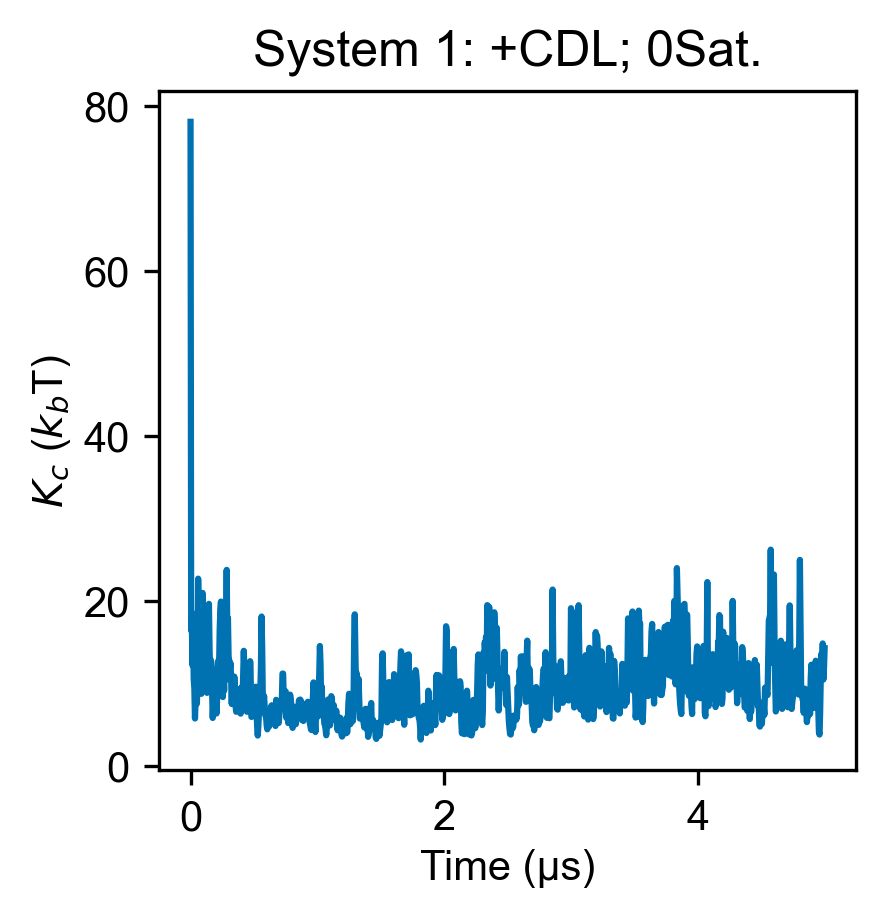

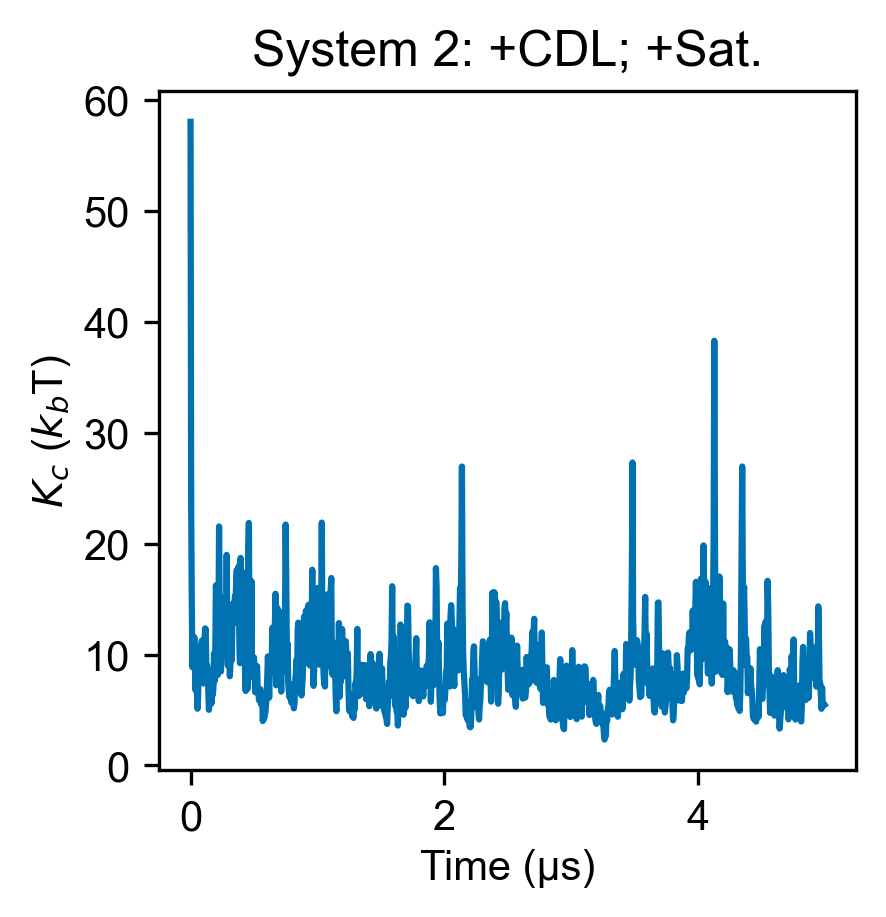

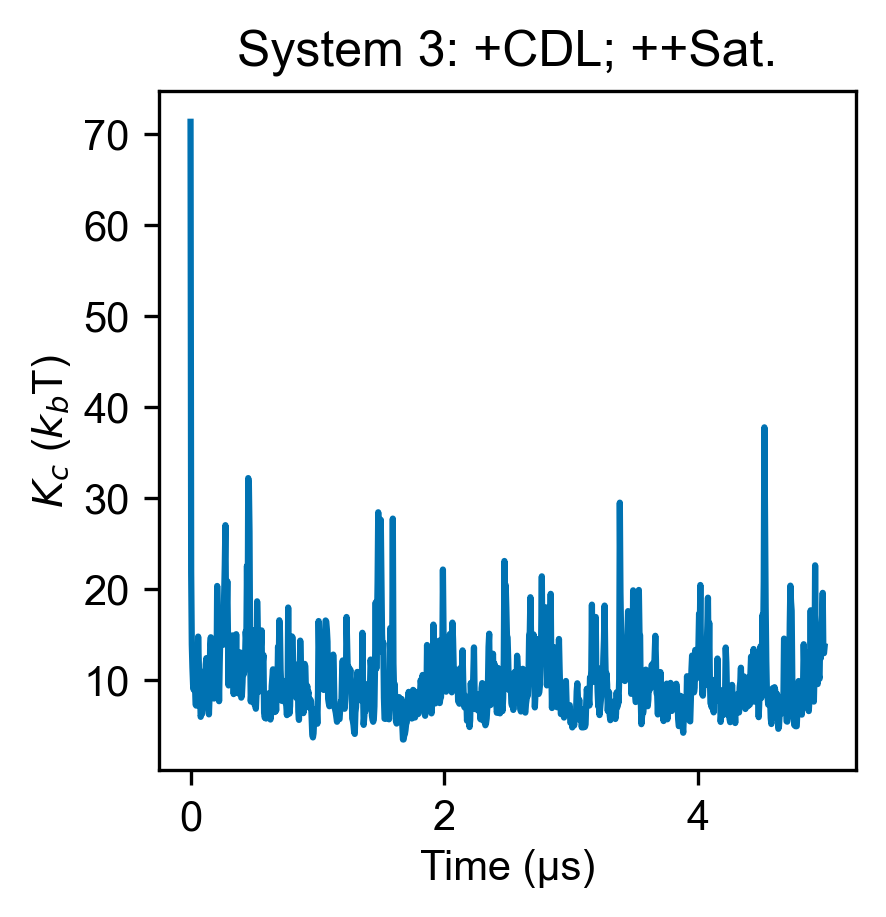

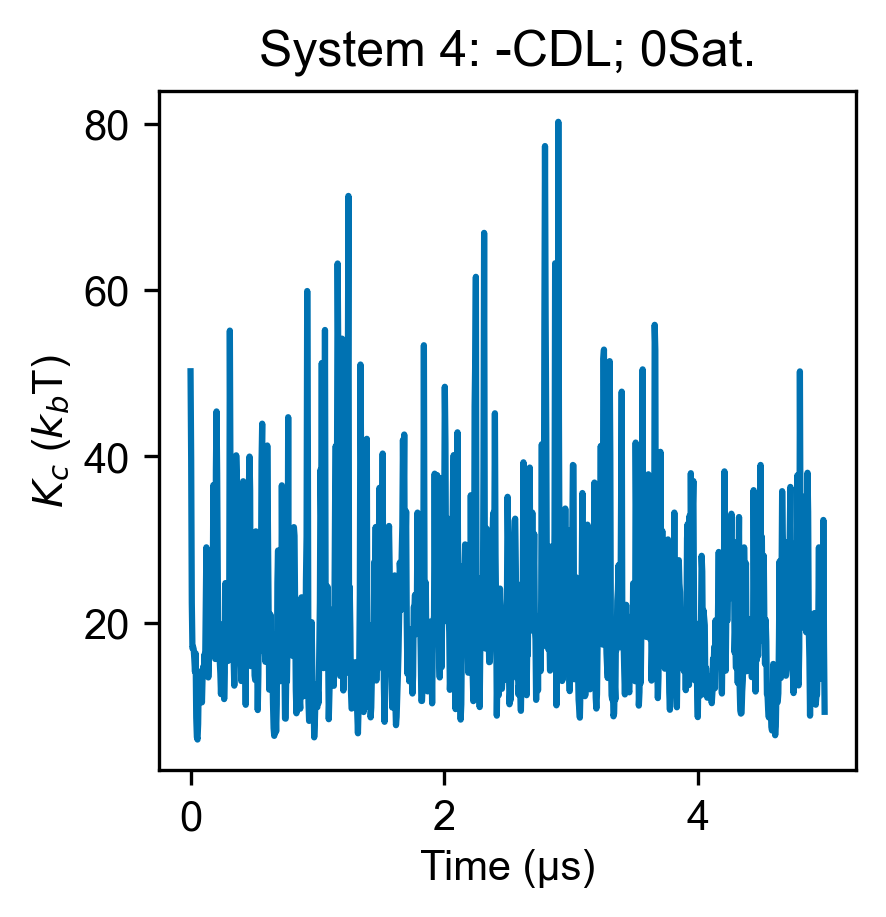

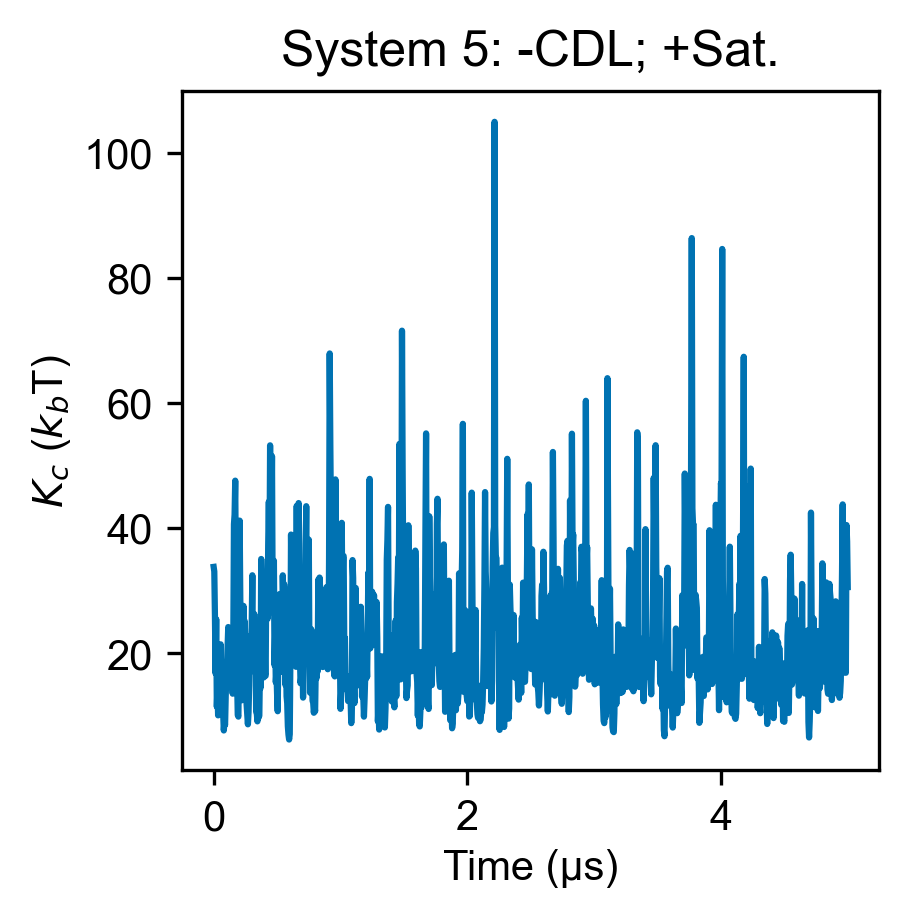

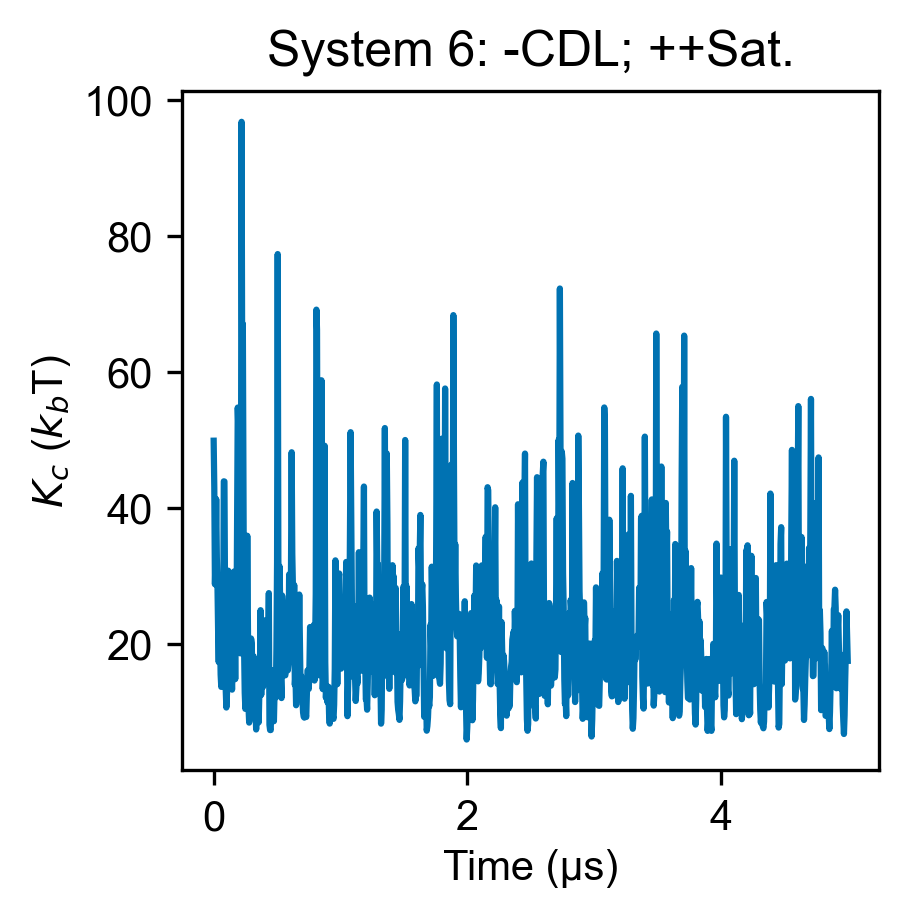

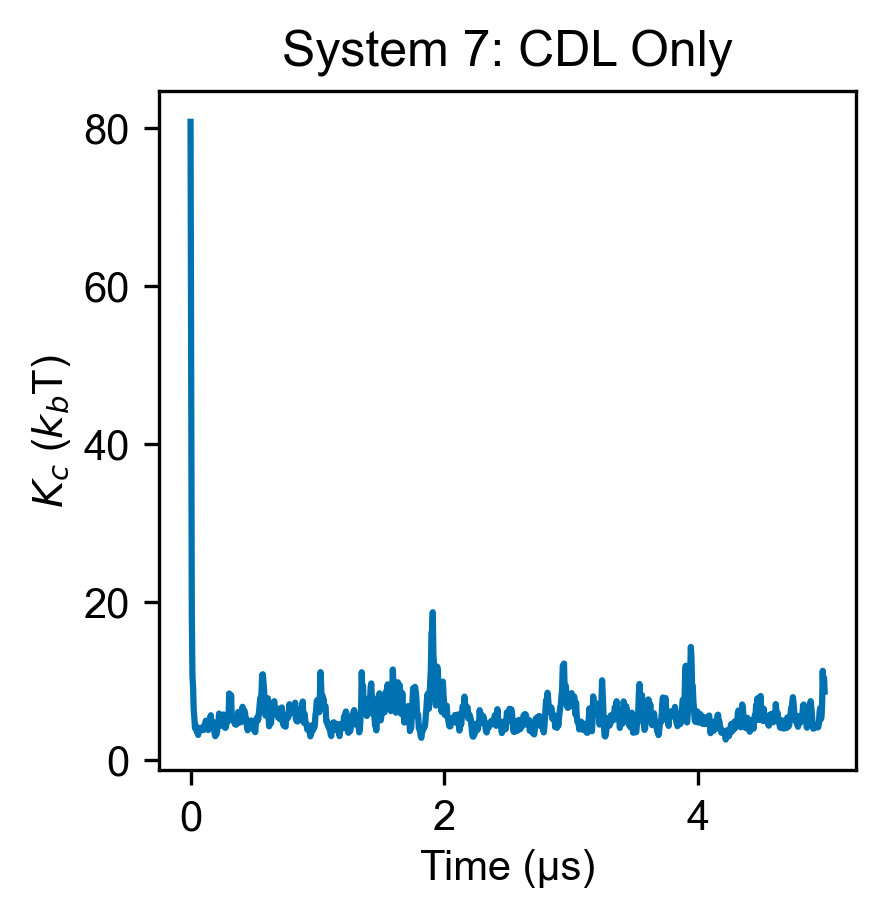

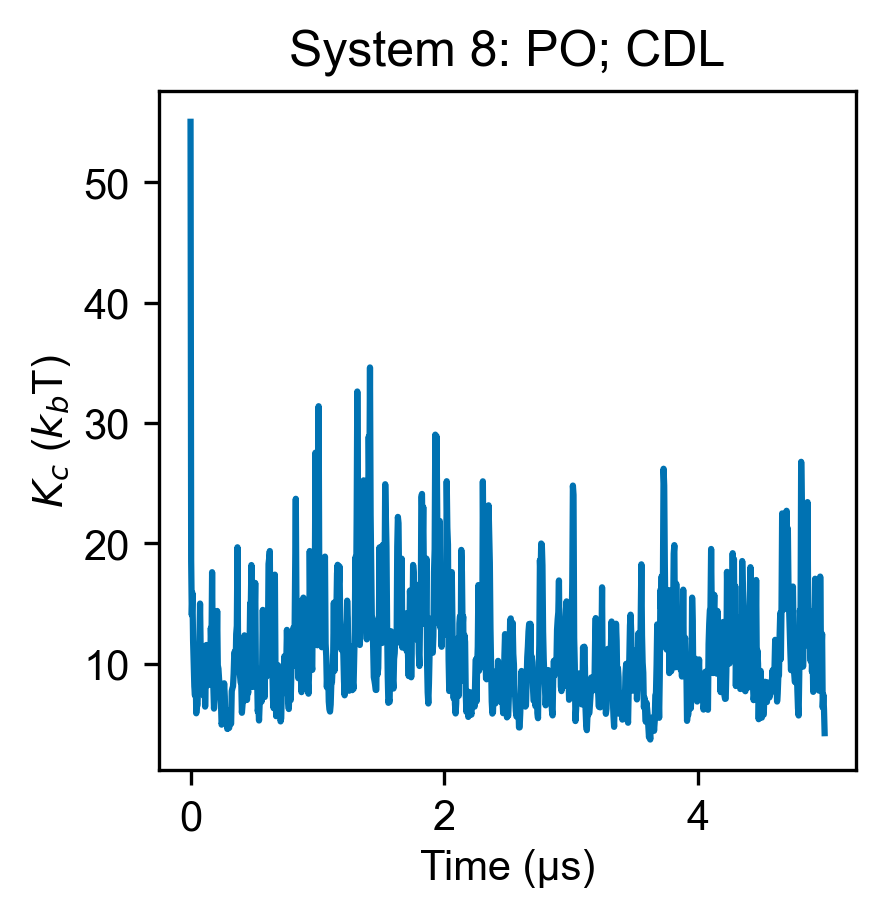

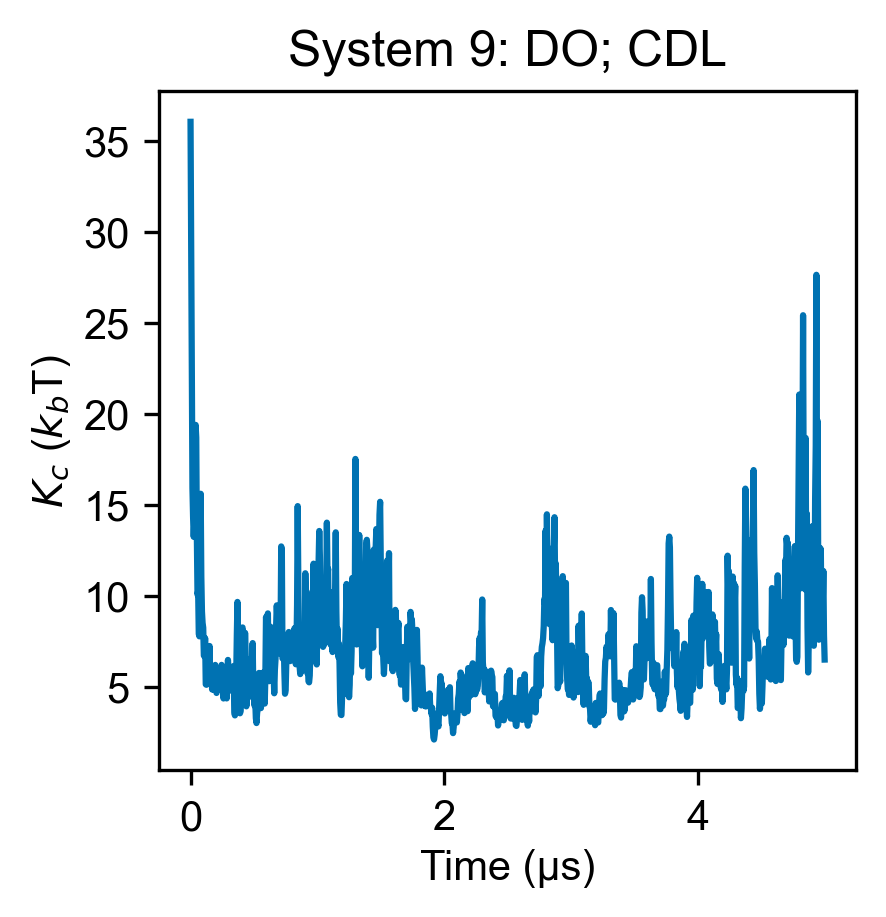

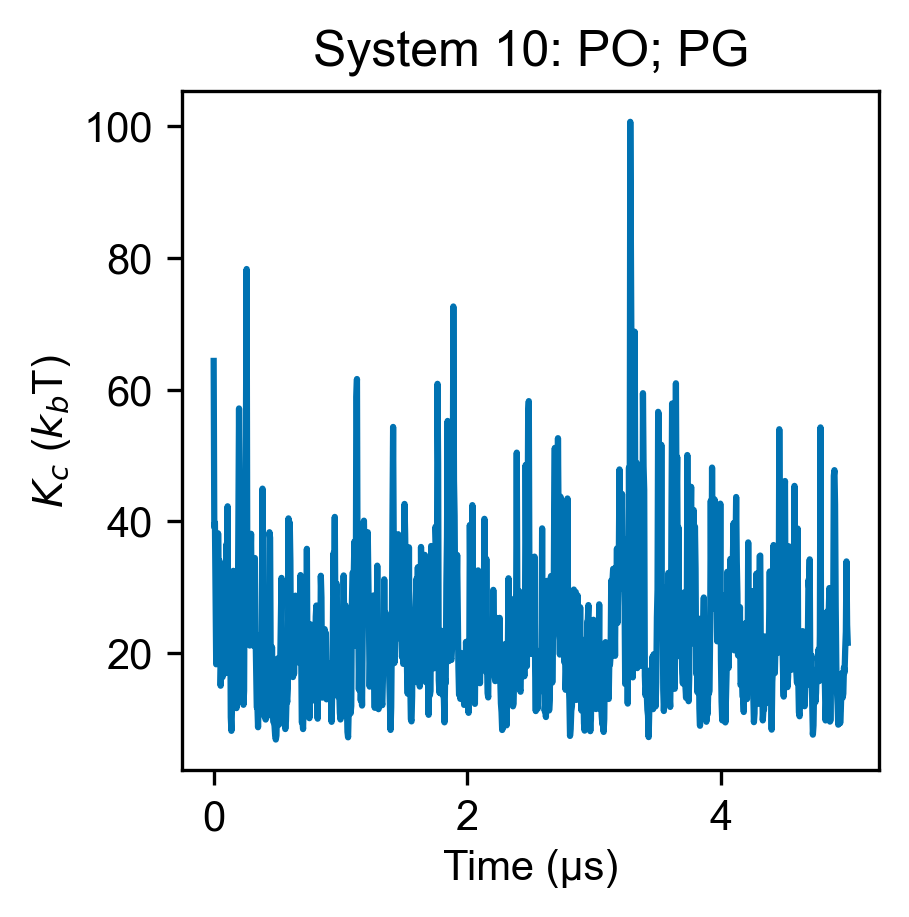

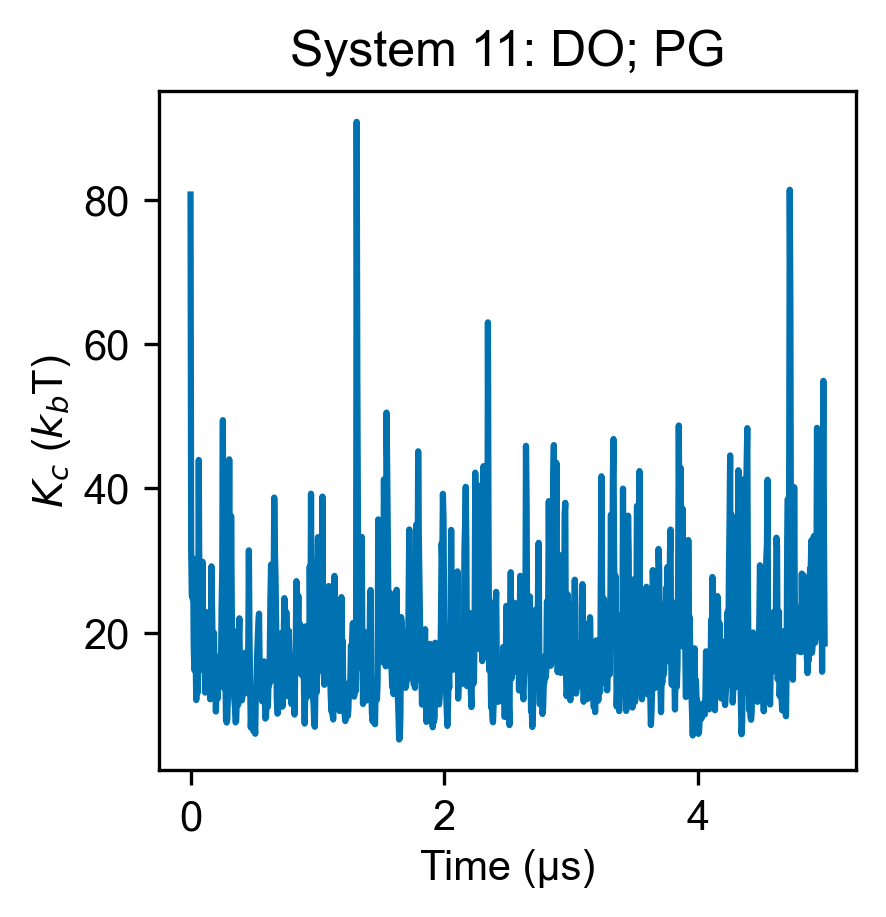

In [9]:
_s = 10  # Min block

discards = np.arange(0, 100, 10)  # Percent of data to discard from end
blocks = np.arange(1, 101, 1, dtype=int)

for sys in simulations:
    print("Processing system:", sys)

    # Populate some basic information
    frame_dt = mc[sys].times[1] - mc[sys].times[0]  # picoseconds

    print(frame_dt)
    _b = 0
    _e = len(mc[sys].frames)
    n_frames = len(range(_b, _e + 1, _s))
    shape = mc[sys].P.shape

    # Times from mdanalysis are unreliable due to restarts
    # times = mc[sys].times[np.arange(0, _e, _s, dtype=int)]
    times = np.arange(0, _e, _s, dtype=int) * frame_dt  # picoseconds

    # Split into chunks and compute kcs
    split_indices = np.arange(_s, _e, _s, dtype=int)
    powers = np.fromiter(
        map(
            partial(np.mean, axis=0),
            np.split(mc[sys].results["height_power_spectrum"], split_indices),
        ),
        dtype=np.dtype((np.double, (shape))),
    )
    kcs = np.fromiter(
        map(partial(fit_kc_from_power, threshold=kc_low_q, mc=mc[sys]), powers), dtype=np.double
    )

    # Plot Kc evaluated over 5ns (0.5 * _s) blocks
    fig, ax = plt.subplots(1, 1, figsize=(3, 3)) # sharex=True,
    # fig.subplots_adjust(hspace=0.05)  # adjust space between axes

    ax.plot(times * 1e-6, kcs)  # Convert to microseconds
    # ax2.plot(times * 1e-6, kcs)  # Convert to microseconds

    # ax1.set_ylim(50, 100)
    # ax2.set_ylim(0, 30)

    # # hide the spines between ax and ax2
    # ax1.spines.bottom.set_visible(False)
    # ax2.spines.top.set_visible(False)
    # ax1.xaxis.tick_top()
    # ax1.tick_params(labeltop=False)  # don't put tick labels at the top
    # ax2.xaxis.tick_bottom()


    # # Now, let's turn towards the cut-out slanted lines.
    # # We create line objects in axes coordinates, in which (0,0), (0,1),
    # # (1,0), and (1,1) are the four corners of the axes.
    # # The slanted lines themselves are markers at those locations, such that the
    # # lines keep their angle and position, independent of the axes size or scale
    # # Finally, we need to disable clipping.

    # d = .5  # proportion of vertical to horizontal extent of the slanted line
    # kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
    #             linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    # ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
    # ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

    ax.set_ylabel(r"$K_c$ ($k_b$T)")
    ax.set_xlabel(r"Time (μs)")

    ax.set_title(f"System {sys}: {system_names[sys]}")

    # fig.tight_layout()
    save_fig(fig, f"Figures/{sys}_kc_5nsblock")


    ## Perform block analysis
    kc_mean = kcs.mean()

    SI = {}
    SI["discards"] = discards
    SI["blocks"] = blocks * frame_dt * _s  # picoseconds

    for discard in discards:
        _, r = np.split(kcs, [int(discard / 100 * n_frames)])
        kc_mean = r.mean()

        SI[(discard, "sigma")] = np.zeros(len(blocks))
        SI[(discard, "mean")] = np.zeros(len(blocks))

        for i, block in enumerate(blocks):
            n = np.floor(len(r) / block)

            split_indices = np.arange(block, len(r), block, dtype=int)
            block_kcs = np.fromiter(
                map(np.mean, np.split(r, split_indices)), dtype=np.double
            )

            # Truncate number of blocks if not evenly divisible
            if len(r) % block:
                block_kcs = block_kcs[:-1]

            SI[(discard, "sigma")][i] = np.sum((block_kcs - kc_mean) ** 2) / n
            SI[(discard, "mean")][i] = np.mean(block_kcs)

    with open(util.analysis_path / f"{sys}/SI.pickle", "wb") as handle:
        pickle.dump(SI, handle, protocol=pickle.HIGHEST_PROTOCOL)
        

In [10]:
# Load bending modulus statistical inefficiency
SI_kc = {}
for sys in simulations:
    with open(util.analysis_path / f"{sys}/SI.pickle", "rb") as handle:
        SI_kc[sys] = pickle.load(handle)

In [11]:
# Foreshadow percent discard, statistical inefficiency for all systems
si_kc_system = {
    1: (50, 25),
    2: (50, 25),
    3: (50, 25),
    4: (50, 13),
    5: (20, 15),
    6: (20, 15),
    7: (50, 28),
    8: (50, 25),
    9: (50, 25),
    10: (50, 25),
    11: (50,25)
}

for sys in simulations:
    print(f"System {sys} ({system_names[sys]}):")
    print(f"  statistical inefficiency: {si_kc_system[sys][1]} ns")
    print(f"                   discard: {si_kc_system[sys][0]}%")


System 1 (+CDL; 0Sat.):
  statistical inefficiency: 25 ns
                   discard: 50%
System 2 (+CDL; +Sat.):
  statistical inefficiency: 25 ns
                   discard: 50%
System 3 (+CDL; ++Sat.):
  statistical inefficiency: 25 ns
                   discard: 50%
System 4 (-CDL; 0Sat.):
  statistical inefficiency: 13 ns
                   discard: 50%
System 5 (-CDL; +Sat.):
  statistical inefficiency: 15 ns
                   discard: 20%
System 6 (-CDL; ++Sat.):
  statistical inefficiency: 15 ns
                   discard: 20%
System 7 (CDL Only):
  statistical inefficiency: 28 ns
                   discard: 50%
System 8 (PO; CDL):
  statistical inefficiency: 25 ns
                   discard: 50%
System 9 (DO; CDL):
  statistical inefficiency: 25 ns
                   discard: 50%
System 10 (PO; PG):
  statistical inefficiency: 25 ns
                   discard: 50%
System 11 (DO; PG):
  statistical inefficiency: 25 ns
                   discard: 50%


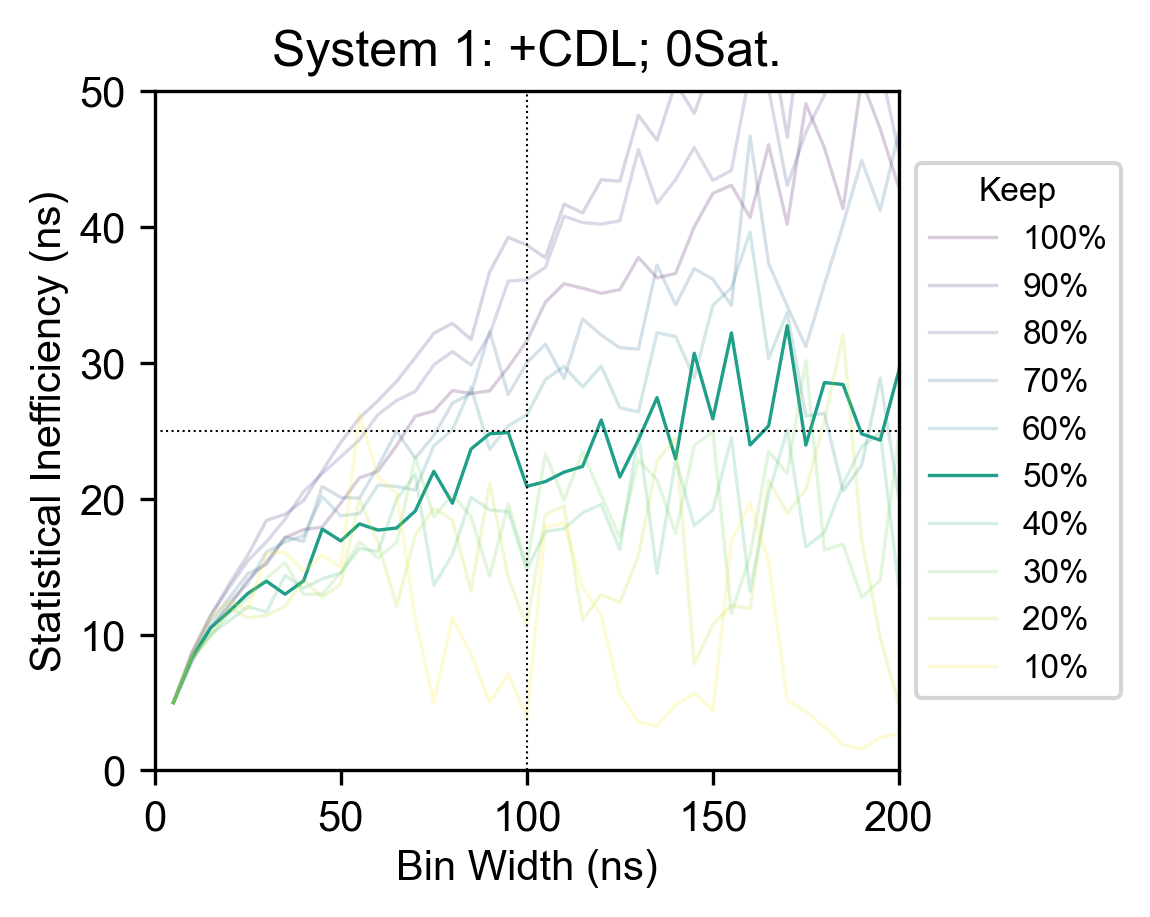

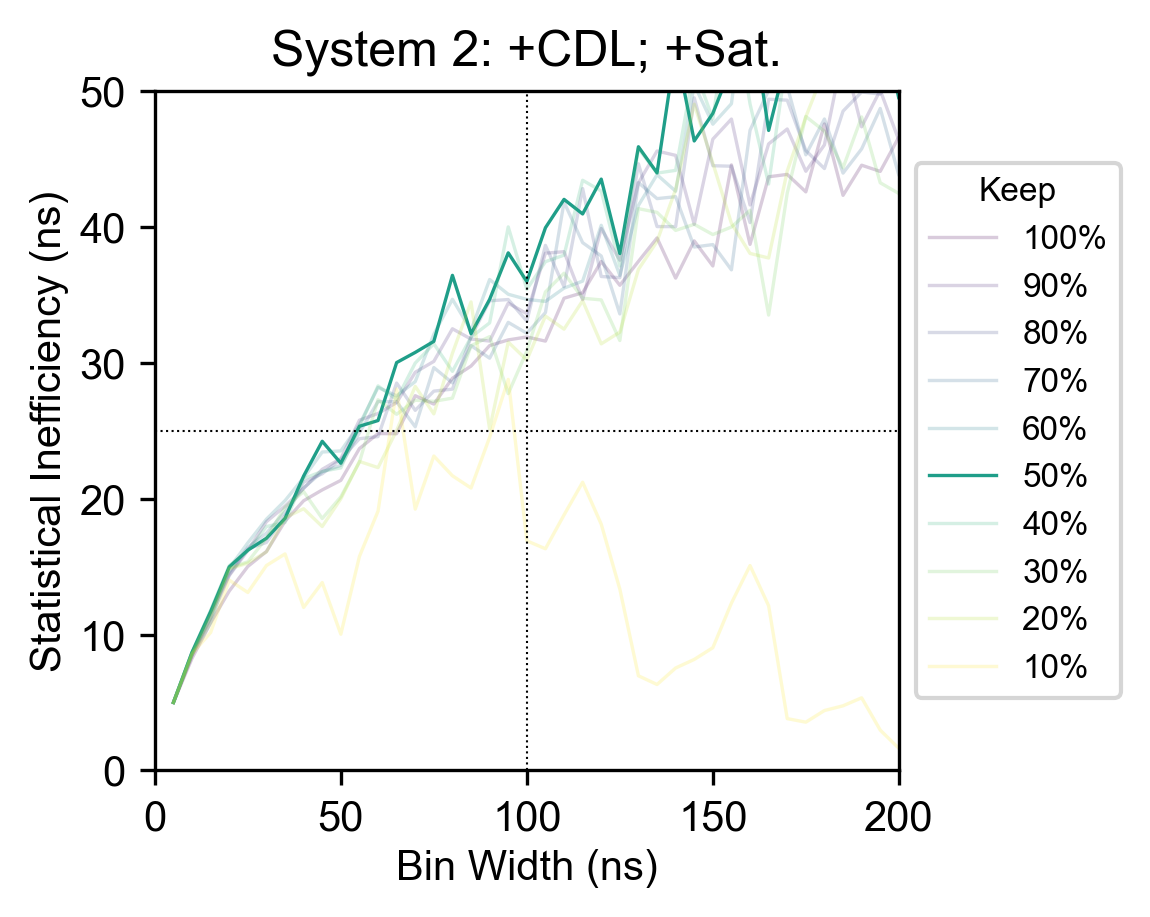

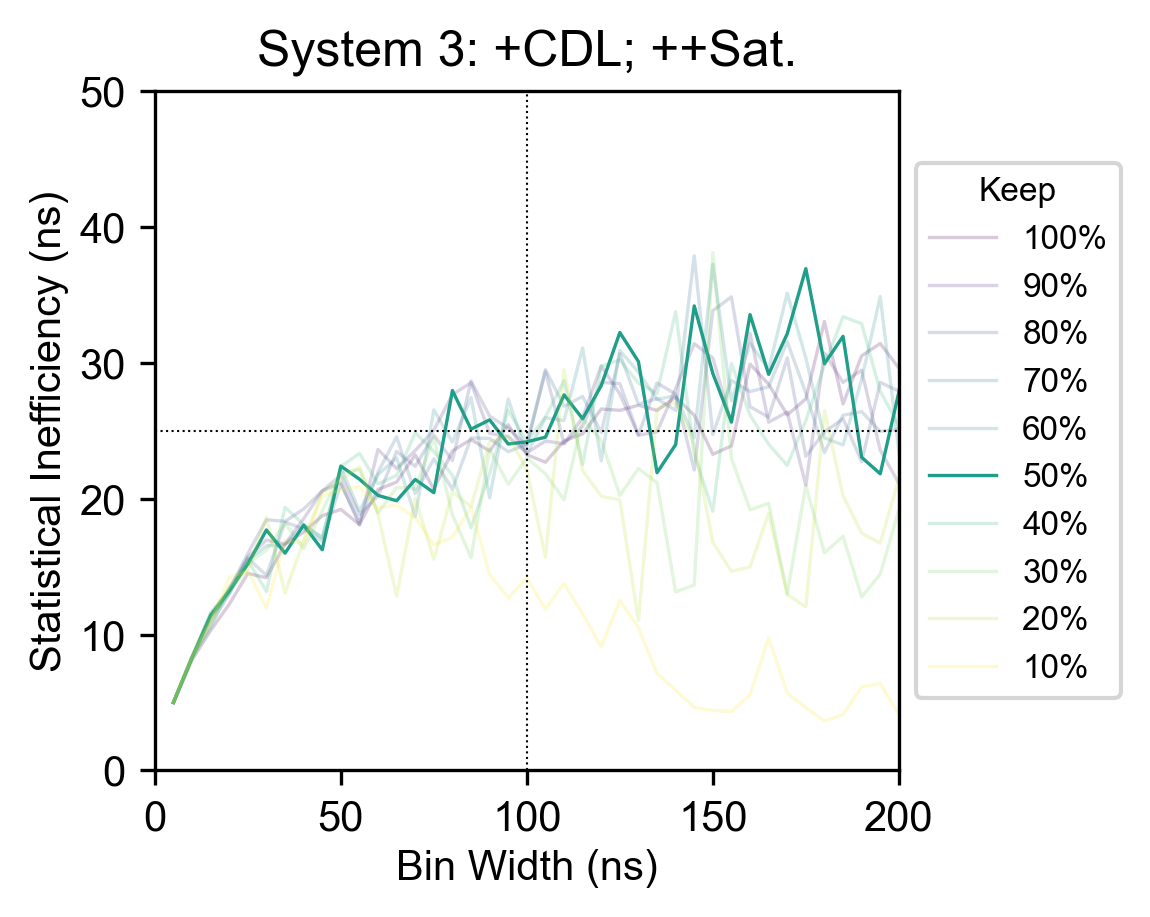

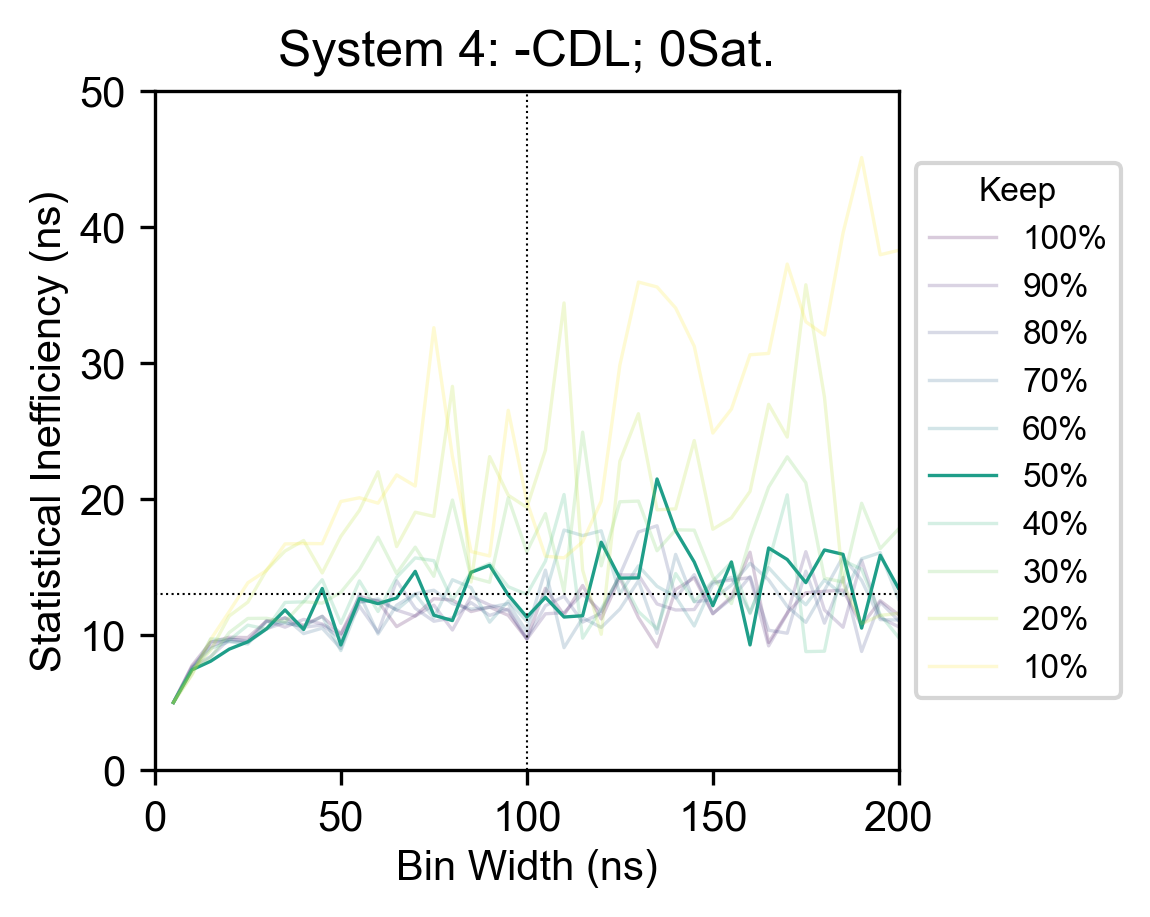

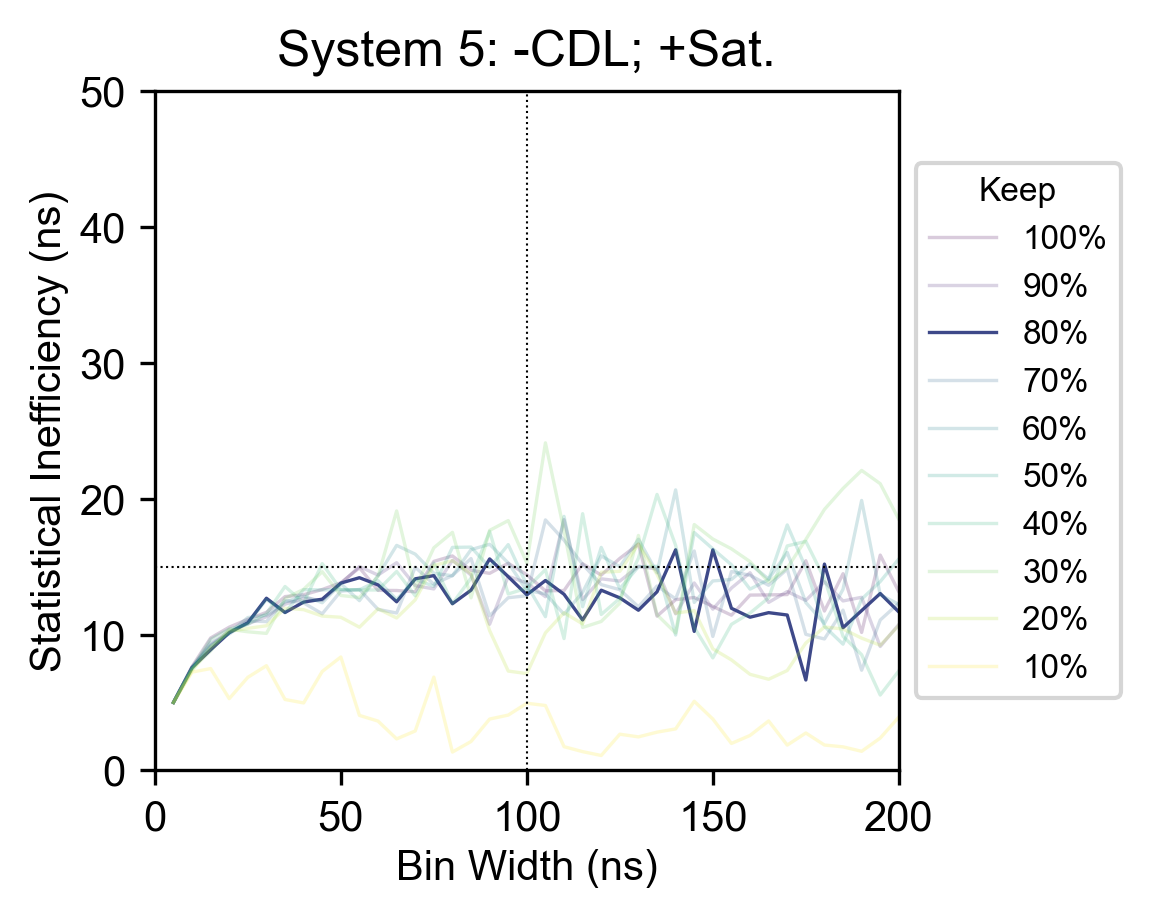

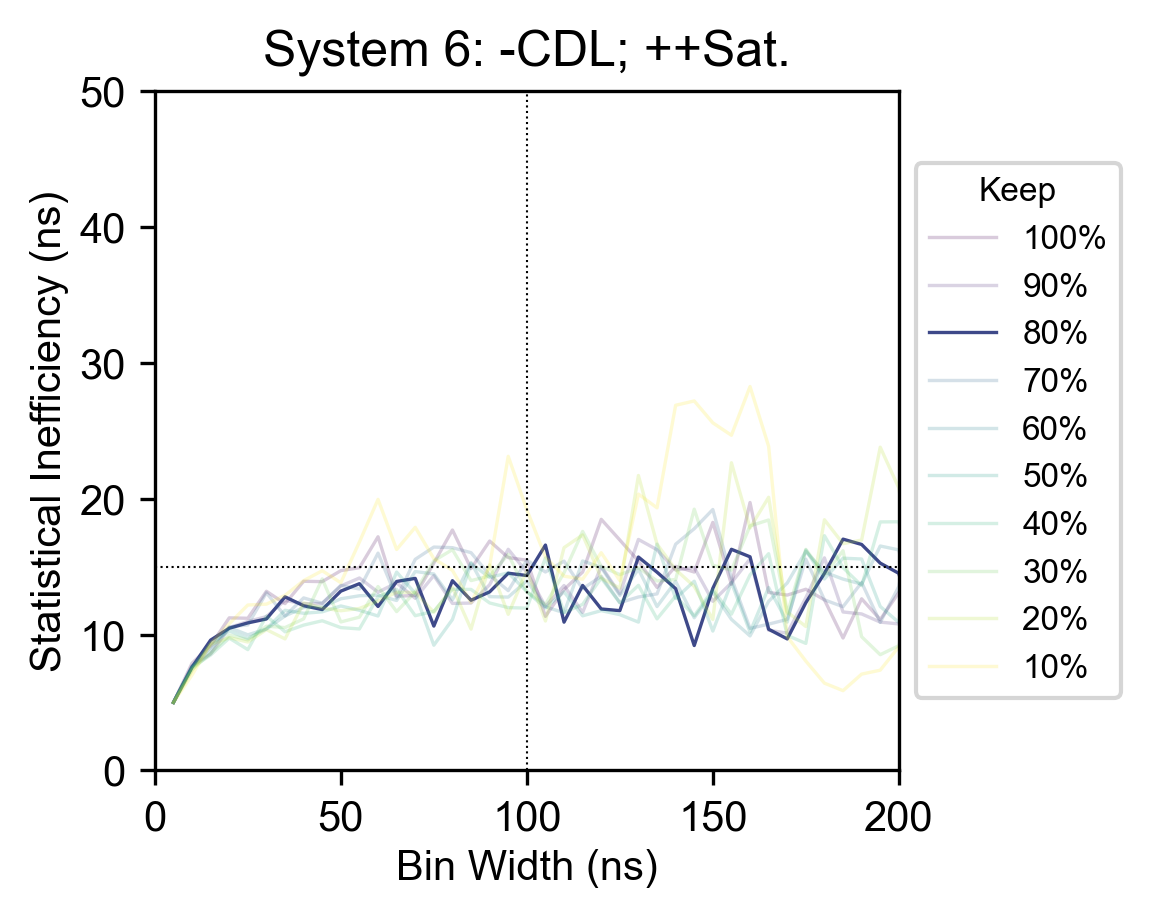

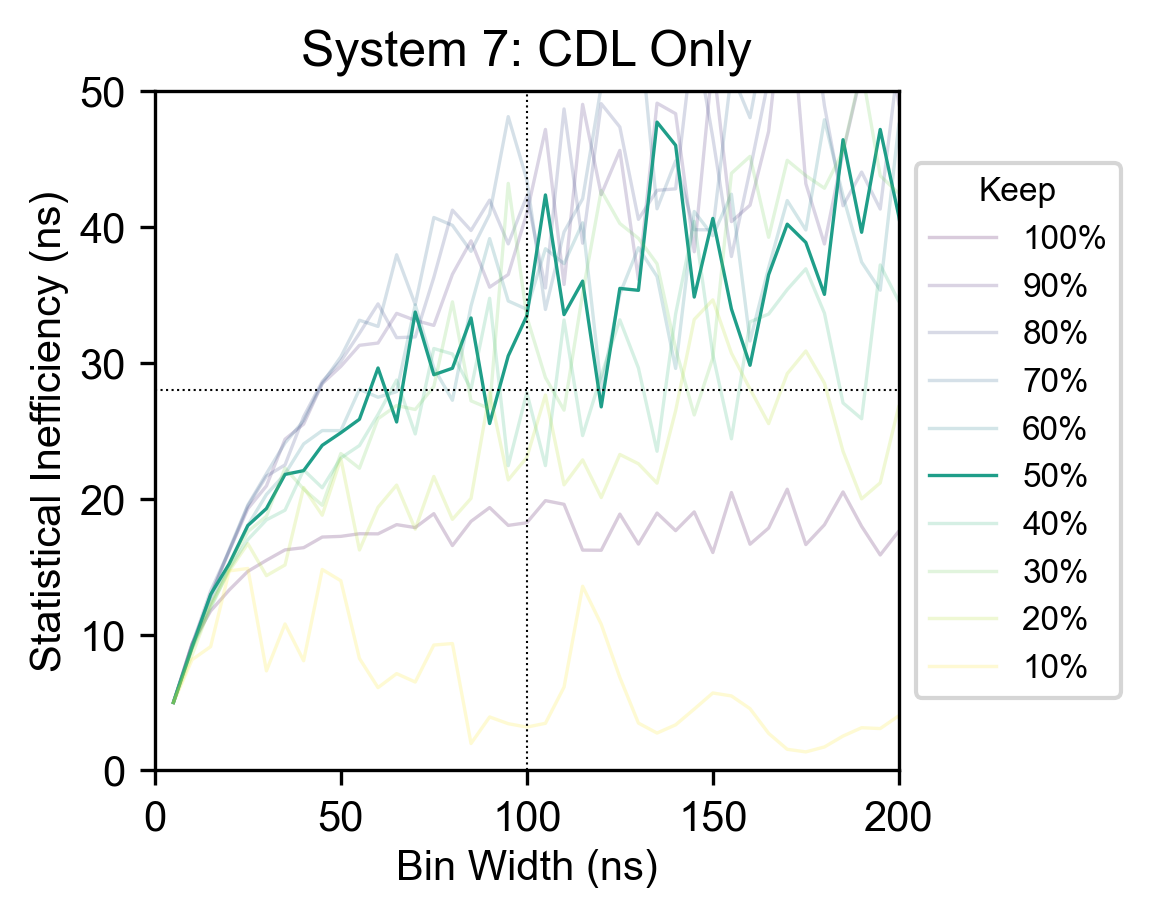

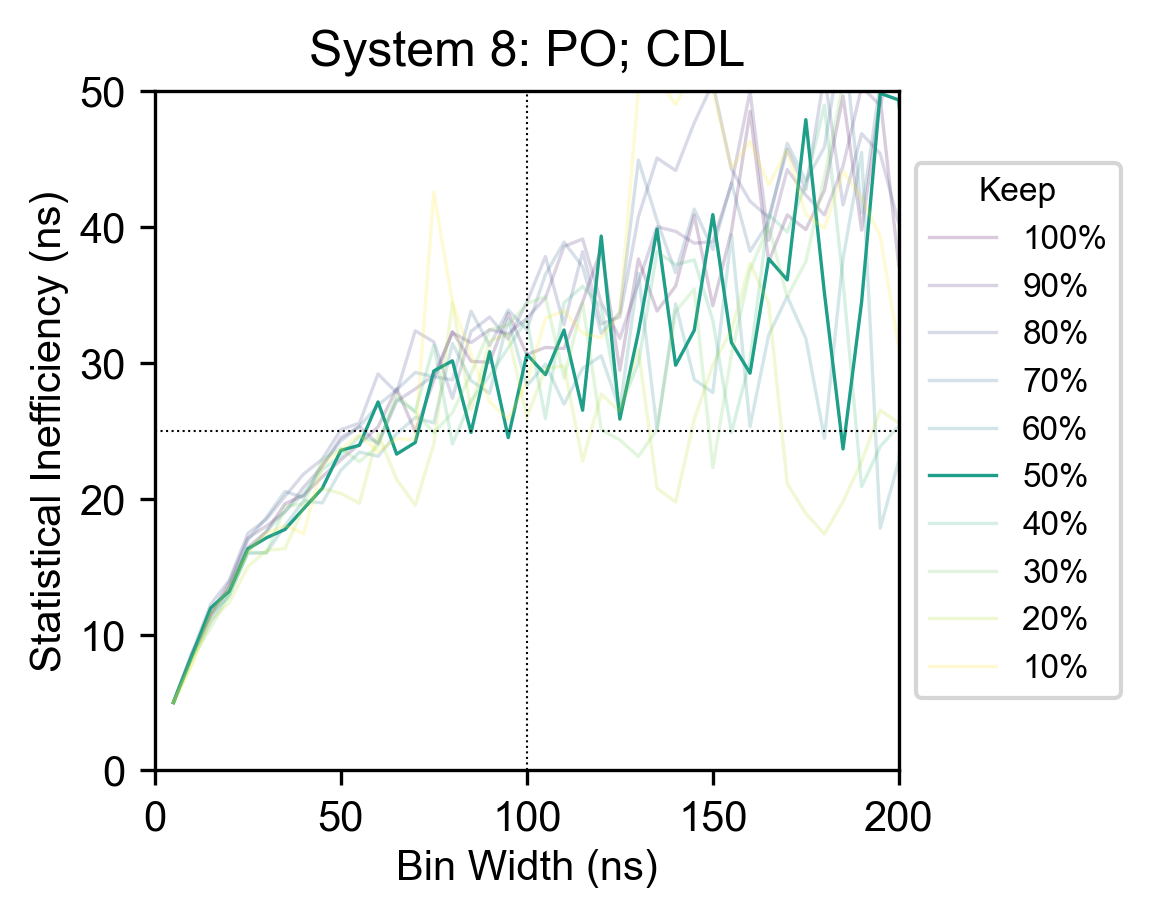

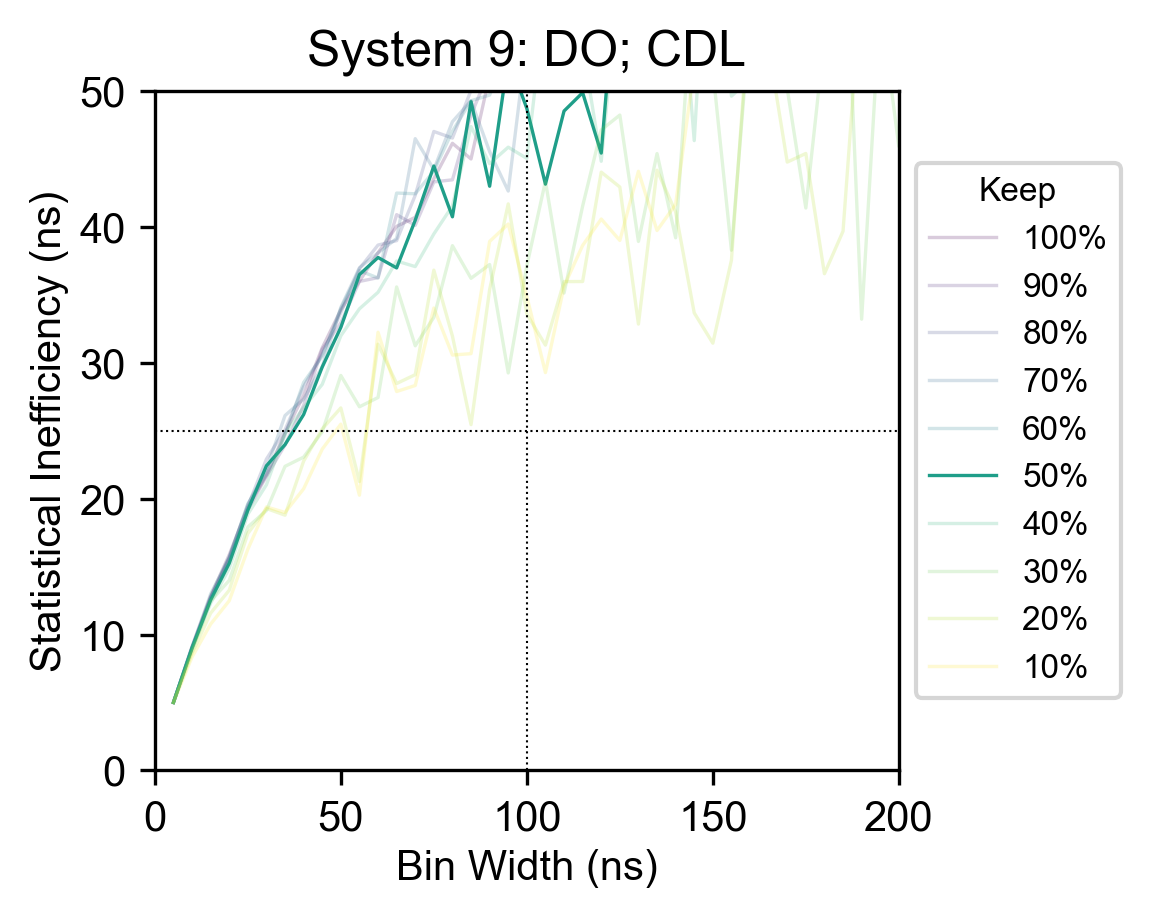

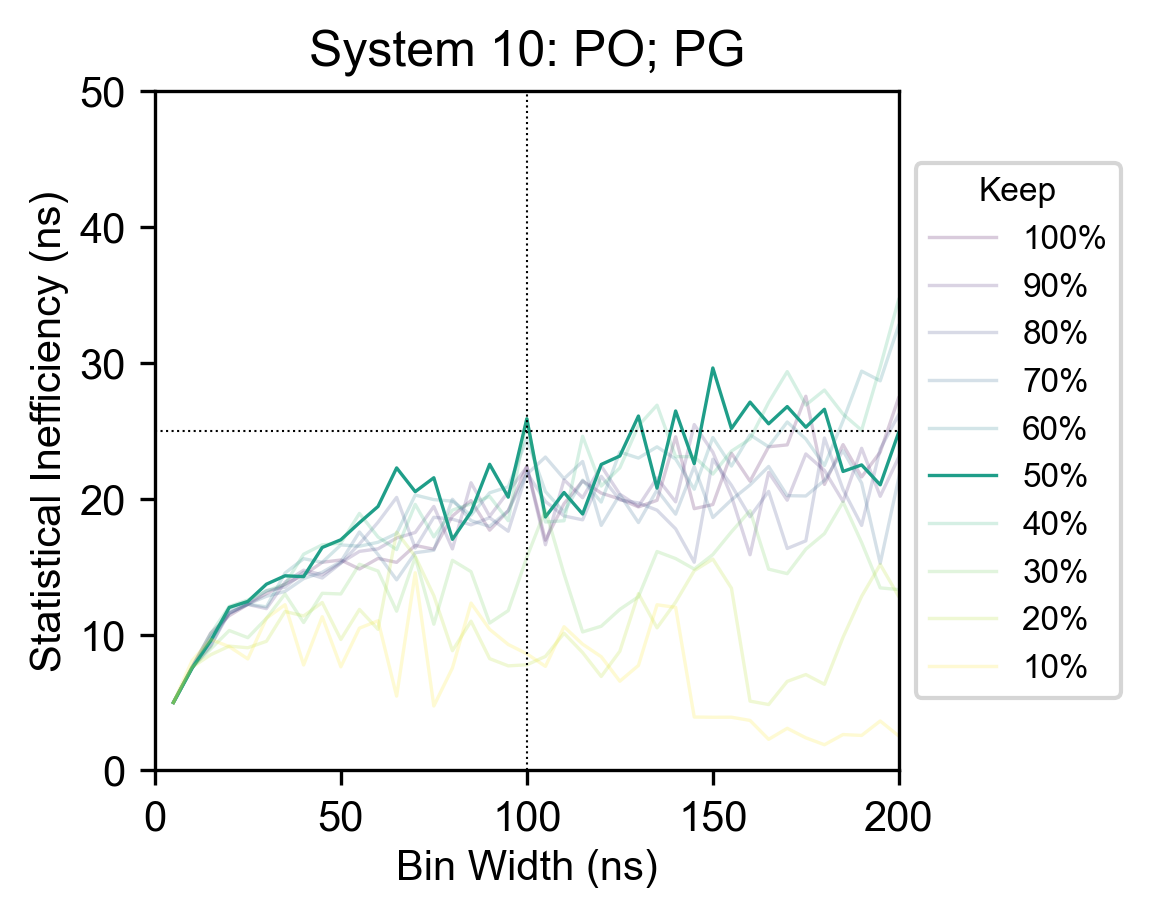

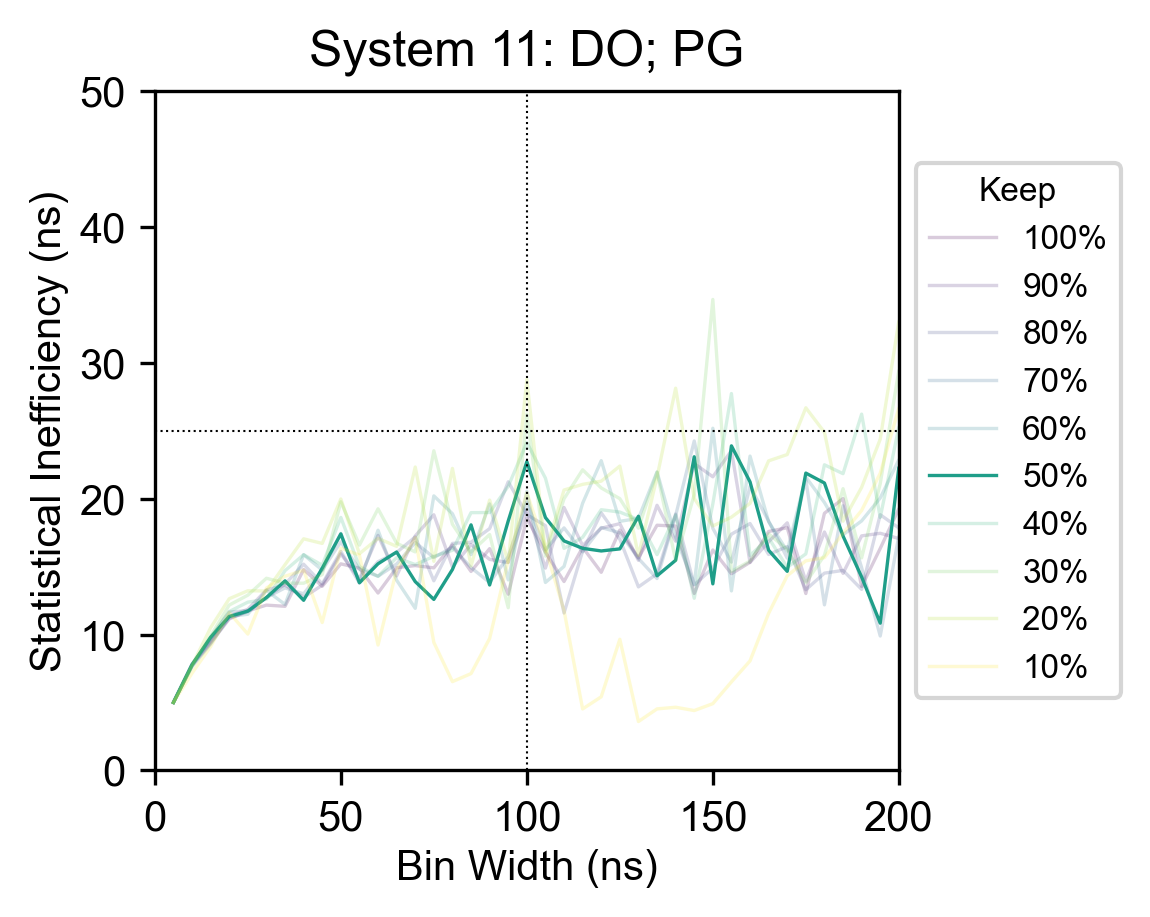

In [12]:
cmap = mpl.cm.get_cmap("viridis")

for sys in simulations:
    d = SI_kc[sys]
    discards = d["discards"]
    c = cmap(np.linspace(0, 1, len(discards)))

    times = d["blocks"] * 1e-3  # picoseconds -> nanoseconds

    fig, ax = plt.subplots(1, 1, figsize=(4, 3))

    for i, discard in enumerate(discards):
        sigma = d[(discard, "sigma")]
        si = times * (sigma / sigma[0])

        if discard == si_kc_system[sys][0]:
            alpha = 1
        else:
            alpha = 0.2
        ax.plot(
            times,
            si,
            color=c[i],
            alpha=alpha,
            linewidth=NORMAL_LINE,
            label=f"{100-discard}%",
        )

    ax.axvline(100, color="k", linestyle="dotted", linewidth=THINNER_LINE)
    ax.axhline(si_kc_system[sys][1], color="k", linestyle="dotted", linewidth=THINNER_LINE)

    ax.set_ylabel(r"Statistical Inefficiency (ns)")
    ax.set_xlabel(r"Bin Width (ns)")
    ax.set_title(f"System {sys}: {system_names[sys]}")
    # ax.legend()

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Keep")

    ax.set_xlim(0, 200)
    ax.set_ylim(0.0, 50)
    # plt.tight_layout()
    save_fig(fig, f"Figures/{sys}_StatIneff")


### Plots of height power spectrum

Processing system: 1
10.468743521499725 13.901976551045381 5003 50.0 1.389780783390901
Processing system: 2
8.019165138564858 12.291484244536473 5003 50.0 1.2287798457784247
Processing system: 3
9.647291006109716 14.65137774900753 5003 50.0 1.4646984312630376
Processing system: 4
20.937420616754952 95.56955792149901 5003 26.0 6.889552273442653
Processing system: 5
21.798875428171492 115.42683485829437 8004 30.0 7.066654757771324
Processing system: 6
21.479561913070867 105.00145145792553 8004 30.0 6.428392560785224
Processing system: 7
5.5276195615773425 2.6183982813869395 5003 56.0 0.2770221332570311
Processing system: 8
10.298796482374454 15.542636353702278 5003 50.0 1.5537975660003498
Processing system: 9
7.14517378239838 10.886797027547008 5003 50.0 1.088353245742187
Processing system: 10
23.197177740953695 134.00644581005093 5003 50.0 13.396626195813742
Processing system: 11
19.363885964313987 88.62360521082229 5003 50.0 8.85970300874668


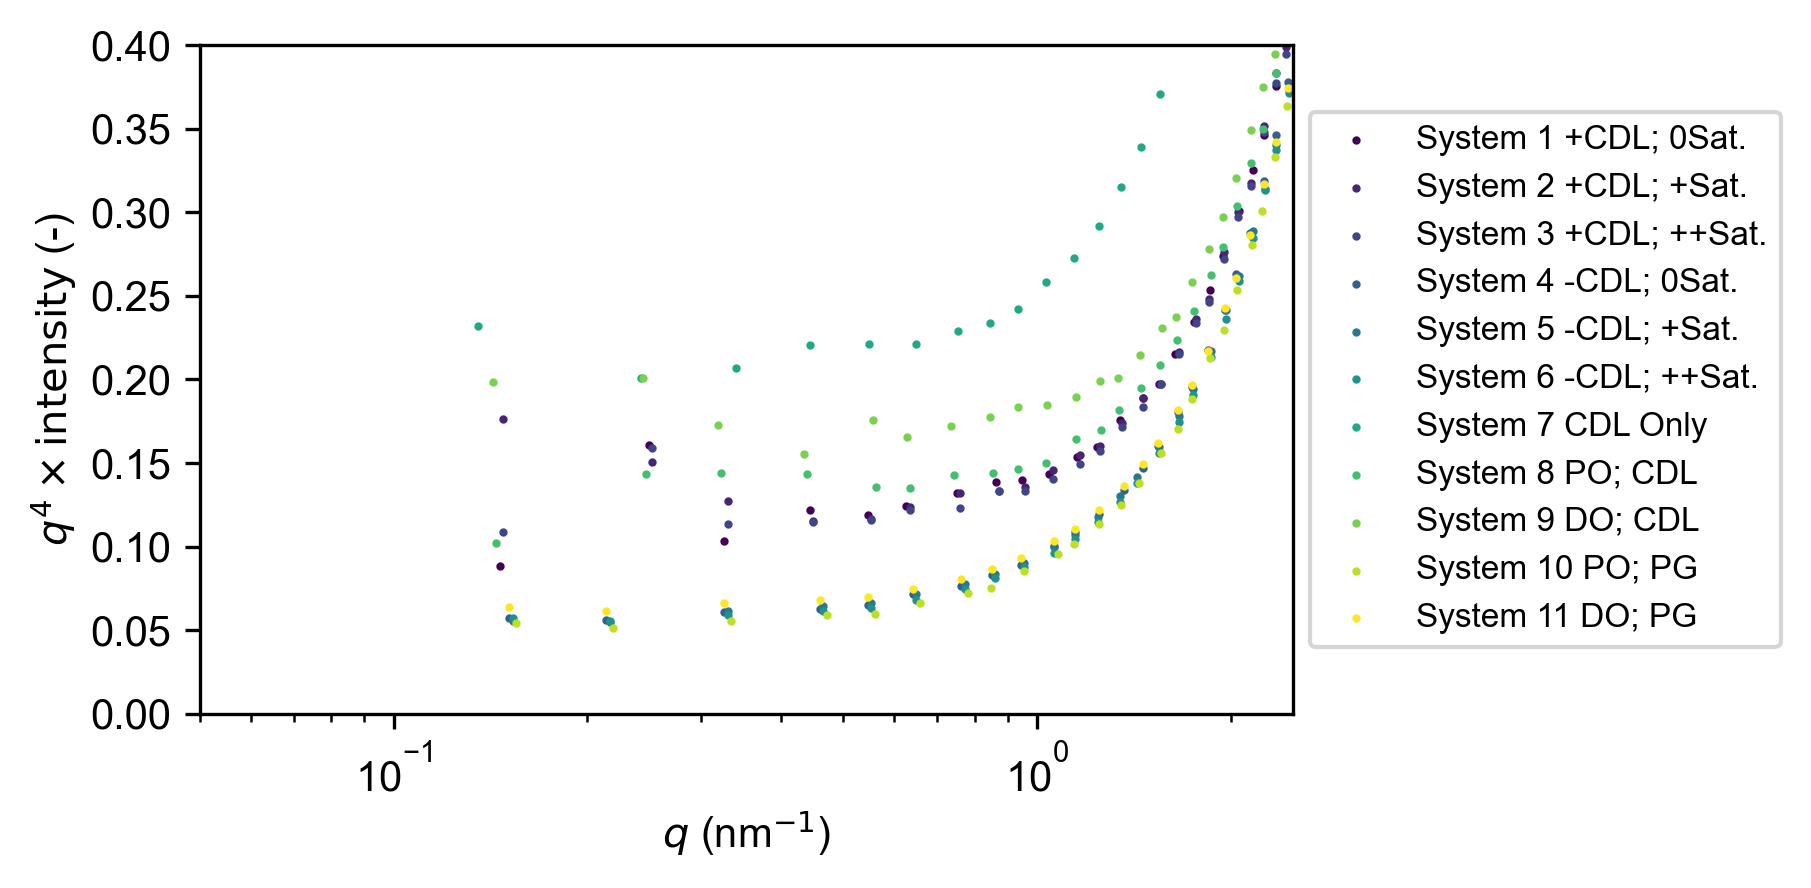

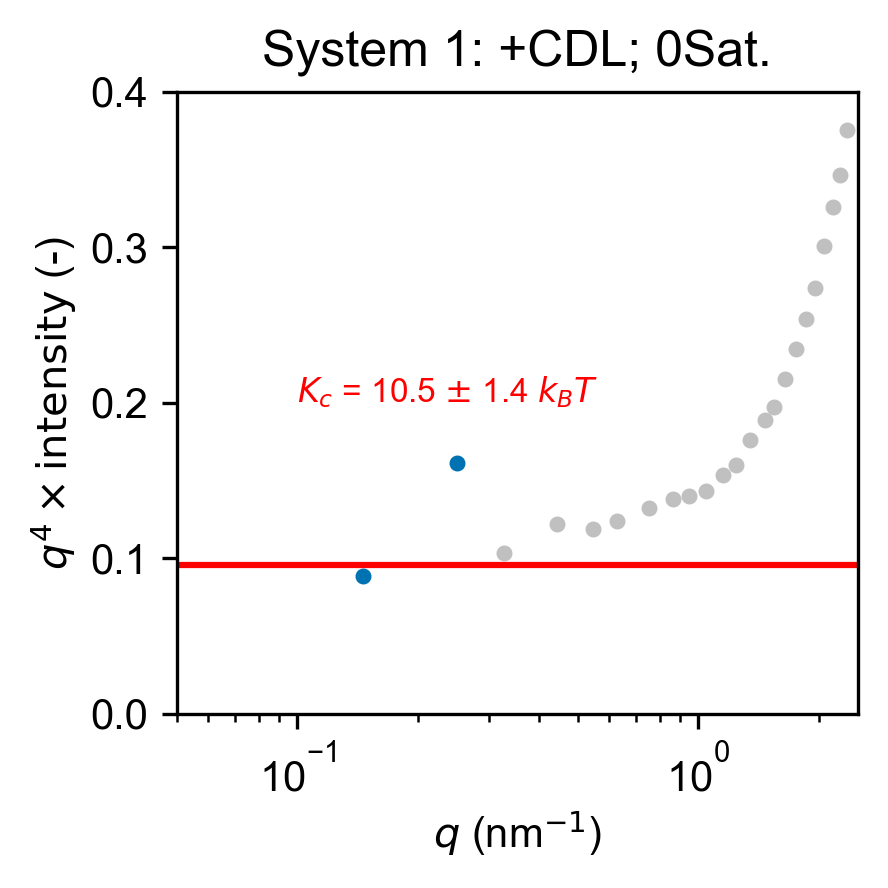

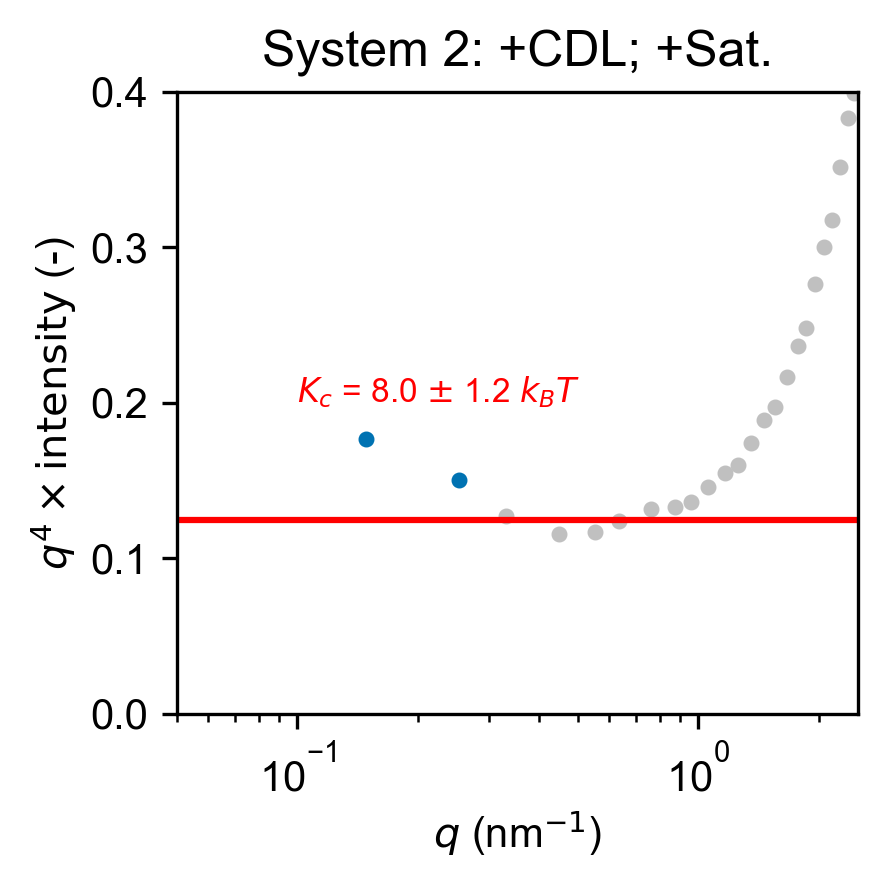

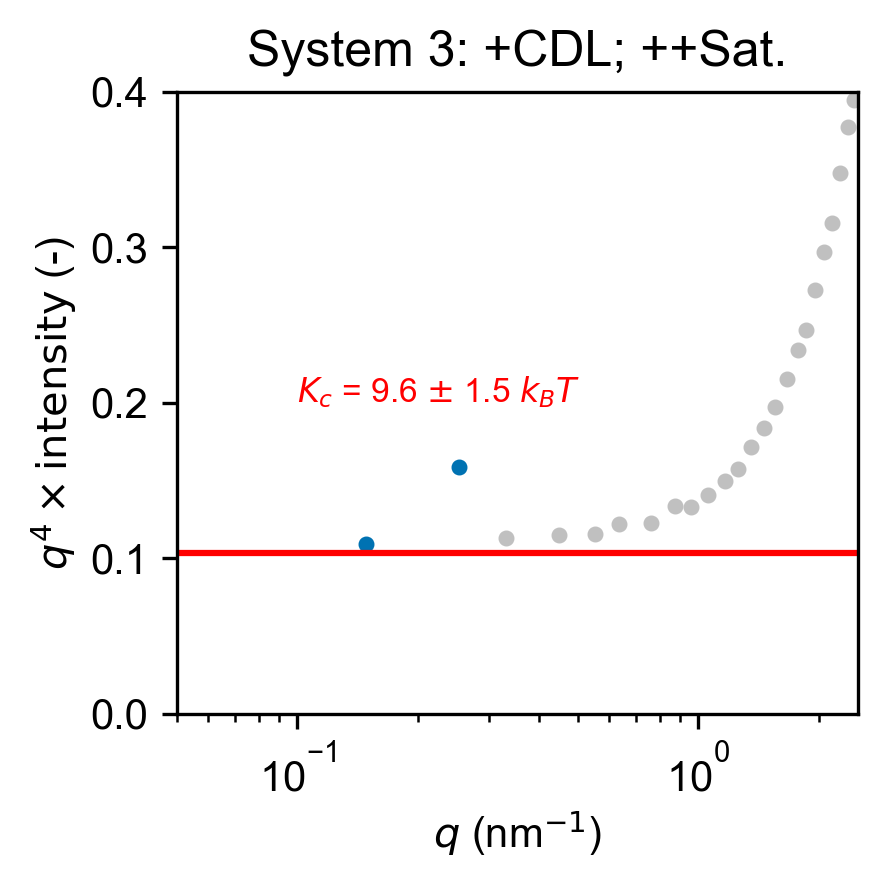

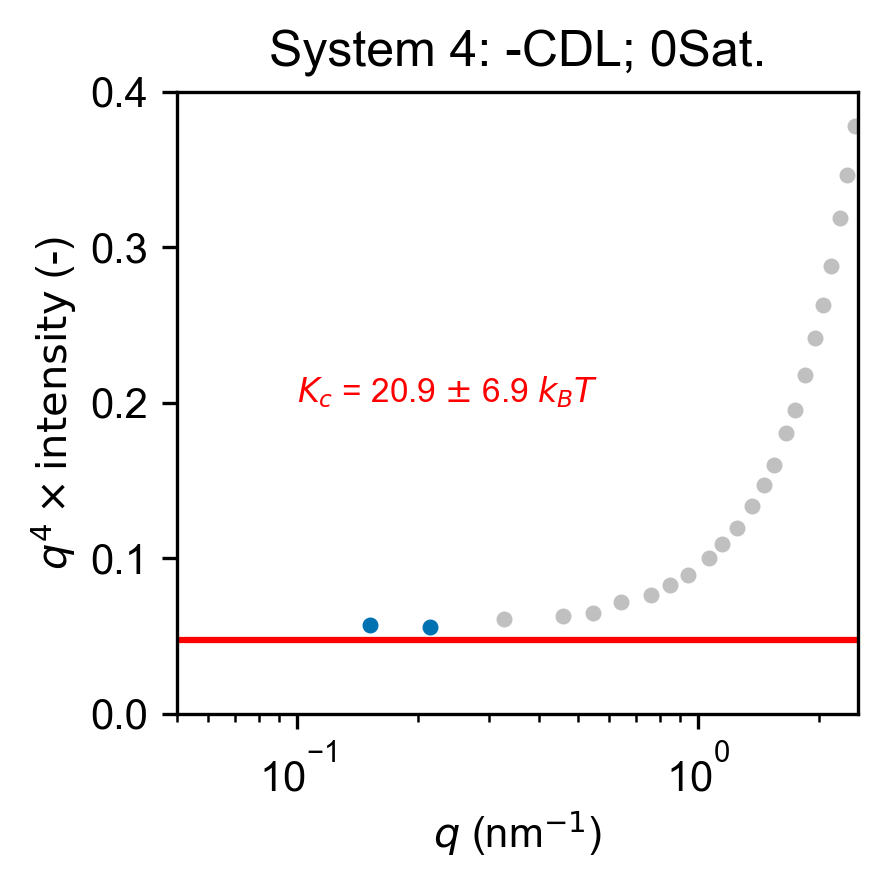

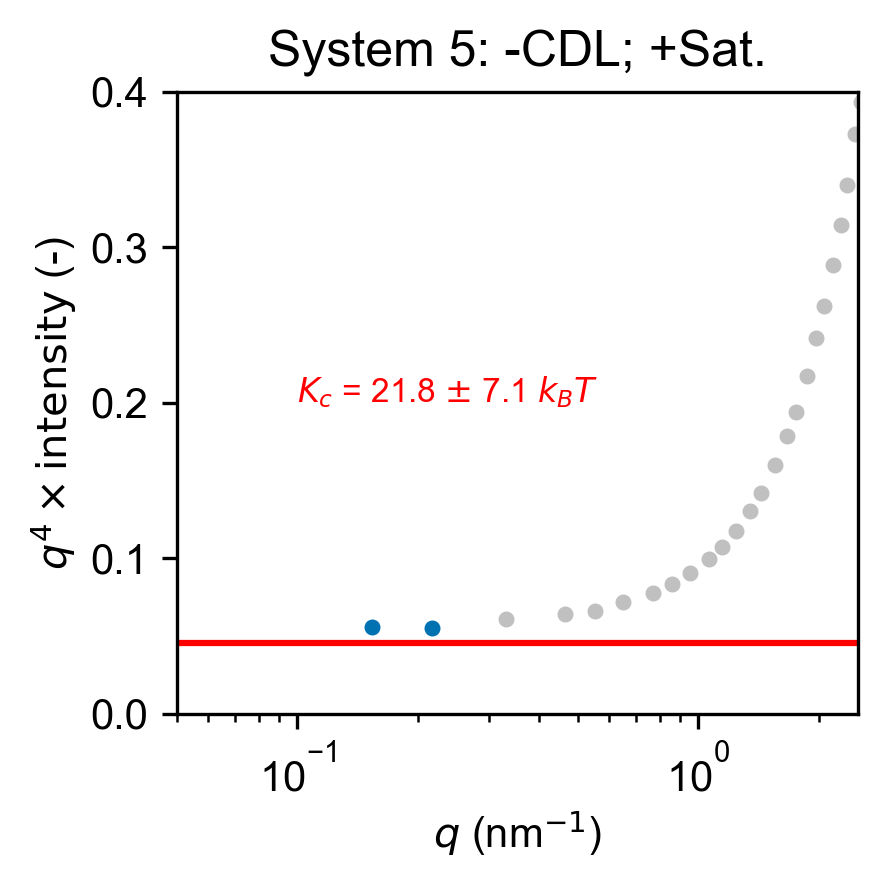

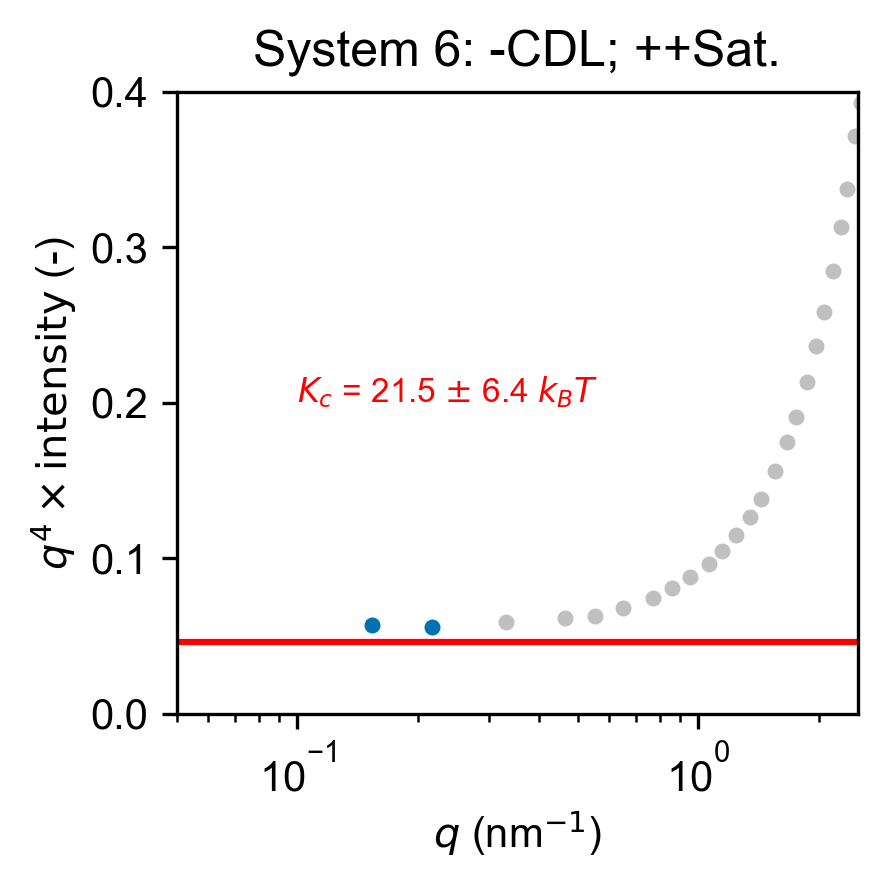

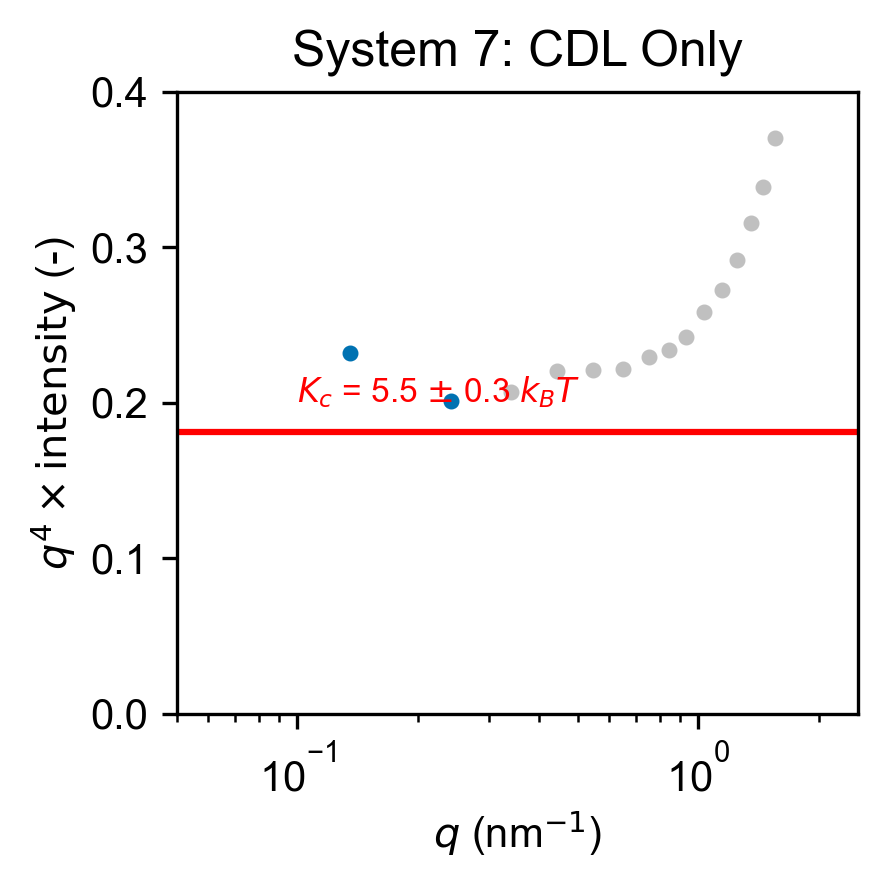

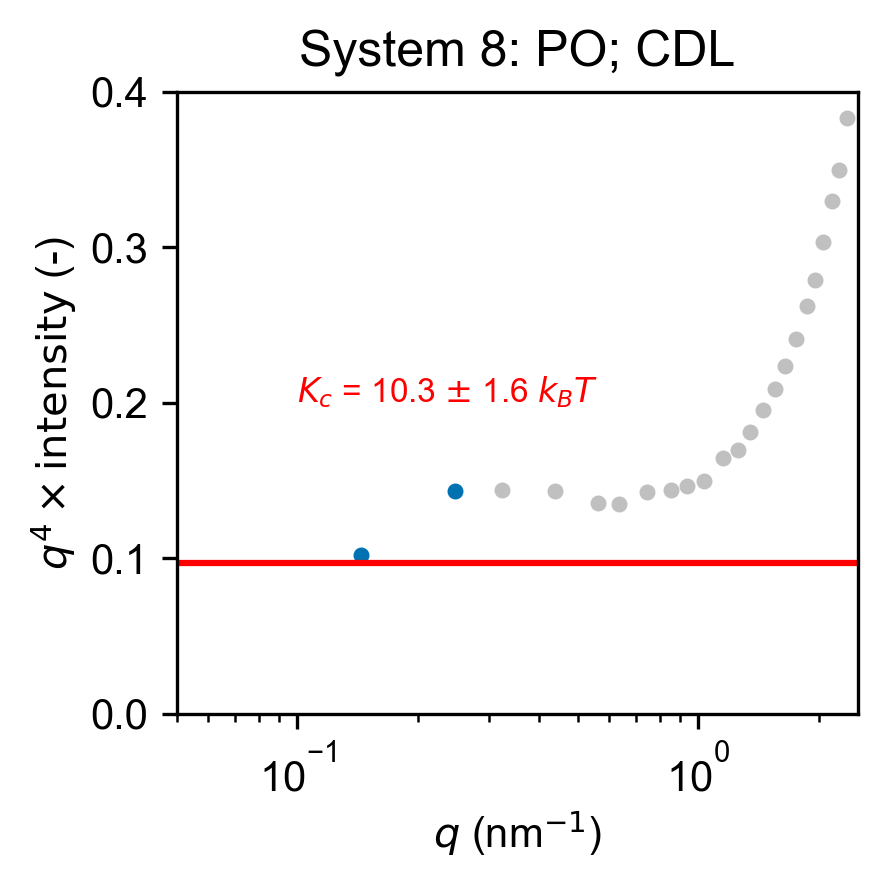

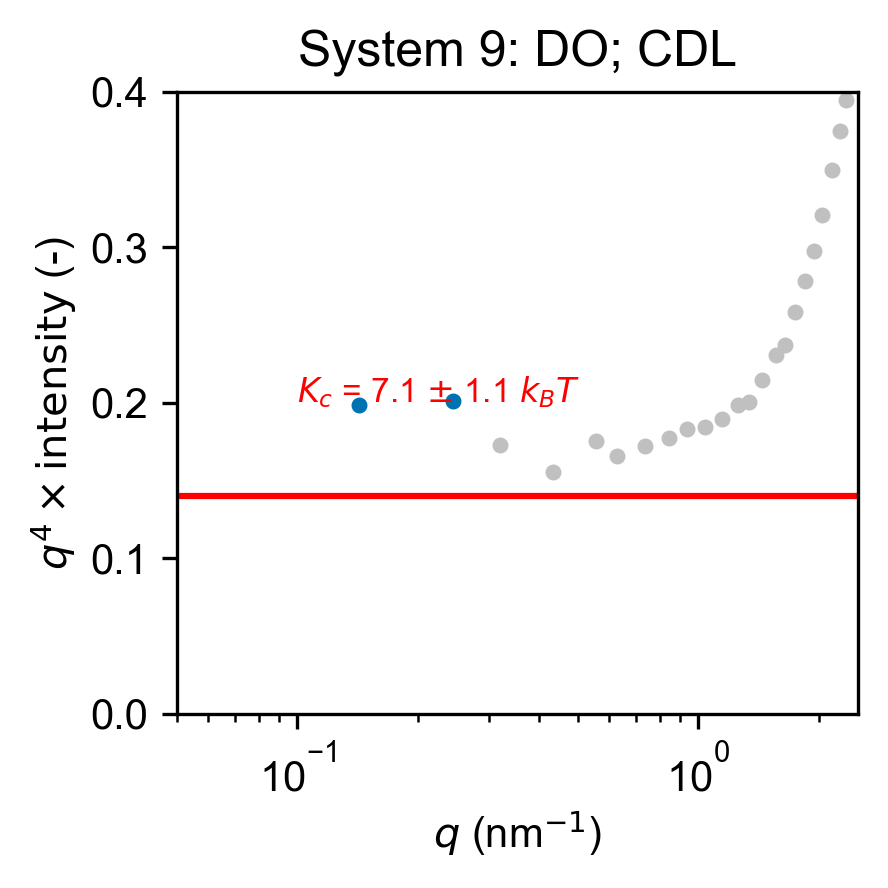

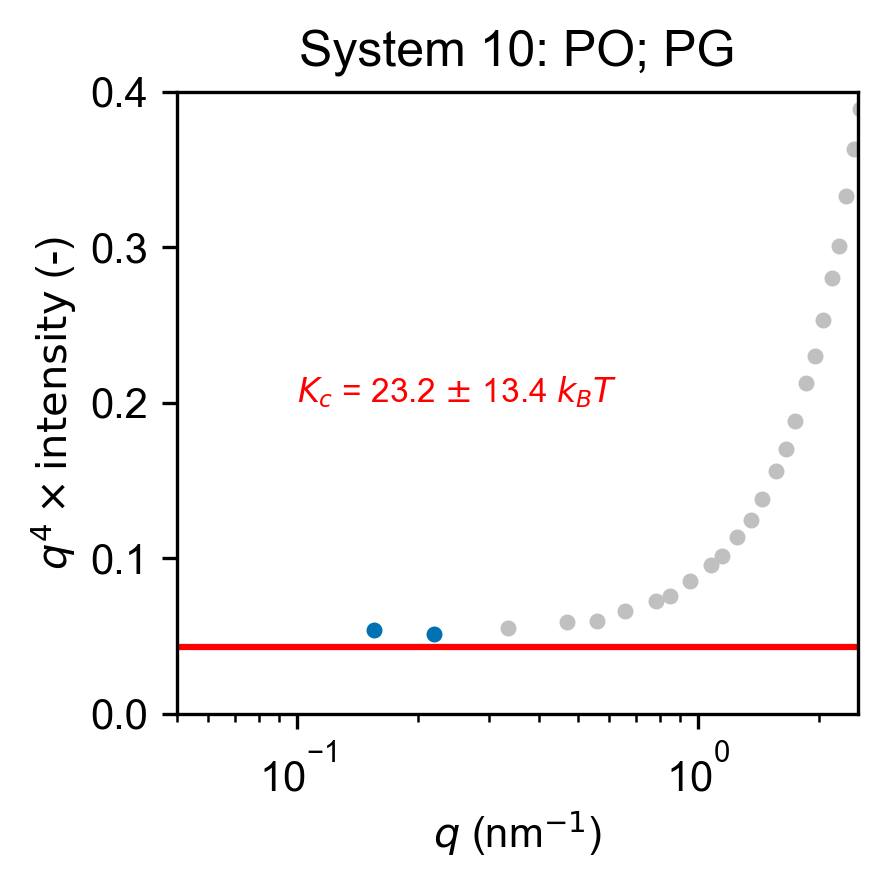

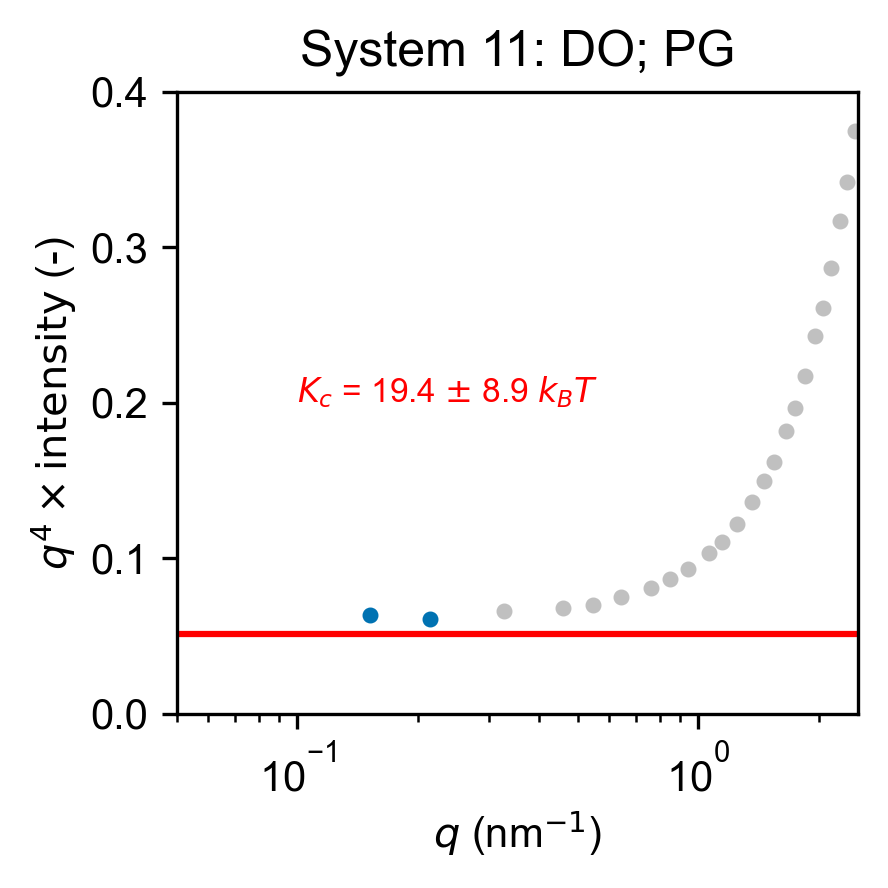

In [13]:
_s = 10  # Min block
cmap = mpl.cm.get_cmap("viridis")

fig_all, ax_all = plt.subplots(1, 1, figsize=(6, 3))
KB_VALUES = {}
for sys in simulations:
    print("Processing system:", sys)
    discard = si_kc_system[sys][0]
    si = si_kc_system[sys][1] * 1e3 / 500  # nanseconds -> picoseconds -> frames

    _, r = np.split(
        mc[sys].results.height_power_spectrum,
        [int(discard / 100 * len(mc[sys].results.height_power_spectrum))],
    )

    m = SI_kc[sys][(discard, "mean")][0]
    sigma = SI_kc[sys][(discard, "sigma")][0]

    KB_VALUES[sys] = m
     
    N = len(r)
    stdev = sigma * np.sqrt(si / N)

    print(m, sigma, N, si, stdev)

    c = cmap(np.linspace(0, 1, len(simulations)))

    height_spectra = radial_averaging(np.mean(r, axis=0), mc[sys])

    mask = height_spectra[:, 0] < kc_low_q
    height_spectra[:, 0] *= 10  # Convert to nm^-1
    height_spectra_cut = height_spectra[mask, :]
    height_spectra_r = height_spectra[~mask, :]

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    ax.scatter(height_spectra_r[:, 0], height_spectra_r[:, 2], color="silver", s=8)
    ax.scatter(height_spectra_cut[:, 0], height_spectra_cut[:, 2], s=8)

    ax.axhline(1 / m, color="r")
    ax.axvline(kc_low_q, color="k", linewidth=0.5, linestyle=":")

    ax.set_xlim(5e-2, 2.5)
    ax.set_ylim(0.0, 0.4)
    ax.set_xscale("log")

    ax.text(
        0.1,
        0.2,
        f"$K_c$ = {m:.1f} $\pm$ {stdev:.1f} $k_BT$",
        color="r",
    )

    ax.set_ylabel(r"$q^4 \times \mathrm{intensity}$ (-)")
    ax.set_xlabel(r"$q$ (nm$^{-1}$)")
    ax.set_title(f"System {sys}: {system_names[sys]}")
    fig.set_tight_layout(True)

    save_fig(fig, f"Figures/{sys}_kc")

    ax_all.scatter(
        height_spectra[:, 0],
        height_spectra[:, 2],
        color=c[sys - 1],
        label=f"System {sys} {system_names[sys]}",
    )

# Shrink current axis by 20%
box = ax_all.get_position()
ax_all.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax_all.legend(loc="center left", bbox_to_anchor=(1, 0.5))

ax_all.set_xlim(5e-2, 2.5)
ax_all.set_ylim(0.0, 0.4)
ax_all.set_xscale("log")
ax_all.set_ylabel(r"$q^4 \times \mathrm{intensity}$ (-)")
ax_all.set_xlabel(r"$q$ (nm$^{-1}$)")
fig_all.set_tight_layout(True)
save_fig(fig_all, "height_spectrum-all")


### Averaged over last 50% without stdev

mean = 0.13320270551641208; K_c = 7.507355020478834
mean = 0.15205193735608935; K_c = 6.576700155145719
mean = 0.13162908533194312; K_c = 7.59710513431126
mean = 0.05713729362297133; K_c = 17.501703993868595
mean = 0.05495554580258455; K_c = 18.196525671717925
mean = 0.05710581991009384; K_c = 17.511350009059992
mean = 0.2152690605912395; K_c = 4.645349393236009
mean = 0.11934897468329908; K_c = 8.378790036978286
mean = 0.20610114743600294; K_c = 4.85198657280893
mean = 0.05323667565585308; K_c = 18.78404291177891
mean = 0.06515494053803916; K_c = 15.348030275864863


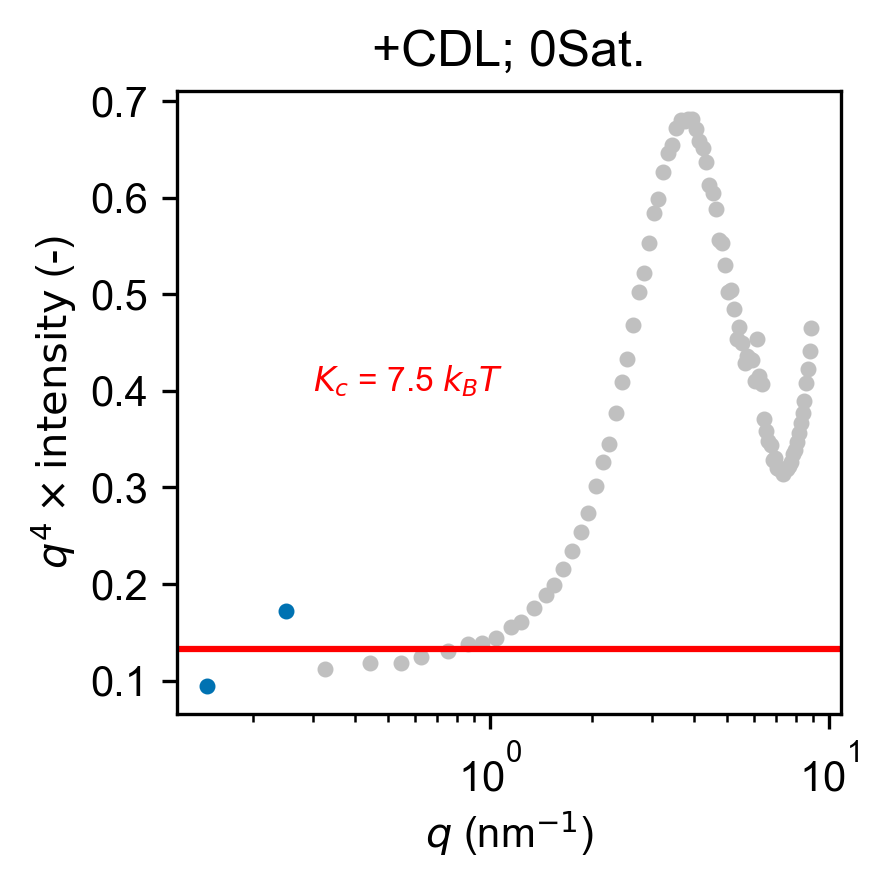

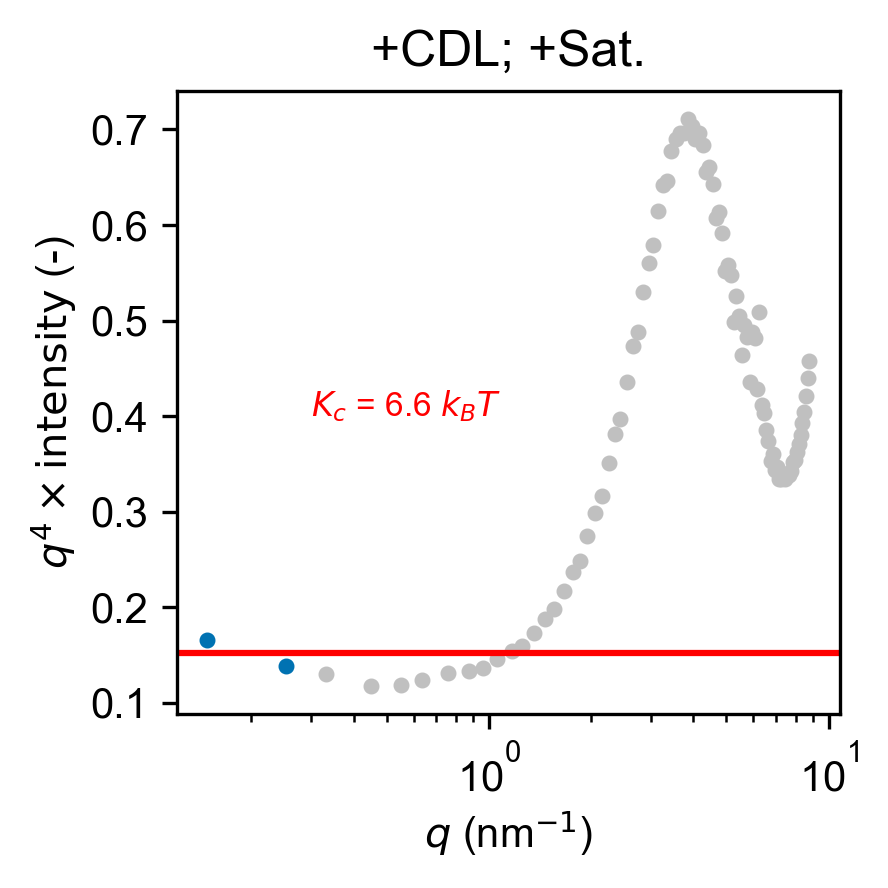

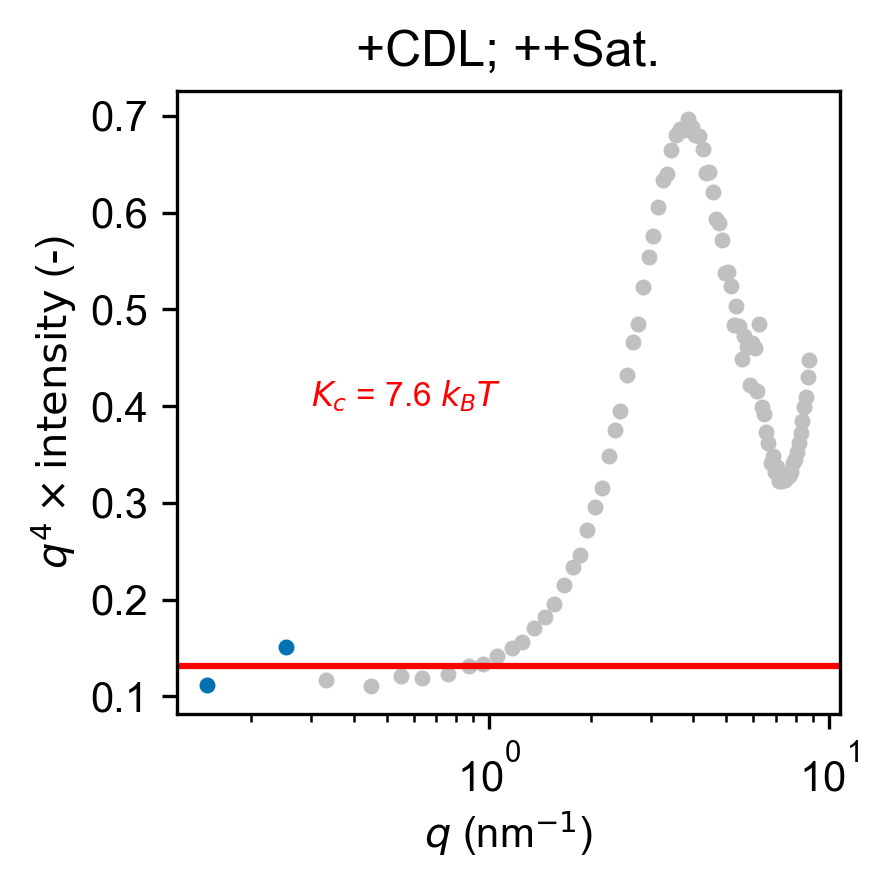

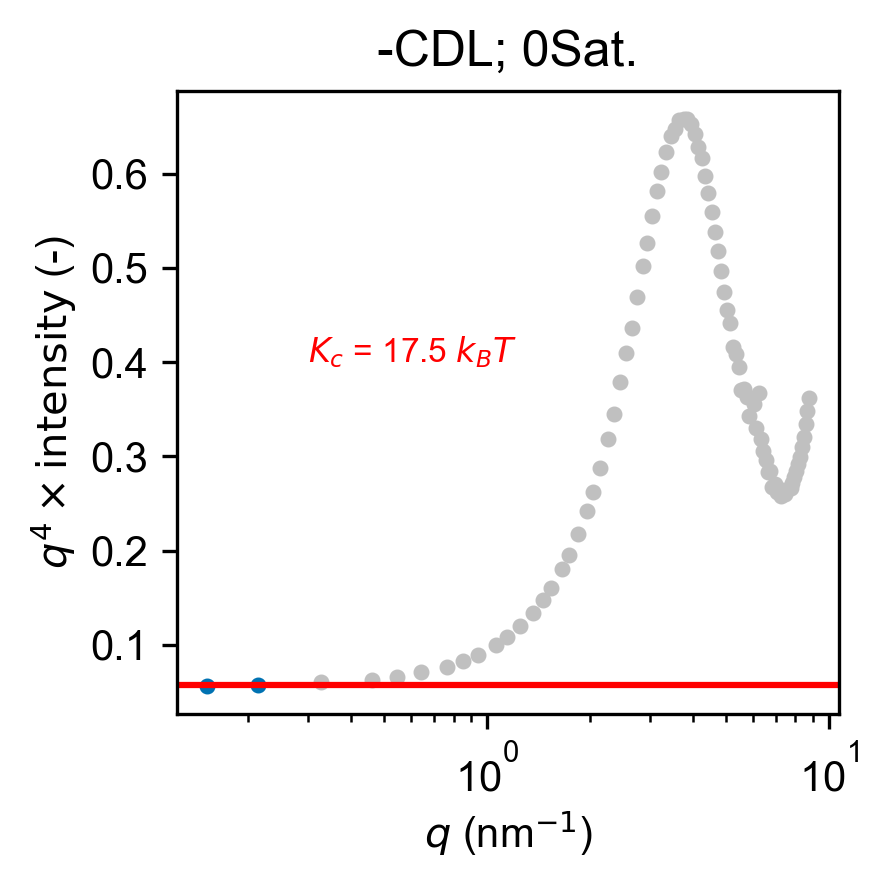

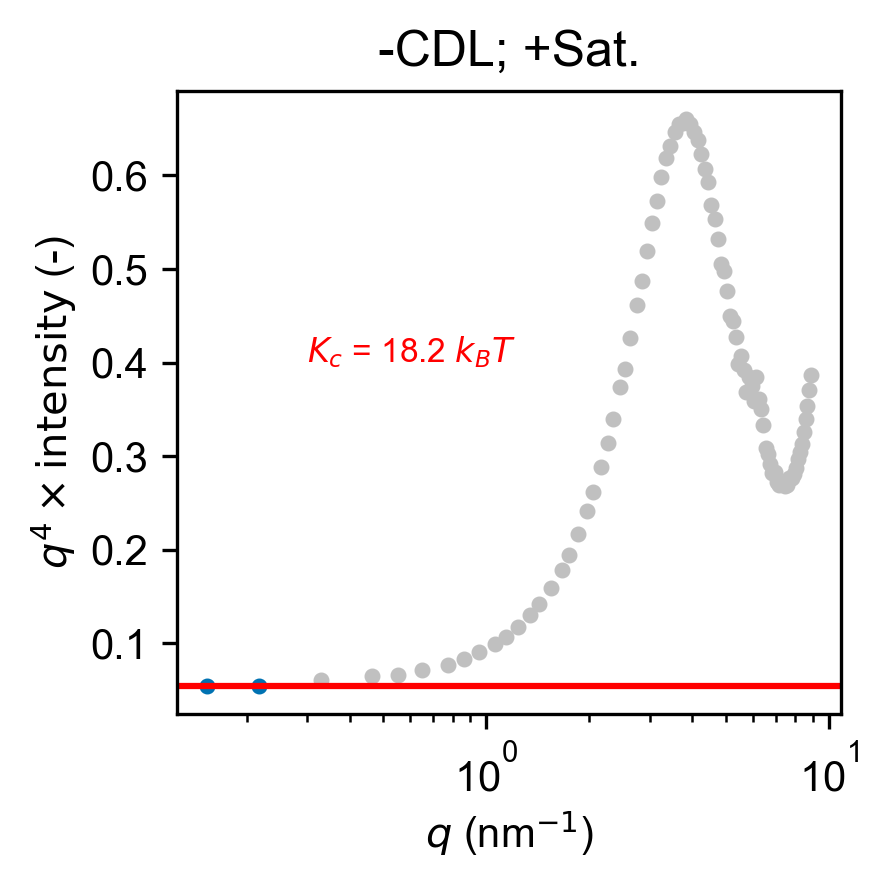

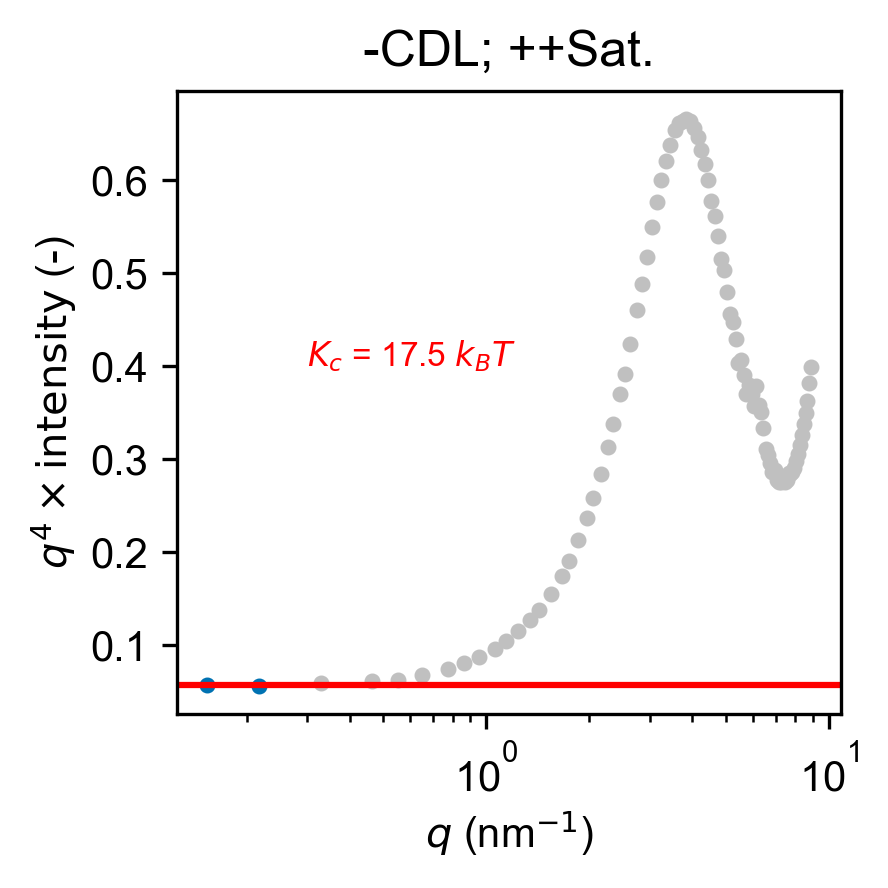

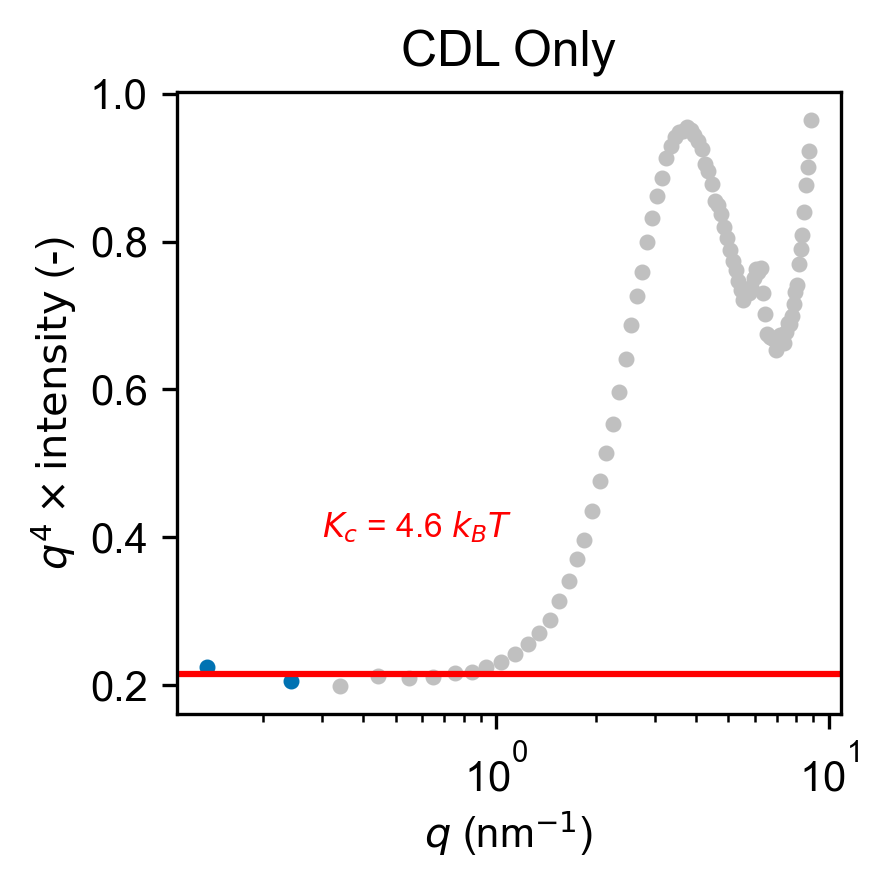

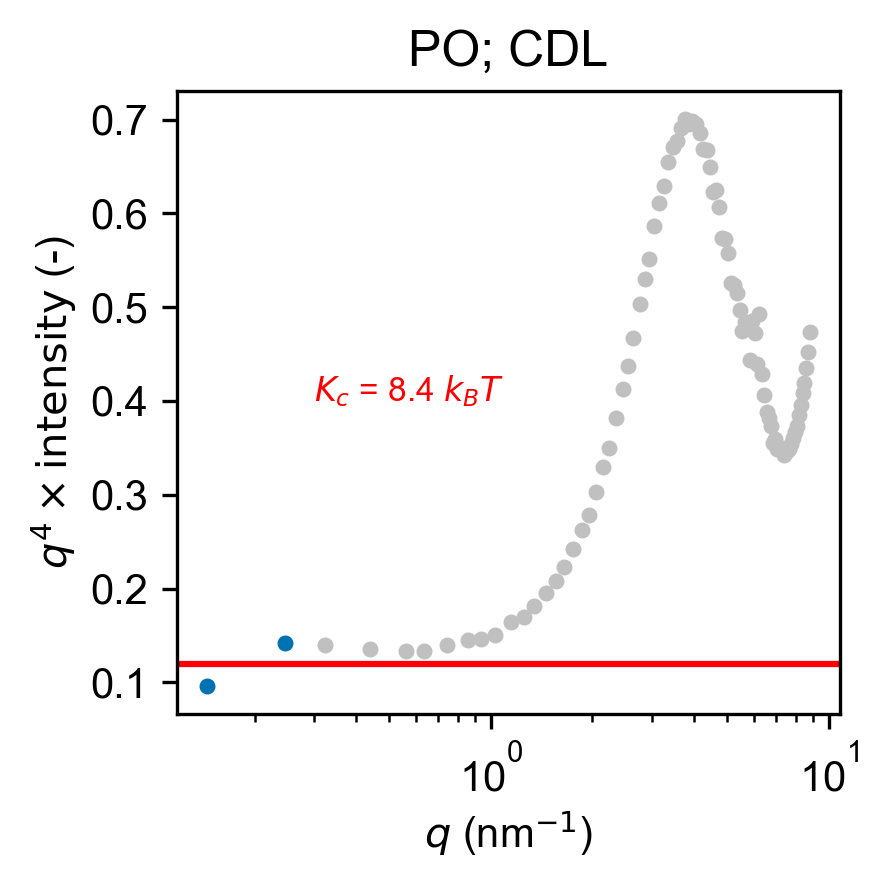

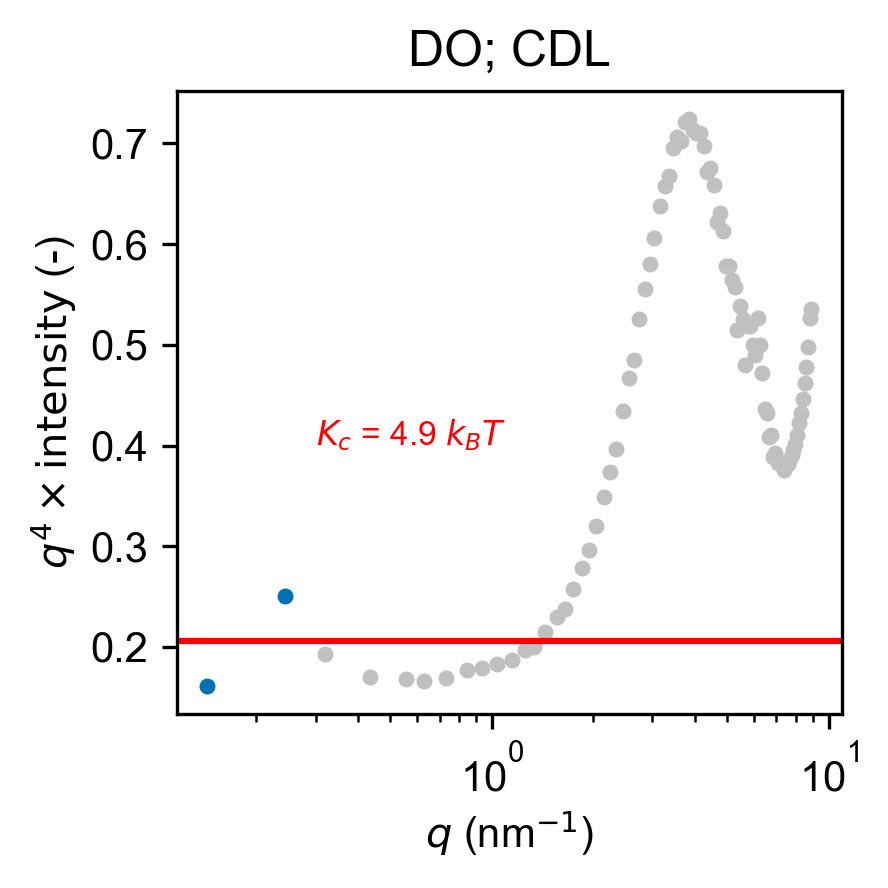

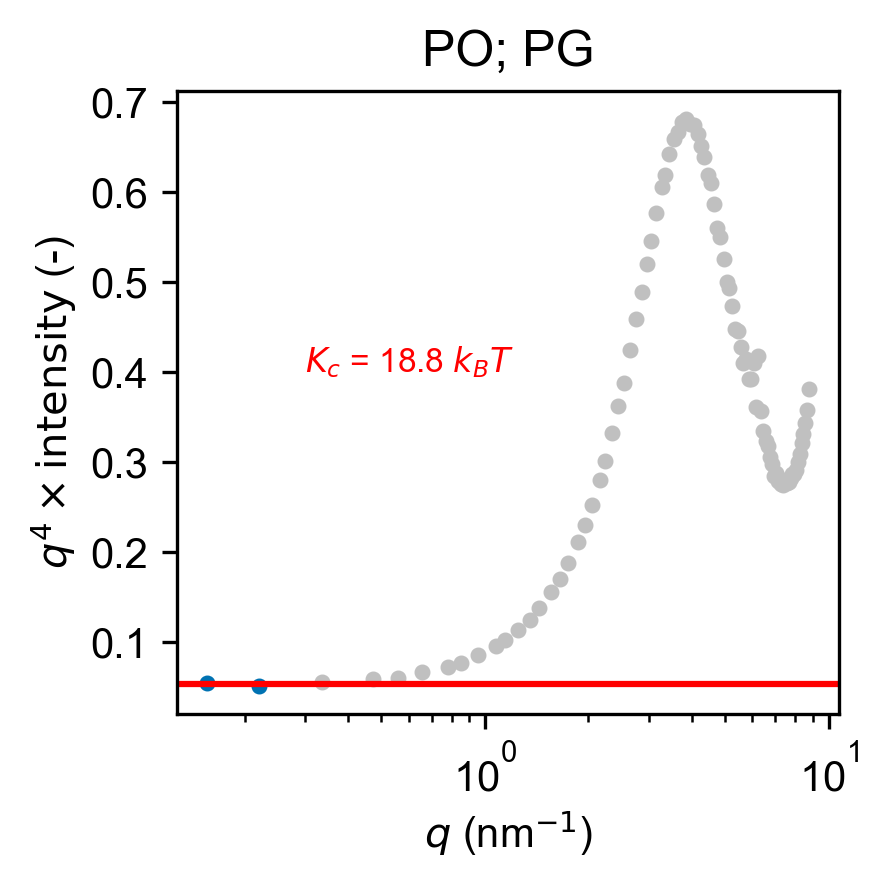

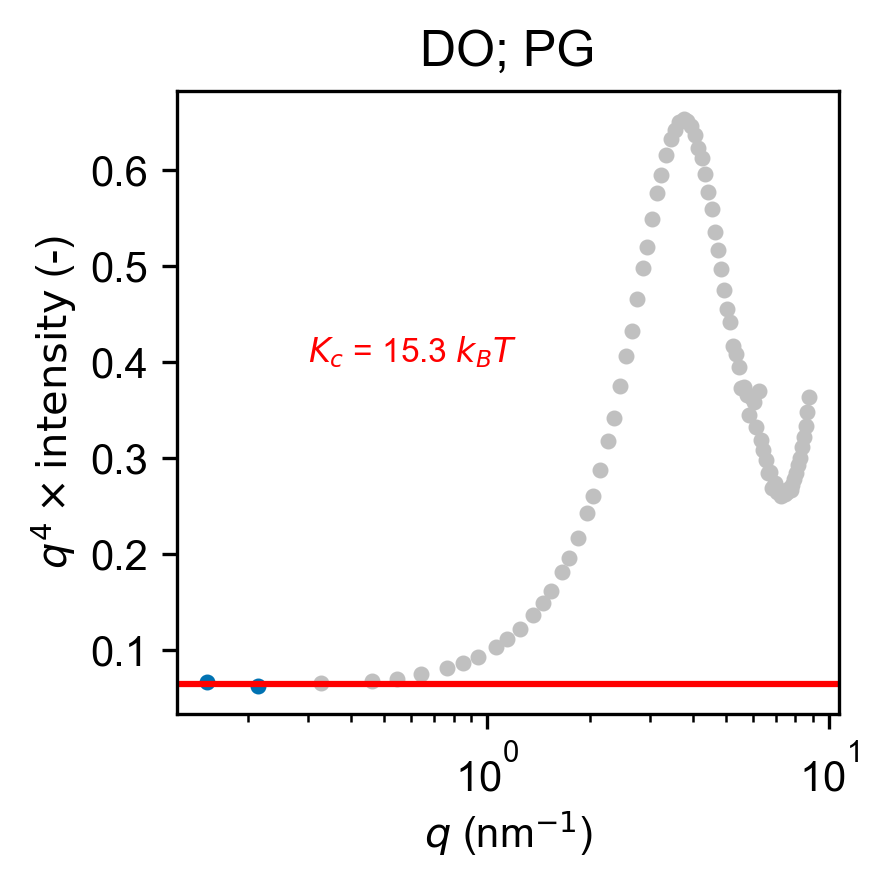

In [14]:
for i in simulations:
    height_spectra = radial_averaging(
        np.mean(mc[i].results.height_power_spectrum, axis=0), mc[i]
    )

    mask = height_spectra[:, 0] < kc_low_q

    height_spectra[:, 0] *= 10  # Convert to nm^-1
    height_spectra_cut = height_spectra[mask, :]
    height_spectra = height_spectra[~mask, :]

    print(
        f"mean = {height_spectra_cut[:, 2].mean()}; K_c = {1.0 / height_spectra_cut[:, 2].mean()}"
    )

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    ax.scatter(height_spectra[:, 0], height_spectra[:, 2], color="silver", s=8)
    ax.scatter(height_spectra_cut[:, 0], height_spectra_cut[:, 2], s=8)
    plt.axhline(height_spectra_cut[:, 2].mean(), color="r")

    # ax.set_xlim(5e-2, 2.5)
    # ax.set_ylim(0.0, 0.4)
    plt.xscale("log")

    plt.text(
        0.3,
        0.4,
        f"$K_c$ = {1.0 / height_spectra_cut[:,2].mean():.1f} $k_BT$",
        color="r",
    )

    ax.set_ylabel(r"$q^4 \times \mathrm{intensity}$ (-)")
    ax.set_xlabel(r"$q$ (nm$^{-1}$)")
    ax.set_title(f"{system_names[i]}")
    plt.tight_layout()


mean = 0.13320270551641208; K_c = 7.507355020478834
mean = 0.15205193735608935; K_c = 6.576700155145719
mean = 0.13162908533194312; K_c = 7.59710513431126
mean = 0.05713729362297133; K_c = 17.501703993868595
mean = 0.05495554580258455; K_c = 18.196525671717925
mean = 0.05710581991009384; K_c = 17.511350009059992
mean = 0.2152690605912395; K_c = 4.645349393236009
mean = 0.11934897468329908; K_c = 8.378790036978286
mean = 0.20610114743600294; K_c = 4.85198657280893
mean = 0.05323667565585308; K_c = 18.78404291177891
mean = 0.06515494053803916; K_c = 15.348030275864863


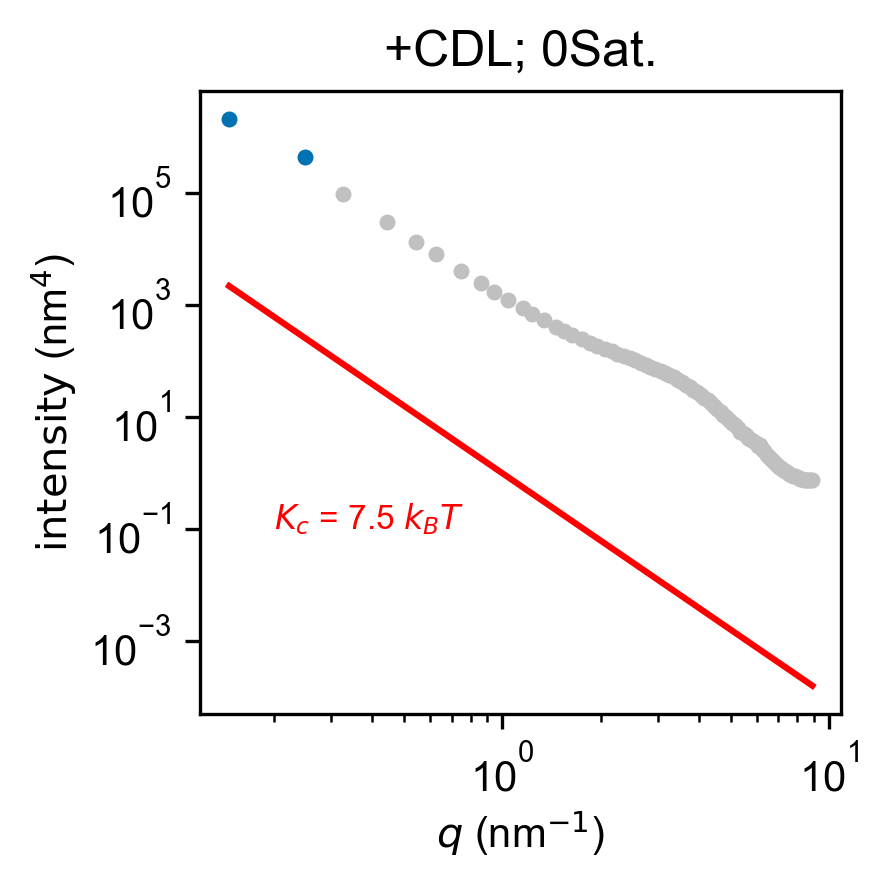

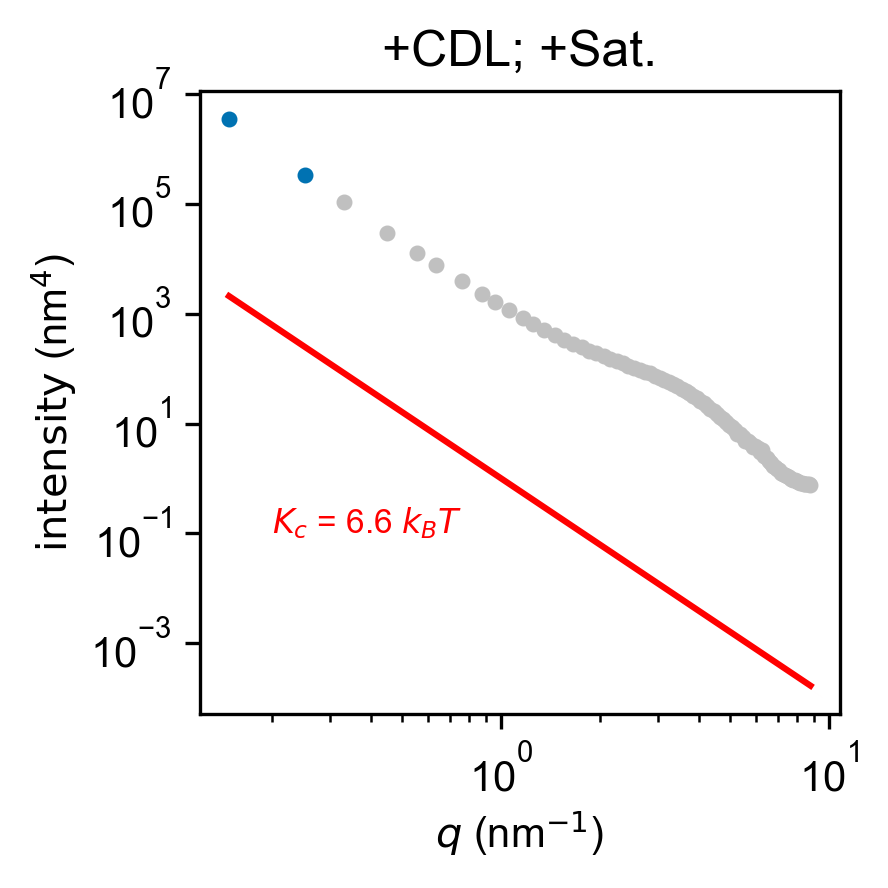

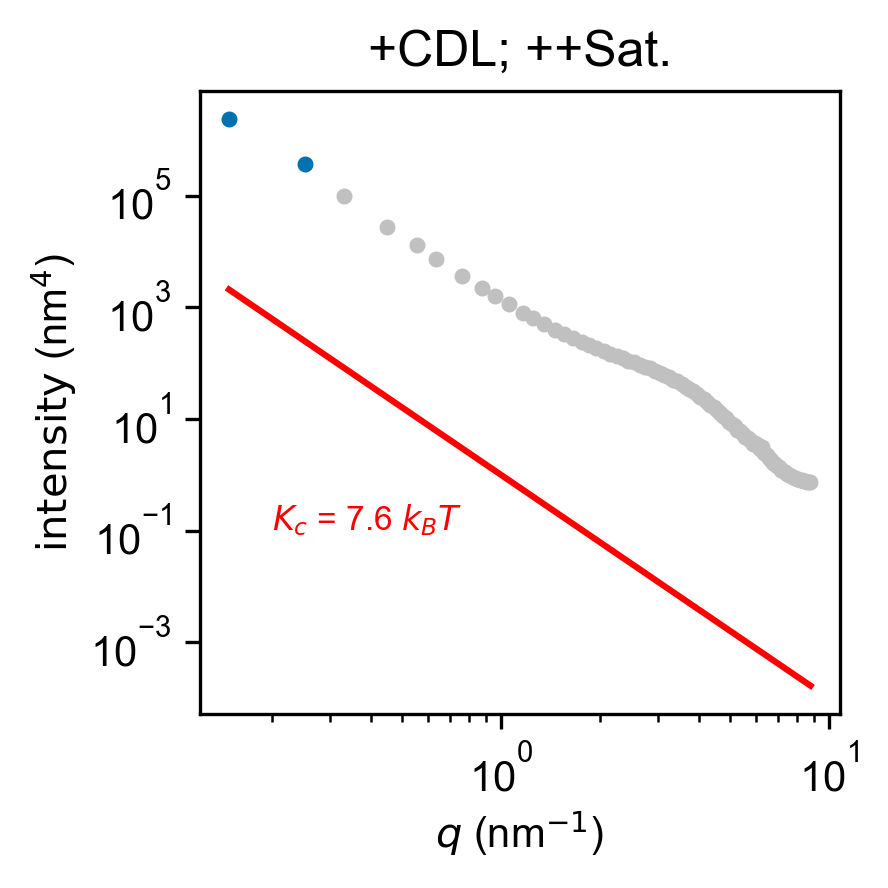

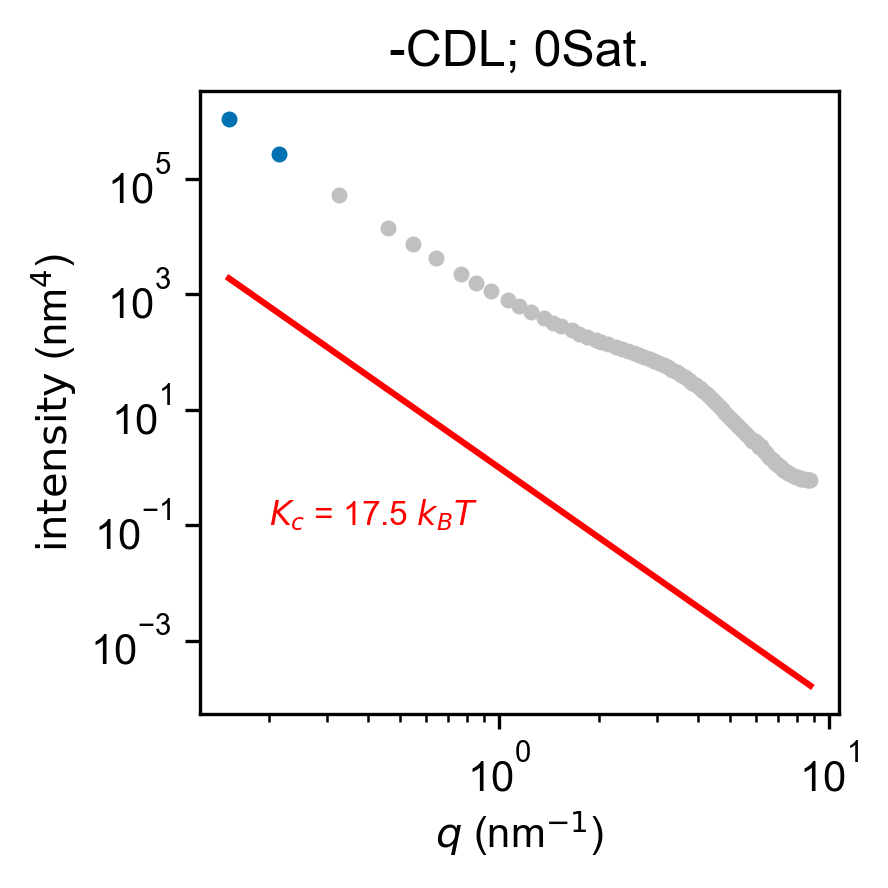

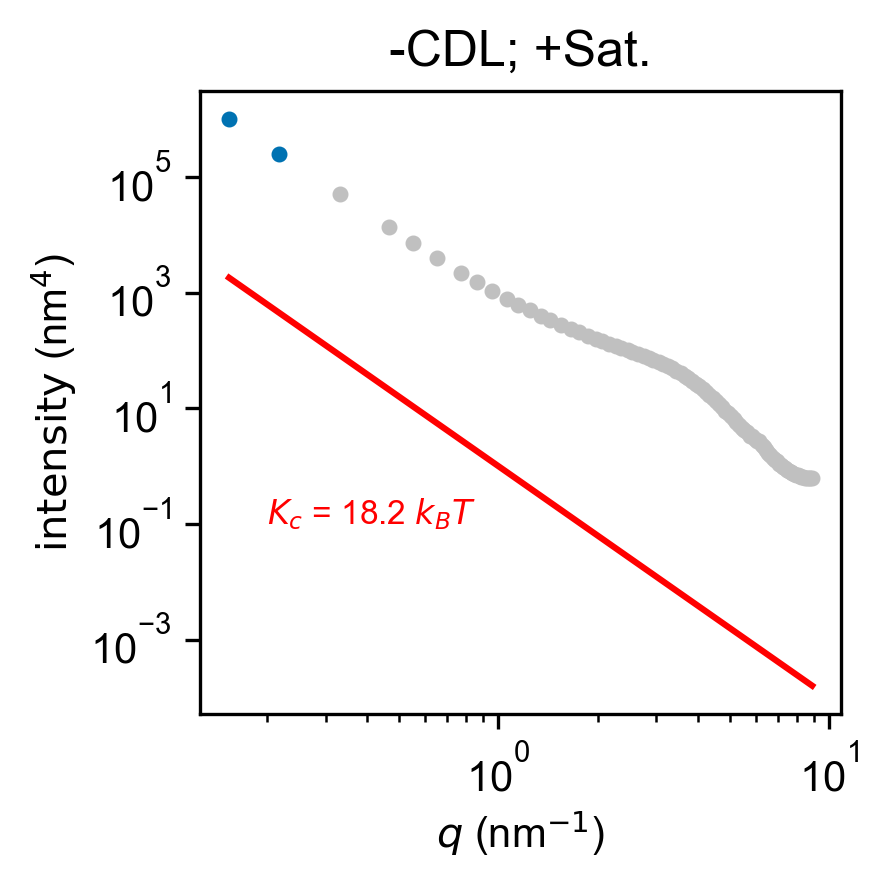

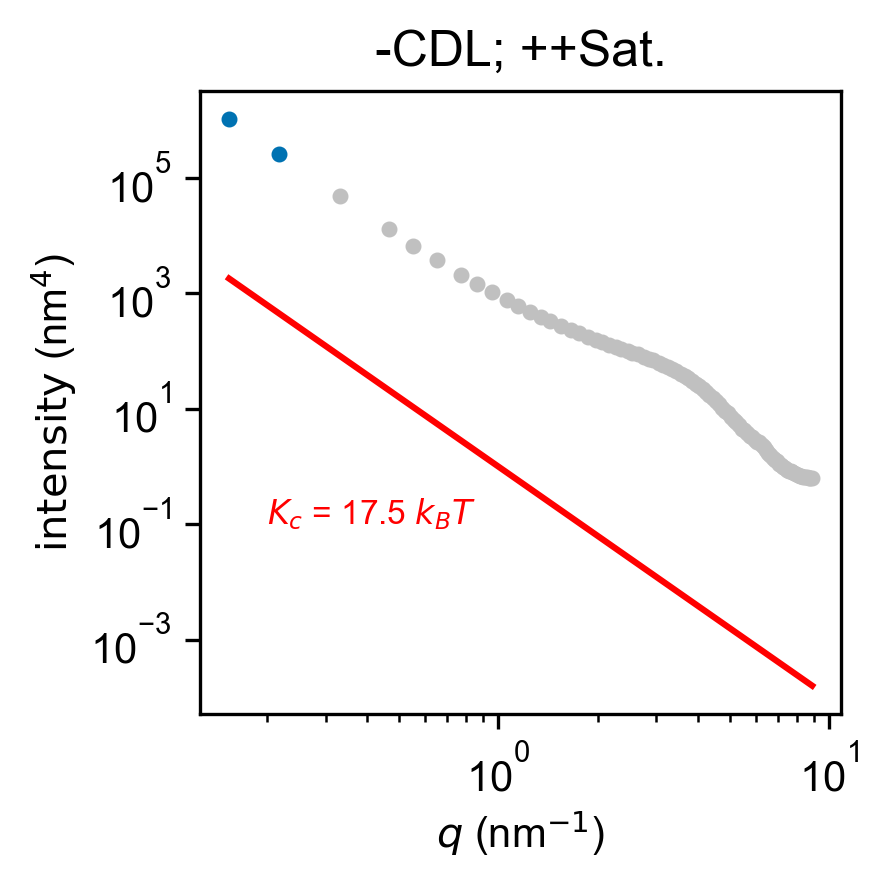

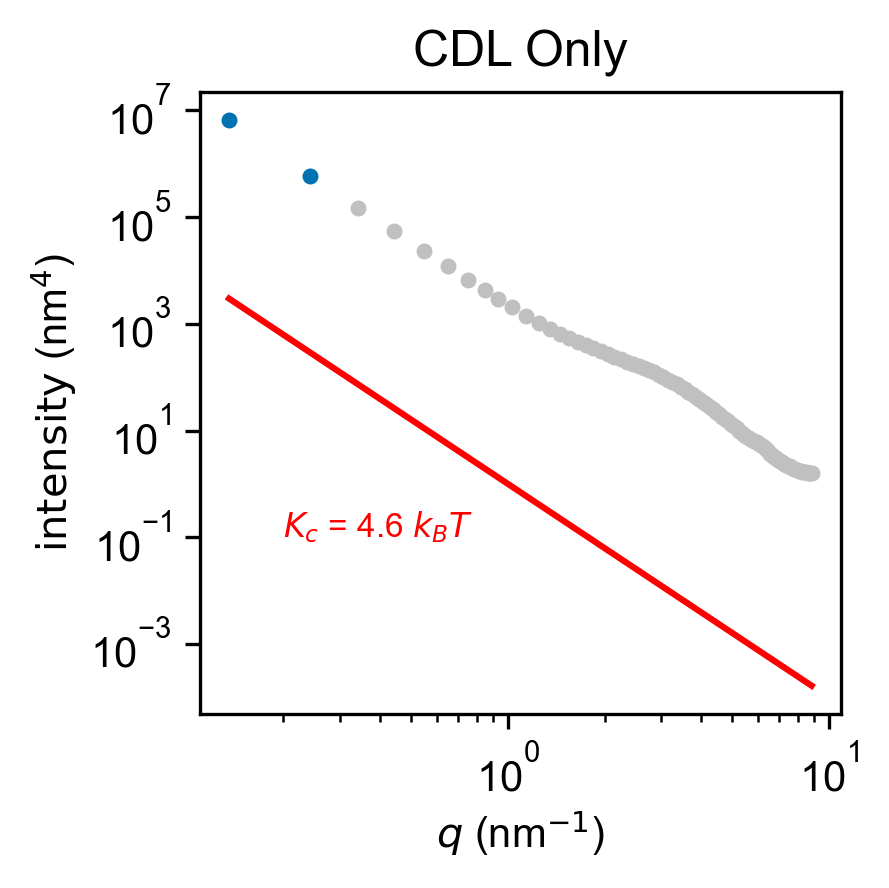

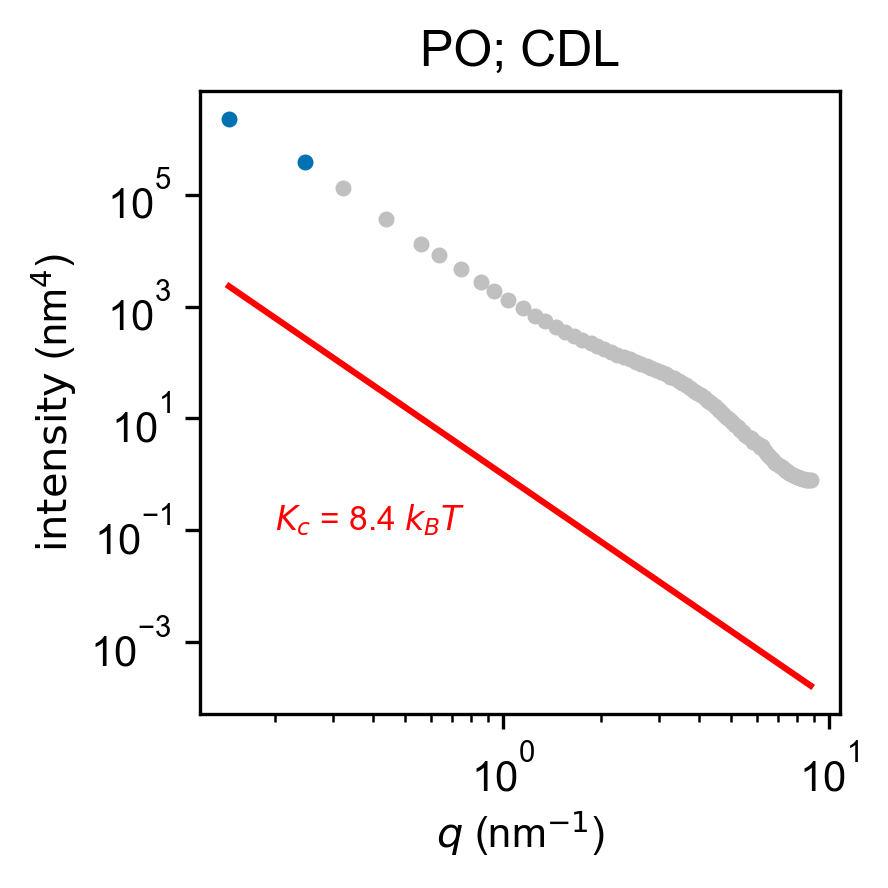

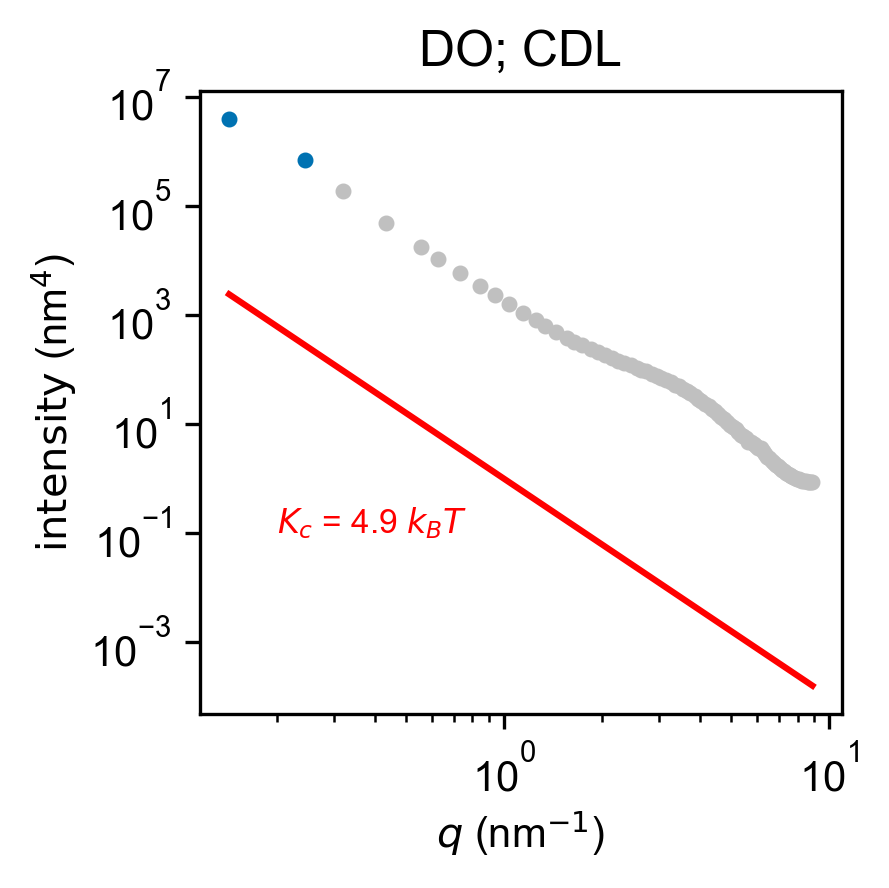

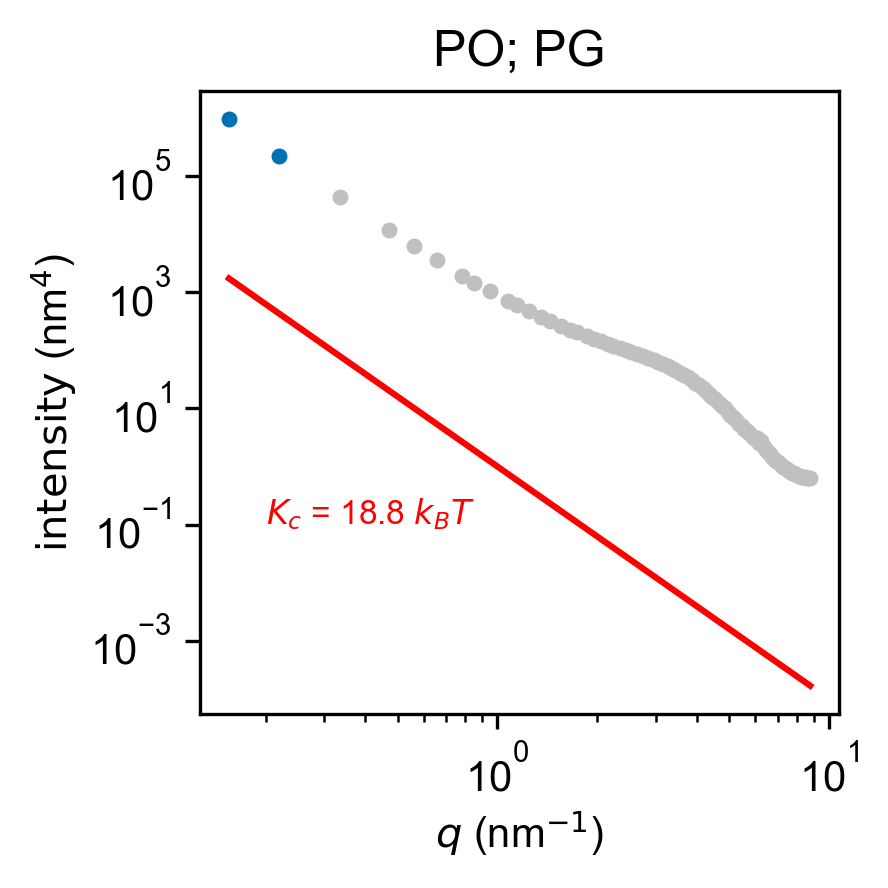

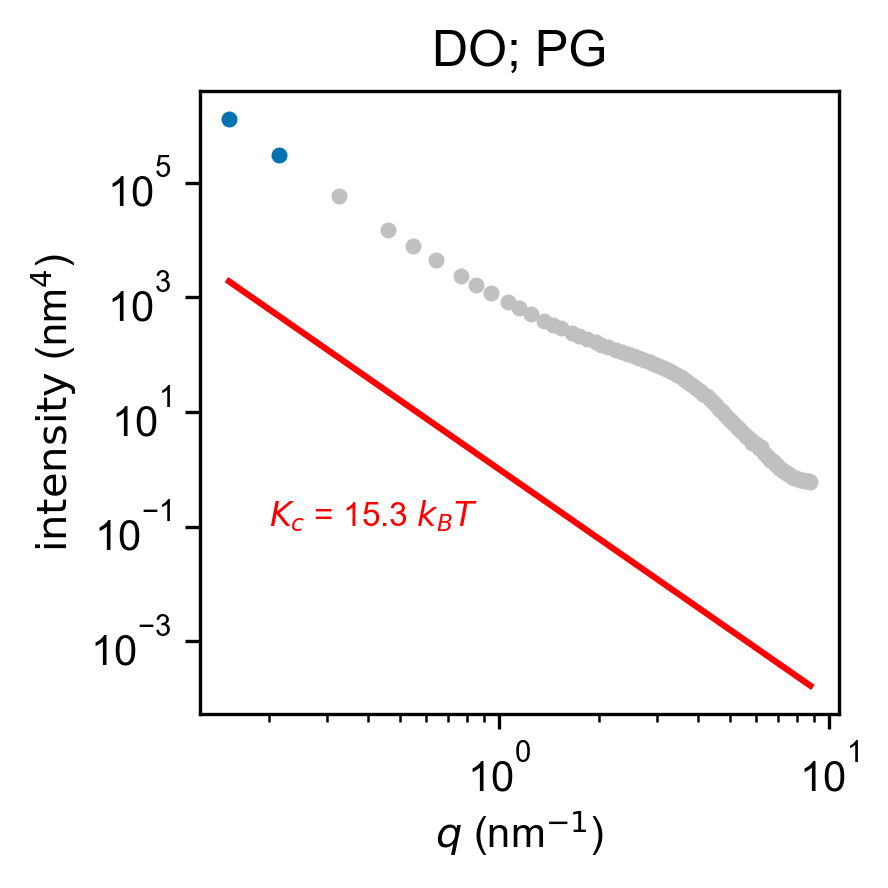

In [15]:
for i in simulations:
    height_spectra = radial_averaging(
        np.mean(mc[i].results.height_power_spectrum, axis=0), mc[i]
    )
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    mask = height_spectra[:, 0] < kc_low_q

    height_spectra[:, 0] *= 10  # Convert to nm^-1
    plt.plot(height_spectra[:, 0], 1 / height_spectra[:, 0] ** 4, "r")

    height_spectra_cut = height_spectra[mask, :]
    height_spectra = height_spectra[~mask, :]

    print(
        f"mean = {height_spectra_cut[:, 2].mean()}; K_c = {1.0 / height_spectra_cut[:, 2].mean()}"
    )

    ax.scatter(height_spectra[:, 0], height_spectra[:, 1], color="silver", s=8)
    ax.scatter(height_spectra_cut[:, 0], height_spectra_cut[:, 1], s=8)

    # ax.set_xlim(5e-2, 2.5)
    # ax.set_ylim(0.0, 0.4)
    plt.xscale("log")
    plt.yscale("log")

    plt.text(
        0.2,
        0.1,
        f"$K_c$ = {1.0 / height_spectra_cut[:,2].mean():.1f} $k_BT$",
        color="r",
    )

    ax.set_ylabel(r"$\mathrm{intensity}$ (nm$^4$)")
    ax.set_xlabel(r"$q$ (nm$^{-1}$)")
    ax.set_title(f"{system_names[i]}")
    plt.tight_layout()


In [16]:
for k, v in areas.items():
    print(k, v / 100)


1 1910.9635508814827
2 1885.213027313361
3 1882.2238539838138
4 1764.7763060940802
5 1737.50087141254
6 1719.3385819237772
7 3226.915367372185
8 1964.7816470061337
9 2010.7153138425294
10 1702.4891397953033
11 1764.7465633487702


# Neighbor analysis

In [17]:
import pandas as pd

pd.options.display.float_format = "{:.3f}".format

# Lipids in order in results matrix
lipids = ["POPC", "DOPC", "POPE", "DOPE", "CDL1", "POPG", "DOPG"]
lipid_dict = dict([[j, i] for i, j in enumerate(lipids)])
leaflets = ["upper", "lower"]

def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

def print_neighbor_analysis(dataset):
    for sim in simulations:
        print(f"System {sim}: {system_names[sim]}")

        raw_baseline = []
        baseline = []
        s = ""
        for lipid in lipids:
            if lipid in compositions[sim, "raw_composition"]:
                # div by 2 to account for leaflet composition
                raw_baseline.append(compositions[sim, "raw_composition"][lipid] / 2)
            else:
                raw_baseline.append(0)
            s += f"{lipid}: {compositions[sim, 'normed_composition'][lipid]:0.3f}, "
            baseline.append(compositions[sim, "normed_composition"][lipid])
        raw_baseline = np.array(raw_baseline).reshape(-1,1)
        print(s)
        baseline = np.array(baseline)


        # Aggregate statistics from both leaflets
        counts_per_frame = dataset[sim]["upper"] + dataset[sim]["lower"]
        # Keep only back half of trajectory
        N = int(0.5 * len(counts_per_frame))
        counts = np.mean(
            counts_per_frame[N : -1], axis=0
        ) # mean counts per frame

        for i in range(0, len(lipids)):
            for j in range(0, len(lipids)):
                if i > j:
                    counts[i, j] = counts[j, i]

        # Normalize by number of each lipid within leaflet
        normed_counts = np.divide(
             counts, raw_baseline, out=np.zeros_like(counts), where=raw_baseline != 0
        ) 
        print("# of each lipid around row lipid\n", pd.DataFrame(normed_counts, columns=lipids, index=lipids))

        rowwise_sum = np.sum(normed_counts, axis=1).reshape(-1, 1)
        # print(np.array2string(rowwise_sum, max_line_width=np.inf)) 

        likelihood_count = np.divide(
             normed_counts, rowwise_sum, out=np.zeros_like(counts), where=rowwise_sum != 0
        )

        # print(np.array2string(likelihood_count, max_line_width=np.inf)) 



        diff_counts = np.divide(
            likelihood_count,
            baseline,
            out=np.zeros_like(normed_counts),
            where=baseline != 0,
        )
        # df = pd.DataFrame(normed_counts, columns=lipids, index=lipids)
        # print(df)

        # print("DIFF:")
        print("Enrichment from likelihood:\n", pd.DataFrame(diff_counts, columns=lipids, index=lipids))
        print()


In [18]:
neighbor_enrichment = {}

for i in simulations:
    with open(
        util.analysis_path / f"{i}/neighbor_enrichment_leaflet_glo.pickle", "rb"
    ) as handle:
        neighbor_enrichment[i] = pickle.load(handle)


In [19]:
print_neighbor_analysis(neighbor_enrichment)

System 1: +CDL; 0Sat.
POPC: 0.120, DOPC: 0.460, POPE: 0.030, DOPE: 0.270, CDL1: 0.120, POPG: 0.000, DOPG: 0.000, 
# of each lipid around row lipid
       POPC   DOPC  POPE   DOPE  CDL1  POPG  DOPG
POPC 2.026 15.775 1.029  9.433 4.073 0.000 0.000
DOPC 4.112  7.865 1.053  9.371 3.933 0.000 0.000
POPE 4.115 16.153 0.549  9.680 4.416 0.000 0.000
DOPE 4.187 15.956 1.074  4.804 4.477 0.000 0.000
CDL1 4.073 15.087 1.104 10.086 2.053 0.000 0.000
POPG 0.000  0.000 0.000  0.000 0.000 0.000 0.000
DOPG 0.000  0.000 0.000  0.000 0.000 0.000 0.000
Enrichment from likelihood:
       POPC  DOPC  POPE  DOPE  CDL1  POPG  DOPG
POPC 0.523 1.060 1.061 1.080 1.051 0.000 0.000
DOPC 1.302 0.649 1.333 1.317 1.245 0.000 0.000
POPE 0.983 1.006 0.524 1.026 1.055 0.000 0.000
DOPE 1.145 1.137 1.175 0.583 1.224 0.000 0.000
CDL1 1.048 1.012 1.137 1.152 0.528 0.000 0.000
POPG 0.000 0.000 0.000 0.000 0.000 0.000 0.000
DOPG 0.000 0.000 0.000 0.000 0.000 0.000 0.000

System 2: +CDL; +Sat.
POPC: 0.260, DOPC: 0.250, POPE: 

In [21]:
voronoi = {}

for i in simulations:
    with open(util.analysis_path / f"{i}/voronoi_leaflet_glo.pickle", "rb") as handle:
        voronoi[i] = pickle.load(handle)


In [22]:
print_neighbor_analysis(voronoi)

System 1: +CDL; 0Sat.
POPC: 0.120, DOPC: 0.460, POPE: 0.030, DOPE: 0.270, CDL1: 0.120, POPG: 0.000, DOPG: 0.000, 
# of each lipid around row lipid
       POPC  DOPC  POPE  DOPE  CDL1  POPG  DOPG
POPC 0.712 5.584 0.345 3.186 1.444 0.000 0.000
DOPC 1.455 2.805 0.355 3.181 1.398 0.000 0.000
POPE 1.378 5.451 0.178 3.116 1.525 0.000 0.000
DOPE 1.414 5.417 0.346 1.553 1.542 0.000 0.000
CDL1 1.444 5.363 0.381 3.473 0.751 0.000 0.000
POPG 0.000 0.000 0.000 0.000 0.000 0.000 0.000
DOPG 0.000 0.000 0.000 0.000 0.000 0.000 0.000
Enrichment from likelihood:
       POPC  DOPC  POPE  DOPE  CDL1  POPG  DOPG
POPC 0.527 1.077 1.020 1.046 1.069 0.000 0.000
DOPC 1.320 0.663 1.289 1.281 1.268 0.000 0.000
POPE 0.987 1.017 0.510 0.990 1.092 0.000 0.000
DOPE 1.148 1.146 1.123 0.560 1.252 0.000 0.000
CDL1 1.055 1.021 1.114 1.127 0.549 0.000 0.000
POPG 0.000 0.000 0.000 0.000 0.000 0.000 0.000
DOPG 0.000 0.000 0.000 0.000 0.000 0.000 0.000

System 2: +CDL; +Sat.
POPC: 0.260, DOPC: 0.250, POPE: 0.080, DOPE: 0.2

# Lateral Pressures

In [23]:
def first_cubic(data, minz=None, maxz=None, maxiter=5000):
    """
    Compute the first moment using a cubic piecewise interpolant and Gaussian quadrature
    """
    x = data["z"]  # in nanometers
    # p = data['LP_(kPA)']/1e15 #to convert to newtons / nm^2
    p = data["LP_(kPA)"] / 1e3  # to convert to piconewtons / nm^2
    y = p * x

    if minz is None:
        minz = min(x)
    if maxz is None:
        maxz = max(x)

    approx = interpolate.interp1d(x, y, kind="cubic")  # interpolating a function
    intg = integrate.quadrature(
        approx, minz, maxz, maxiter=maxiter
    )  # finding the integral over bounds
    return intg


def zero_cubic(data, minz=None, maxz=None, maxiter=5000):
    """
    Compute the zeroeth moment using a cubic piecewise interpolant and Gaussian quadrature
    """
    x = data["z"]  # in nanometers
    # p = data['LP_(kPA)']/1e15 # to convert to newtons / nm^2
    y = data["LP_(kPA)"] / 1e3  # to convert to piconewtons / nm^2
    if minz is None:
        minz = min(x)
    if maxz is None:
        maxz = max(x)

    approx = interpolate.interp1d(x, y, kind="cubic")  # interpolating a function
    intg = integrate.quadrature(
        approx, minz, maxz, maxiter=maxiter
    )  # finding the integral over bounds
    return intg


# def zero_cubic_newton(data):
#     x = data["z"]  # in nanometers
#     y = data["LP_(kPA)"] / 1e15  # to convert to newtons / nm^2
#     approx = interpolate.interp1d(x, y, kind="cubic")  # interpolating a function
#     intg = integrate.quadrature(
#         approx, min(x), max(x), maxiter=1000
#     )  # finding the integral over bounds
#     # intg = integrate.quadrature(approx,-3.5,3.5, maxiter = 1000) #finding the integral over bounds
#     return intg


def mean_squared_deviation(data: pd.DataFrame, var: str = "Szz") -> float:
    """
    Compute the mean squared deviation of the data
    """
    return sum(data[var] ** 2) / (data[var].size - 1)


def max_difference(a: npt.ArrayLike, b: npt.ArrayLike):
    """
    Get the max difference between two equal sized arrays
    """
    if a.size != b.size:
        raise RuntimeError("a and b must be same sized arrays")
    diff = np.abs(a - b)
    return np.amax(diff)


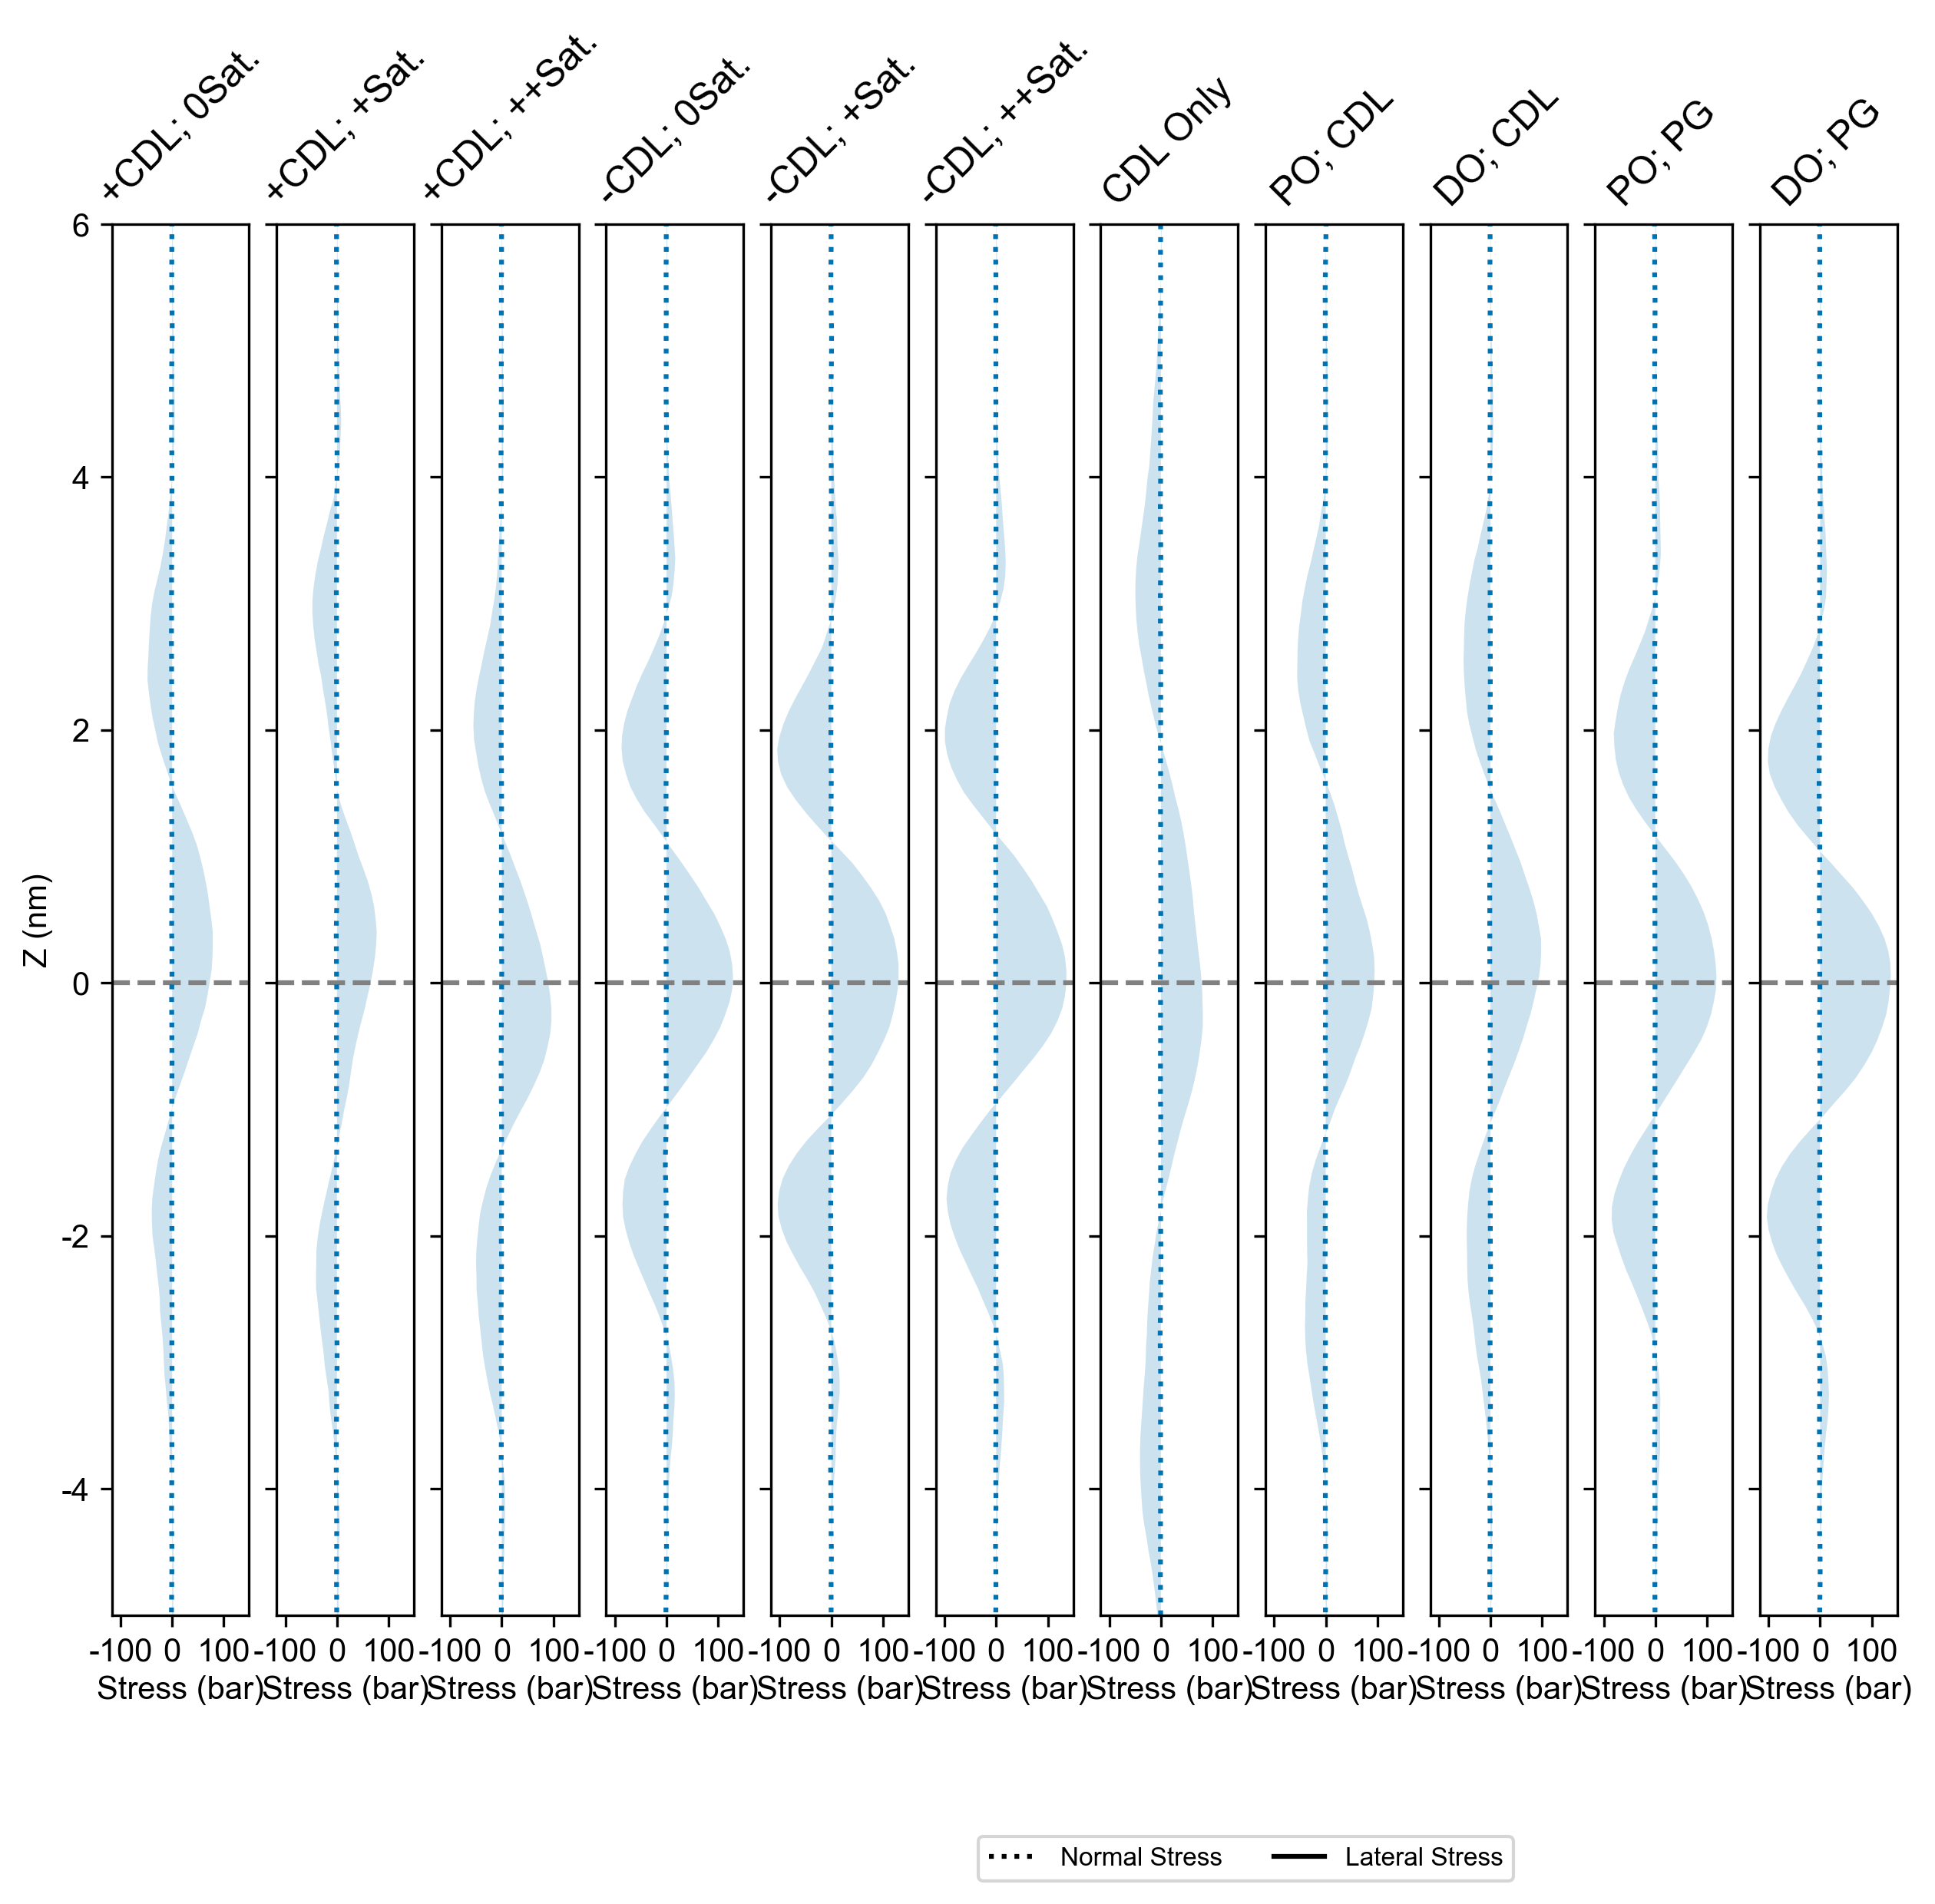

In [24]:
fig, ax = plt.subplots(1, 11, figsize=(10, 8), sharex=True, sharey=True)
for sim in simulations:
    ax[sim - 1].axhline(0, linestyle="--", color="gray")

    df0 = pd.read_csv(util.analysis_path / f"{sim}/stress_calc/lateral_pressure.csv")

    Szz = df0["Szz"] * 0.01
    ax[sim - 1].plot(Szz, df0["z"], label="Normal Stress", linestyle=":")

    lateral = -0.5 * (df0["Sxx"] + df0["Syy"]) * 0.01  # transforming into bars
    ax[sim - 1].fill_betweenx(df0["z"], lateral, 0, label="Lateral Stress", alpha=0.2)

    # ax[x,y].set_xlim(-25000, 15000)
    ax[sim - 1].set_ylim(-5, 6)
    # ax[x,y].ticklabel_format(axis = 'x', style = 'sci', scilimits = (0,0))
    ax[sim - 1].set_xlabel("Stress (bar)")
    ax[sim - 1].set_title(f"{system_names[sim]}", rotation=45)
    if sim - 1 == 0:
        ax[sim - 1].set_ylabel("Z (nm)")

handles = [
    mlines.Line2D([], [], color="black", linestyle=":", label="Normal Stress"),
    mlines.Line2D(
        [],
        [],
        color="black",
        linestyle="-",
        label="Lateral Stress",
    ),
]

plt.legend(handles=handles, bbox_to_anchor=(-2.5, -0.95, 0.8, 0.8), ncol=2)
# plt.tight_layout()
save_fig(fig, f"Figures/lateral_pressures")


In [39]:
f_cubic_dat = {}
z_cubic_dat = {}
msd_dat = {}

for sim in simulations:
    file = util.analysis_path / f"{sim}/stress_calc/lateral_pressure.csv"

    try:
        data = pd.read_csv(file)

        fcd = first_cubic(data)
        f_cubic_dat[sim] = (first_cubic(data, minz=0)[0] - first_cubic(data, maxz=0)[0])/2

        print(first_cubic(data, minz=0)[0], first_cubic(data, maxz=0)[0])
        
        
        zcd = zero_cubic(data)
        z_cubic_dat[sim] = zero_cubic(data)[0]

        msd = mean_squared_deviation(data, "Szz")
        msd_dat[sim] = msd
        print(
            f"{system_names[sim]}\n" f"   Zero Moment (pN/nm): {zcd}\n",
            f"     First Moment (pN): {fcd}\n",
            f"           MSD (kPa^2): {msd}\n",
            f" Upper Leaflet Tension: {zero_cubic(data, minz=0)}\n",
            f" Lower Leaflet Tension: {zero_cubic(data, maxz=0)}\n",
        )
    except Exception as e:
        print(
            f"{system_names[sim]}\n" f"{e}\n",
            )
np.save("f_cubic_dat.npy", f_cubic_dat)
np.save("z_cubic_dat.npy", z_cubic_dat)
np.save("msd_dat.npy", msd_dat)

-10.827201586520752 12.372879804679622
+CDL; 0Sat.
   Zero Moment (pN/nm): (-0.09418193289123017, 2.733904200247217e-09)
      First Moment (pN): (1.5456513803962084, 2.0842572112655944e-09)
            MSD (kPa^2): 7521.134678627835
  Upper Leaflet Tension: (2.1917759294025405, 2.249679509347402e-08)
  Lower Leaflet Tension: (-2.2859804593614466, 1.8321362205142577e-08)

-11.488826597602847 11.471555740877331
+CDL; +Sat.
   Zero Moment (pN/nm): (0.03144049115951618, 1.1455127790771513e-08)
      First Moment (pN): (-0.0172977470995524, 9.252670921111594e-10)
            MSD (kPa^2): 6155.636807794267
  Upper Leaflet Tension: (1.8159373755459614, 1.131807758625314e-09)
  Lower Leaflet Tension: (-1.7844886513484257, 1.5600788660918852e-08)

-12.476708229984022 12.479246809716098
+CDL; ++Sat.
   Zero Moment (pN/nm): (0.08684665367882151, 9.7835235052246e-09)
      First Moment (pN): (0.0025376469435145037, 1.2711247904945155e-08)
            MSD (kPa^2): 6634.200150877637
  Upper Leaflet

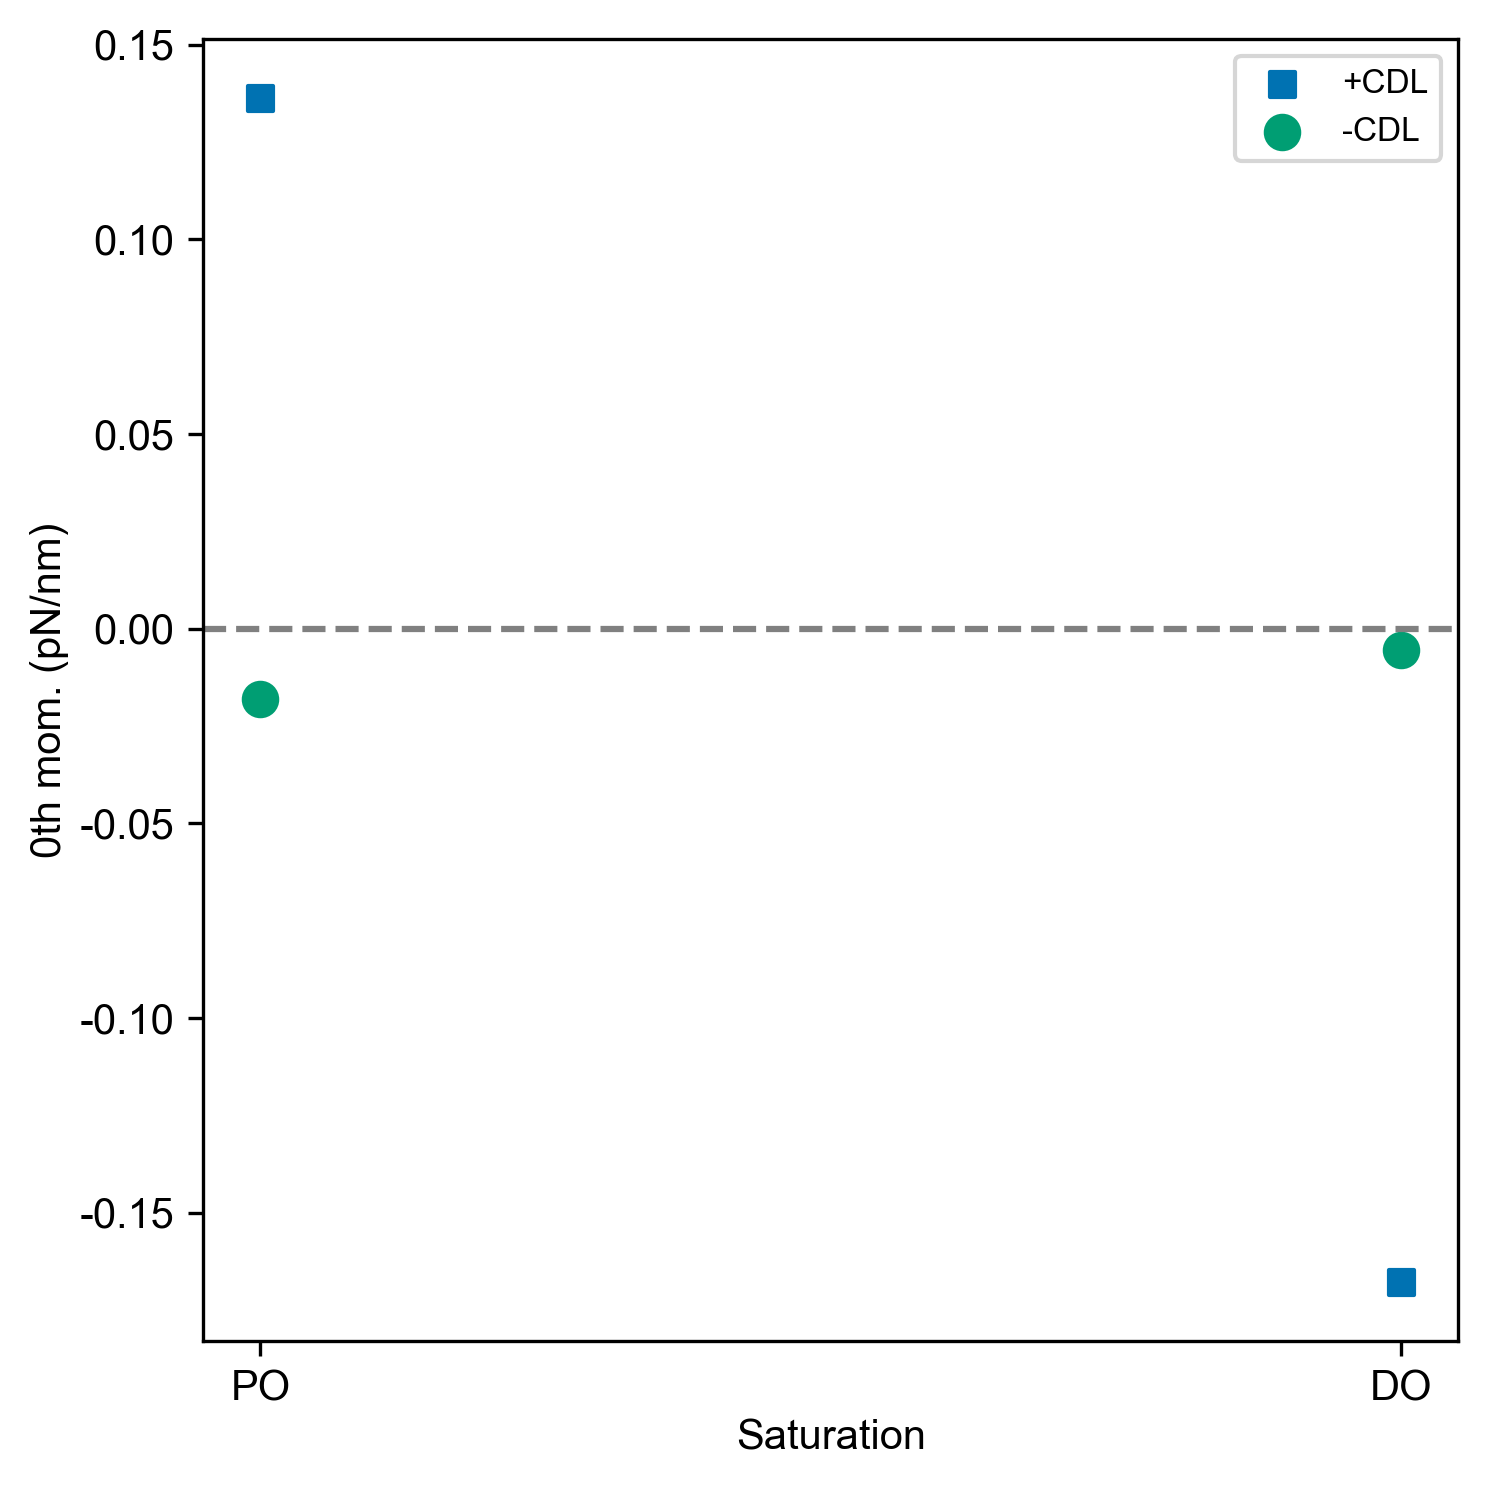

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.axhline(0, color="gray", linestyle="--")

ax.scatter(
    np.arange(0,2),
    [z_cubic_dat[k] for k in [8, 9]],
    label="+CDL",
    marker="s",
    s=6**2,
)
ax.scatter(
    np.arange(0,2),
    [z_cubic_dat[k] for k in [10, 11]],
    label="-CDL",
    s=8**2,
)

# ax.set_ylim(-2, 4)
ax.set_ylabel("0th mom. (pN/nm)")
# ax.tick_params(axis = 'y', labelcolor = 'darkorange')
# ax.set_xlim(0, 25)
ax.set_xticks([0,1], labels = ["PO", "DO"])
# plt.xscale('log')
ax.set_xlabel("Saturation")

plt.legend()
plt.tight_layout()
save_fig(fig, "Figures/zero_moment")

In [35]:
print(f_cubic_dat)

{1: 12.372879804679622, 2: 11.471555740877331, 3: 12.479246809716098, 4: 9.963157547921686, 5: 10.811998451146565, 6: 11.830312477634825, 7: 24.7449531771647, 8: 15.13115112323949, 9: 14.68459398457357, 10: 10.565845657847468, 11: 11.322294246401109}


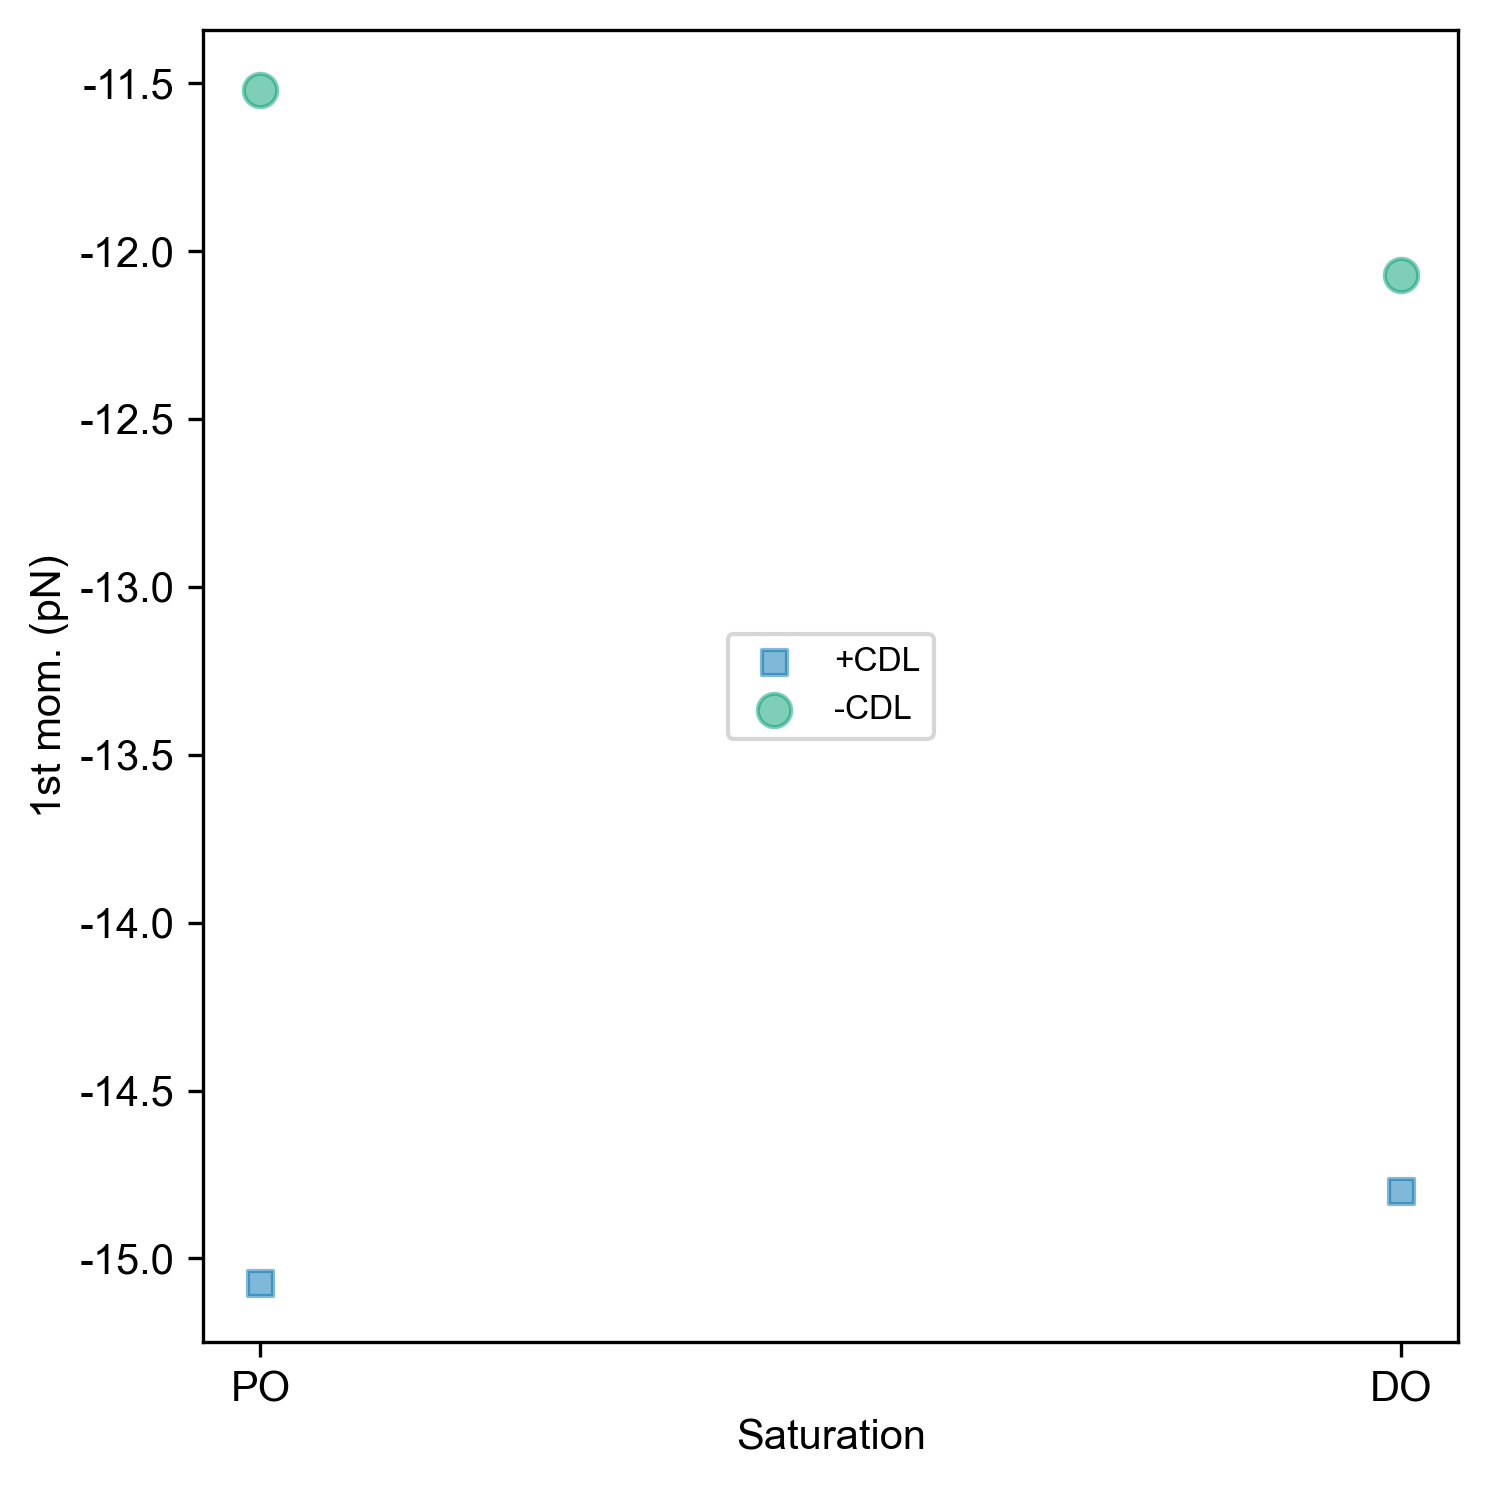

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# ax.axhline(0, color="gray", linestyle="--")

ax.scatter(
    np.arange(0,2),
    [f_cubic_dat[k] for k in [8, 9]],
    label="+CDL",
    marker="s",
    s=6**2,
    alpha=0.5
)
ax.scatter(
    np.arange(0,2),
    [f_cubic_dat[k] for k in [10, 11]],
    label="-CDL",
    s=8**2,
    alpha=0.5
)

# ax.set_ylim(-2, 4)
ax.set_ylabel("1st mom. (pN)")
# ax.tick_params(axis = 'y', labelcolor = 'darkorange')
# ax.set_xlim(0, 25)
ax.set_xticks([0,1], labels = ["PO", "DO"])
# plt.xscale('log')
ax.set_xlabel("Saturation")

plt.legend(loc='center')
plt.tight_layout()
save_fig(fig, "Figures/first_moment")

In [28]:
for sys in simulations:
    print(f"System {sys} c0: {f_cubic_dat[sys]/(KB_VALUES[sys] * 4.18336647): 0.3f} nm")

System 1 c0:  0.283 nm
System 2 c0:  0.342 nm
System 3 c0:  0.309 nm
System 4 c0:  0.114 nm
System 5 c0:  0.119 nm
System 6 c0:  0.132 nm
System 7 c0:  1.070 nm
System 8 c0:  0.351 nm
System 9 c0:  0.491 nm
System 10 c0:  0.109 nm
System 11 c0:  0.140 nm


# TESTING

## Kd, Ke Thickness and Peristaltic Moduli

In [ ]:
def thickness_func(q, kd, ke):
    return 1 / (kd * q**4 + ke)


In [ ]:
kde_low_q = 3


def radial_averaging_nm(power2D, mc, min_bin=0.1, max_bin=10, bin_width=0.1):
    x, y = np.meshgrid(mc.qx * 10, mc.qy * 10)  # convert to nm^-1
    r = np.sqrt(x**2 + y**2)
    bins = np.arange(min_bin, max_bin, bin_width)

    digitized = np.digitize(r, bins)
    bc = np.array(
        [
            r[digitized == i].mean() if np.count_nonzero(digitized == i) else np.NAN
            for i in range(1, len(bins))
        ]
    )
    bm = np.array(
        [
            power2D[digitized == i].mean()
            if np.count_nonzero(digitized == i)
            else np.NAN
            for i in range(1, len(bins))
        ]
    )

    bin_centers = bc[np.isfinite(bm)]
    bin_means = bm[np.isfinite(bm)]

    return np.column_stack((bin_centers, bin_means, bin_centers**4 * bin_means))


def fit_kd_ke_from_power(
    power2D, mc=None, threshold=3, min_bin=0.01, max_bin=10, bin_width=0.01
):
    spectra = radial_averaging_nm(
        power2D, mc, min_bin=min_bin, max_bin=max_bin, bin_width=bin_width
    )

    ke_estimate = 1 / spectra[0:3, 1].mean()
    # print(ke_estimate)

    mask = spectra[:, 0] < threshold
    spectra_cut = spectra[mask, :]
    [kd, ke], _ = curve_fit(
        thickness_func,
        spectra_cut[:, 0],
        spectra_cut[:, 1],
        p0=[1, ke_estimate],
        # bounds=(0, [np.inf, np.inf]),
    )
    return (kd, ke)


In [ ]:
# Reprocess data in nm units...
for sys in simulations:
    d = mc[sys]
    for frame in range(len(d.results.thickness_power_spectrum_fowler)):

        # CONVERT TO nm...
        FFT_thickness = np.fft.fft2(d.results.thickness_fowler[frame] / 10)
        FFT_thickness *= d.x_step / 10 / len(FFT_thickness)
        mc[sys].results.thickness_power_spectrum_fowler[frame] = (
            np.abs(np.fft.fftshift(FFT_thickness)) ** 2
        )  # nm^4


### Statistical Inefficiency

In [ ]:
_s = 10  # Min block

discards = np.arange(0, 100, 10)  # Percent of data to discard from end
blocks = np.arange(1, 101, 1, dtype=int)
# print("Blocks lengths:", blocks)

for sys in simulations:
    print("Processing system:", sys)

    # Set some basic values
    frame_dt = mc[sys].times[1] - mc[sys].times[0]  # picoseconds
    _b = 0
    _e = len(mc[sys].frames)
    n_frames = len(range(_b, _e + 1, _s))
    shape = mc[sys].P.shape

    # Notably times from mdanalysis are unreliable due to restarts
    times = np.arange(0, _e, _s, dtype=int) * frame_dt  # picoseconds

    split_indices = np.arange(_s, _e, _s, dtype=int)
    powers = np.fromiter(
        map(
            partial(np.mean, axis=0),
            np.split(mc[sys].results.thickness_power_spectrum_fowler, split_indices),
        ),
        dtype=np.dtype((np.double, (shape))),
    )

    data = np.fromiter(
        map(partial(fit_kd_ke_from_power, threshold=kde_low_q, mc=mc[sys]), powers),
        dtype=np.dtype((np.double, 2)),
    )

    kds = data[:, 0]
    kes = data[:, 1]

    print(kds.mean(), kes.mean())

    # Plot Kd evaluated over 5ns blocks
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.plot(times * 1e-6, kds)

    ax.set_ylabel(r"$K_d$ ($k_b$T/nm$^4$)")
    ax.set_xlabel(r"Time (μs)")
    ax.set_title(f"System {sys}: {system_names[sys]}")
    plt.tight_layout()
    save_fig(fig, f"Figures/{sys}_kd_5nsblock")

    # Plot Ke evaluated over 5ns blocks
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.plot(times * 1e-6, kes)

    ax.set_ylabel(r"$K_e$ ($k_b$T)")
    ax.set_xlabel(r"Time (μs)")
    ax.set_title(f"System {sys}: {system_names[sys]}")
    plt.tight_layout()
    save_fig(fig, f"Figures/{sys}_ke_5nsblock")

    # Perform block analysis
    kd_mean = kds.mean()
    ke_mean = kes.mean()

    SId = {}
    SId["discards"] = discards
    SIe = {}
    SIe["discards"] = discards

    # split_indices["blocks"] = blocks * frame_dt * _s  # picoseconds

    for discard in discards:
        _, rd = np.split(kds, [int(discard / 100 * n_frames)])
        kd_mean = rd.mean()

        _, re = np.split(kes, [int(discard / 100 * n_frames)])
        ke_mean = re.mean()

        SId[(discard, "sigma")] = np.zeros(len(blocks))
        SId[(discard, "mean")] = np.zeros(len(blocks))

        SIe[(discard, "sigma")] = np.zeros(len(blocks))
        SIe[(discard, "mean")] = np.zeros(len(blocks))

        for i, block in enumerate(blocks):
            n = np.floor(len(rd) / block)

            split_indices = np.arange(block, len(rd), block, dtype=int)

            block_kds = np.fromiter(
                map(np.mean, np.split(rd, split_indices)), dtype=np.double
            )
            block_kes = np.fromiter(
                map(np.mean, np.split(re, split_indices)), dtype=np.double
            )

            if len(rd) % block:
                block_kds = block_kds[:-1]
                block_kes = block_kes[:-1]

            SId[(discard, "sigma")][i] = np.sum((block_kds - kd_mean) ** 2) / n
            SId[(discard, "mean")][i] = np.mean(block_kds)

            SIe[(discard, "sigma")][i] = np.sum((block_kes - ke_mean) ** 2) / n
            SIe[(discard, "mean")][i] = np.mean(block_kes)

    with open(util.analysis_path / f"{sys}/SId.pickle", "wb") as handle:
        pickle.dump(SId, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(util.analysis_path / f"{sys}/SIe.pickle", "wb") as handle:
        pickle.dump(SIe, handle, protocol=pickle.HIGHEST_PROTOCOL)


## Troubleshooting

In [ ]:
# for i in simulations:

#     _, r = np.split(
#         mc[i].results.thickness_power_spectrum_fowler,
#         [int(0.5 * len(mc[i].results.thickness_power_spectrum_fowler))],
#     )
#     thickness_spectra = radial_averaging_nm(
#         np.mean(r, axis=0),
#         mc[i],
#     )

#     mask = thickness_spectra[:, 0] < kde_low_q
#     thickness_spectra_cut = thickness_spectra[mask, :]
#     thickness_spectra = thickness_spectra[~mask, :]

#     popt, pvar = curve_fit(
#         thickness_func, thickness_spectra_cut[:, 0], thickness_spectra_cut[:, 1]
#     )

#     print(popt)

#     fig, ax = plt.subplots(1, 1, figsize=(3, 3))

#     ax.scatter(thickness_spectra[:, 0], thickness_spectra[:, 1], color="silver", s=8)
#     ax.scatter(thickness_spectra_cut[:, 0], thickness_spectra_cut[:, 1], s=8)

#     xdata = np.logspace(-1.5, 1, 100)
#     plt.plot(xdata, thickness_func(xdata, *popt), "r")

#     plt.xscale("log")
#     plt.yscale("log")

#     ax.set_xlim(5e-2, 5)
#     ax.set_ylim(1e-3, 1e3)

#     # plt.text(
#     #     0.1,
#     #     0.2,
#     #     f"$K_c$ = {1.0 / height_spectra_cut[:,2].mean():.1f} $k_BT$",
#     #     color="r",
#     # )

#     ax.set_ylabel(r"intensity (nm$^4$)")
#     ax.set_xlabel(r"$q$ (nm$^{-1}$)")
#     ax.set_title(f"Simulation {i} {system_names[i]}")
#     plt.tight_layout()


In [ ]:
# i = 2
# d = mc[i]

# p = np.full(d.results.thickness_power_spectrum.shape, np.nan)

# for frame in range(len(d.results.thickness_power_spectrum)):
#     FFT_thickness = np.fft.fft2(
#         (d.results.thickness[frame] - np.mean(d.results.thickness[frame])) / 20
#     )
#     FFT_thickness *= d.x_step / 10 / len(FFT_thickness)
#     p[frame] = np.abs(np.fft.fftshift(FFT_thickness)) ** 2  # Angstrom^4


# thickness_spectra = radial_averaging_nm(np.mean(p, axis=0), mc[i])

# low_q = thickness_spectra[:,0] < 0.6
# foo = thickness_spectra[mask,:]

# _ke = foo[:,1].mean()
# print(_ke)


# def thickness_func_local(q, kd):
#     return 1 / (kd * q**4 + _ke)


# mask = thickness_spectra[:, 0] < 3
# thickness_spectra_cut = thickness_spectra[mask, :]
# thickness_spectra = thickness_spectra[~mask, :]

# popt, pvar = curve_fit(
#     thickness_func, thickness_spectra_cut[:, 0], thickness_spectra_cut[:, 1]
# )

# popt2, pvar2 = curve_fit(
#     thickness_func_local, thickness_spectra_cut[:, 0], thickness_spectra_cut[:, 1]
# )

# print(popt, popt2)

# fig, ax = plt.subplots(1, 1, figsize=(3, 3))

# ax.scatter(thickness_spectra[:, 0], thickness_spectra[:, 1], color="silver", s=8)
# ax.scatter(thickness_spectra_cut[:, 0], thickness_spectra_cut[:, 1], s=8)

# xdata = np.logspace(-1, 1, 100)

# plt.plot(xdata, thickness_func(xdata, *popt), "r")

# plt.xscale("log")
# plt.yscale("log")

# ax.set_xlim(5e-2, 5)
# ax.set_ylim(1e-3, 1e3)

# # plt.text(
# #     0.1,
# #     0.2,
# #     f"$K_c$ = {1.0 / height_spectra_cut[:,2].mean():.1f} $k_BT$",
# #     color="r",
# # )
# # plt.text(0.01, 0.001, f"$K_d$ = {popt[0]:.1f} $k_BT$", color="r")
# # plt.text(0.01, 0.0001, f"$K_e$ = {popt[1]:.1f} $k_BT$", color="r")

# ax.set_ylabel(r"intensity (A$^4$)")
# ax.set_xlabel(r"$q$ (nm$^{-1}$)")
# ax.set_title(f"Simulation {i} {system_names[i]}")
# plt.tight_layout()


In [ ]:
for sys in simulations:
    print(
        f"System {sys} ({system_names[sys]}): {np.mean(mc[sys].results.thickness)/10}"
    )


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for sys in range(1,4):
    # d = np.concatenate((mc[sys].results.['upper'][9000:-1], mc[sys].results.['lower'][9000:-1])).reshape(-1,1)
    # print(d.shape)
    d = mc[sys].results.height[5000:-1].reshape(-1,1)

    ax.hist(d, range=(-30,30), bins=200, alpha=0.1, label=f"{sys}")
fig.legend()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
d = []
for sys in range(4,7):
    # d = np.concatenate((mc[sys].results.['upper'][9000:-1], mc[sys].results.['lower'][9000:-1])).reshape(-1,1)
    # print(d.shape)
    d = mc[sys].results.thickness[5000:-1].reshape(-1,1)

    ax.hist(d,  range=(30,70), bins=200, alpha=0.1, label=f"{sys}")
fig.legend()

In [ ]:
for sys in simulations:
    print(np.mean(mc[sys].results.thickness))